# Artist Recommendation
## Елисеева Александра

## 1. Загрузка данных

Для начала, распакуем данные и для удобства сделаем из них датафремы. С исходным форматом получилось работать, используя обычный csv-парсер pandas, передав ему указанные в документации idomaar названия столбцов. Правда, в столбцах `properties` и `linked_entities` собраны целые словари, так что с этим необходимо разобраться отдельно.

In [118]:
import tarfile
import json
import pandas as pd
import numpy as np
from urllib.parse import unquote
import seaborn as sns
import re
import json
import math
import time
import scipy.stats as stats
from sklearn.neighbors import NearestNeighbors
from gensim.models import Word2Vec
import umap
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
sns.set(style="whitegrid", palette="pastel", color_codes=True)
pd.options.display.float_format = '{:.3f}'.format

In [2]:
tar = tarfile.open("./30Music/ThirtyMusic.tar", "r")
data = []   # list of dataframes
for el in tar:
    if el.name in ['entities/users.idomaar', 'entities/tracks.idomaar', 'entities/tags.idomaar', 'entities/persons.idomaar', 
                   'relations/sessions.idomaar']:
        f = tar.extractfile(el)
        if f:
            cols = ['type', 'id', 'timestamp', 'properties', 'linked_entities'] # took from idomaar data format documentation
            data.append(pd.read_csv(f, sep='\t', header=None, names=cols, dtype={'id': int, 'timestamp': int}))
tar.close()

У нас есть `entities`, есть `relationships` - связи между ними. Это очень напоминает реляционную теорию.

## 2. Обработка данных

Остановимся на важных для нас сущностях: `users`, `tracks`, `persons`, `tags` `sessions`. В частности, поработаем со столбцами `properties` и `linked_entities`, чтобы можно было использовать их содержимое.

### 1. Пользователи

In [3]:
data[0].head()

,type,id,timestamp,properties,linked_entities
0,user,1,1116715959,"{""lastfm_username"":""000123"",""gender"":""f"",""age""...",nan
1,user,2,1163123792,"{""lastfm_username"":""000333"",""gender"":""m"",""age""...",nan
2,user,3,1184426573,"{""lastfm_username"":""00elen"",""gender"":""f"",""age""...",nan
3,user,4,1123157597,"{""lastfm_username"":""00Eraser00"",""gender"":""m"",""...",nan
4,user,5,1171302116,"{""lastfm_username"":""00fieldsy"",""gender"":""m"",""a...",nan


In [4]:
data[0].shape[0]

45167

In [5]:
data[0]['linked_entities'].notnull().values.any()

False

В случае с пользователями у нас нет связанных сущностей, поэтому сосредоточимся на том, чтобы достать столбцы из `properties`.

In [6]:
def change_str(s):
    try:
        return unquote(s) # needed for %CE%B1%CE%BB%20-like encoding in tracks' titles
    except TypeError:
        return s


def properties(df):
    keys = list(json.loads(df['properties'][0]).keys())
    df = df.copy()
    for key in keys:
        df[key] = [change_str(json.loads(row.replace(":,", ": null,"))[key]) for row in df['properties']]
    return df.drop(['properties', 'linked_entities'], axis=1)

In [7]:
users = properties(data[0]).sort_values(by='timestamp')
len(users['lastfm_username'].unique()) == len(users)

True

В итоге датафрейм `users` принимает следующий вид:

In [8]:
users.head()

,type,id,timestamp,lastfm_username,gender,age,country,playcount,playlists,subscribertype
39597,user,39598,1035849600,zensir,m,36.000,ES,43762,5,base
2603,user,2604,1036108800,astrogarage,n,52.000,UK,106121,2,base
30141,user,30142,1037793040,RJ,m,32.000,UK,102919,4,premium
30772,user,30773,1042848000,RUPERT,n,34.000,UK,20917,2,premium
34350,user,34351,1044666561,suzannarama,n,nan,US,45938,3,base


Обработаем пропущенные значения.

In [9]:
users['gender'].replace(['', ' '], 'gender not stated', inplace=True)
users['country'].replace(['', ' '], 'country not stated', inplace=True)
users['age'].replace(['', ' '], users['age'].mean(), inplace=True)
users['age'].fillna(users['age'].mean(), inplace=True)

Немного уменьшим занимаемую память.

In [10]:
users = users.astype({'age': 'int32', 'playcount': 'int32', 'playlists': 'int32'})

Посмотрим на графики для некоторых признаков пользователей.

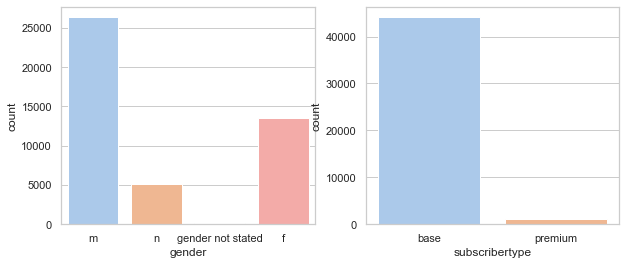

In [11]:
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

sns.countplot(x ='gender', data = users, ax=ax1)
sns.countplot(x ='subscribertype', data = users, ax=ax2)
plt.show()

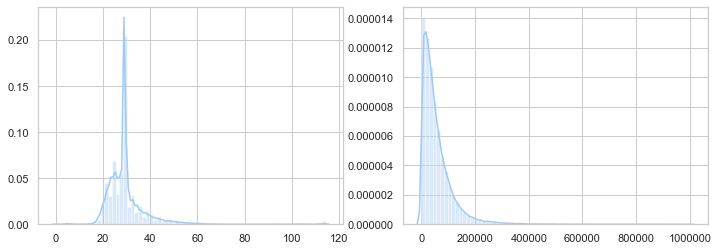

In [12]:
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

sns.distplot(users['age'].values, ax=ax1, bins='rice')
sns.distplot(users['playcount'].values, ax=ax2, bins='rice')
plt.show()

In [13]:
del data[0]

### 2. Треки

In [14]:
data[0].head()

,type,id,timestamp,properties,linked_entities
0,track,0,-1,"{""duration"":-1,""playcount"":4,""MBID"":null,""name...","{""artists"":[{""type"":""person"",""id"":0}],""albums""..."
1,track,1,-1,"{""duration"":-1,""playcount"":495,""MBID"":null,""na...","{""artists"":[{""type"":""person"",""id"":1}],""albums""..."
2,track,2,-1,"{""duration"":-1,""playcount"":2,""MBID"":null,""name...","{""artists"":[{""type"":""person"",""id"":2}],""albums""..."
3,track,3,-1,"{""duration"":-1,""playcount"":2,""MBID"":null,""name...","{""artists"":[{""type"":""person"",""id"":3}],""albums""..."
4,track,4,-1,"{""duration"":-1,""playcount"":1,""MBID"":null,""name...","{""artists"":[{""type"":""person"",""id"":4}],""albums""..."


In [15]:
data[0].shape[0]

5675143

Здесь уже нужно поработать и с `properties`, и с `linked_entities`. Воспользуемся уже написанной функцией для `properties`:

In [16]:
tracks = properties(data[0])
tracks.drop(columns=['type', 'timestamp'], inplace=True)

In [17]:
tracks.head(10)

,id,duration,playcount,MBID,name
0,0,-1.000,4.000,None,000003+Music+Instructor/_/Dj's+Rock+Da+House+Â...
1,1,-1.000,495.000,None,00-01/_/Текст
2,2,-1.000,2.000,None,0005.+Overkill/_/Overkill
3,3,-1.000,2.000,None,000C+Tony+Dize/_/Ruleta+Rusa
4,4,-1.000,1.000,None,000+Oscarcito/_/Tumbay‚+(Lyrics)
5,5,-1.000,16.000,None,000/_/Rats+and+Butterflies+(Original+Mix)
6,6,-1.000,34.000,None,0+0+0/_/Verticle
7,7,-1.000,163.000,None,000/_/Verticle
8,8,269000.000,163.000,bba8bc34-850d-4b40-996a-13b769c190a0,0010110000010011+(Cancer)/_/Naonian+Style
9,9,-1.000,12.000,None,001/_/03_Respublika


In [18]:
tracks['name'] = [re.sub("[\(\[/\)]", "", track).replace('+', ' ') for track in tracks['name']]

In [19]:
tracks.head()

,id,duration,playcount,MBID,name
0,0,-1.000,4.000,None,000003 Music Instructor_Dj's Rock Da House Â≈Æ...
1,1,-1.000,495.000,None,00-01_Текст
2,2,-1.000,2.000,None,0005. Overkill_Overkill
3,3,-1.000,2.000,None,000C Tony Dize_Ruleta Rusa
4,4,-1.000,1.000,None,000 Oscarcito_Tumbay‚ Lyrics


Можно заметить, что в столбцах `duration` и `playcount` есть отрицательные значения, что немного противоречит здравому смыслу. Посмотрим подробнее.

In [20]:
tracks['duration'].value_counts(normalize=True).head(1)

-1.000   0.620
Name: duration, dtype: float64

In [21]:
tracks['playcount'].loc[tracks['playcount'] < 0].value_counts()

-1.000    1
-6.000    1
Name: playcount, dtype: int64

В `duration` 62% элементов имеют значение -1, что намекает, что пользоваться `duration` не стоит, поэтому отбросим этот столбец. В `playcount` всего два элемента с отрицательными значениями, так что тут все хорошо.

Так как данных очень много, оставим только треки, имеющие `MBID` -- MusicBrainz Identifier. Это относится, кажется, к большинству хоть немного популярных исполнителей и их музыке.

Перейдем к столбцу `linked_entities` и постараемся обработать его.

In [22]:
tracks.shape[0]

5675143

In [23]:
json.loads(data[0]['linked_entities'][27])

{'artists': [{'type': 'person', 'id': 19}], 'albums': [], 'tags': []}

In [24]:
tracks['artist_id'] = [json.loads(lnkd_str)['artists'][0]['id'] for lnkd_str in data[0]['linked_entities']] # 1 - 1
tracks['MBID'].replace('', np.nan, inplace=True)
tracks.dropna(subset=['MBID'], inplace=True)
tracks.drop('duration', axis=1, inplace=True)
tracks['name'] = [tr.replace('+', ' ') for tr in tracks['name']]
tracks = tracks.astype({'id': 'int32', 'playcount': 'int32', 'artist_id': 'int32'})

In [25]:
tracks.head()

,id,playcount,MBID,name,artist_id
8,8,163,bba8bc34-850d-4b40-996a-13b769c190a0,0010110000010011 Cancer_Naonian Style,7
76,76,1,425811df-56ba-4c0a-b142-4e5e871c8839,"006_Like What, Me Worry",39
107,107,4,473e5ac6-4ed5-4208-9e87-e12ec41fd46d,009 Sound System_Born To Be Wasted,53
109,109,291,6eab3a76-729f-43c0-9a13-ff74d641beb8,009 Sound System_Dreamscape,53
118,118,1310,87152897-db4e-43f6-8094-05641c3eccd1,009 Sound System_Holy Ghost,53


In [26]:
tracks.shape[0]

1197831

In [27]:
tracks.drop_duplicates(subset=['id'], inplace=True)

In [28]:
tracks.shape[0]

1053794

In [29]:
tracks.sort_values(by='playcount', ascending=False).head()

,id,playcount,MBID,name,artist_id
2466968,2369978,1285338,34678368-3745-4930-b3df-a05f156e8d78,Riton_Put That on My Momma,296242
2041262,1949999,367773,50f638c4-8df1-4a8d-b15a-5d6d17a2d5e3,Nação Zumbi_No Olimpo,244465
2041261,1949998,367773,887d4e5d-44db-4421-9a61-fc12c335eb89,Nação Zumbi_Nebulosa,244465
829857,818184,367595,988329a8-42c4-40b5-9c4b-0ccc63797076,The Dave Brubeck Quartet_Take Five,105012
2307328,2212278,289367,03176188-03a4-448a-91be-80f591063b68,Pitbull_Juice Box,276626


In [30]:
del data[0]

### 3. Исполнители

Здесь, как и в случае с пользователями, у нас нет связанных сущностей, поэтому достанем столбцы из `properties`.
Отбросим исполнителей, не имеющих `MBID`, и заметим, что вместо пробелов в строке с именем используются +, и поменяем обратно :)

In [31]:
data[1].head()

,type,id,timestamp,properties,linked_entities
0,person,145148,-1,"{""MBID"":null, ""name"":""Everything+Is+Illuminated""}",{}
1,person,297899,-1,"{""MBID"":null, ""name"":""Robin+O%27Brien""}",{}
2,person,250429,-1,"{""MBID"":null, ""name"":""Nicholas+Gunn++(2012)""}",{}
3,person,32765,-1,"{""MBID"":null, ""name"":""Aspasia+Stratigou""}",{}
4,person,18689,-1,"{""MBID"":null, ""name"":""Allison+Veltz""}",{}


In [32]:
data[1]['linked_entities'].value_counts(normalize=True)

{}   1.000
Name: linked_entities, dtype: float64

In [33]:
data[1].shape[0]

595049

In [34]:
artists = properties(data[1])
artists.drop(columns=['type', 'timestamp'], inplace=True)

In [35]:
artists['MBID'].replace('', np.nan, inplace=True)
artists.dropna(subset=['MBID'], inplace=True)
artists['name'] = [art.replace('+', ' ') for art in artists['name']]
artists.head()

,id,MBID,name
8,187320,5886a9b8-54ff-4818-80c1-25b3b85ba5cf,Koota Tanimura
9,103135,d4bb4ce4-5439-49a3-bda6-10e8c6f61932,Danny Overbea
10,114070,bded4d70-f13f-41ee-86b9-8c4514086acf,Dimebag Darrell
13,119391,cb6d3300-405a-49b2-8fad-bd36c91bee05,Doi-Oing
16,173291,9928a9c4-285b-4c37-b7f8-001bf03df97c,G-Spliff


In [36]:
artists.shape[0]

125641

Для каждого исполнителя в таблице `artists` может быть несколько строчек, по-разному задающее его имя / название. Не совсем понятно, как одним общим подходом выбрать для каждого лучшую из этих строчек.

In [37]:
artists.drop_duplicates(subset=['id'], inplace=True)

In [38]:
artists.shape[0]

114051

In [39]:
del data[1]

Объединим таблицы `tracks` и `artists` и попробуем посмотреть, у каких исполнителей больше всего прослушиваний:

In [40]:
artists = pd.merge(tracks, artists, left_on='artist_id', right_on='id')
artists.rename(columns={'id_x': 'track_id', 'name_x': 'track_name', 'name_y': 'artist_name', 'MBID_x': 'track_MBID', 'MBID_y': 'artist_MBID'}, inplace=True)
artists.drop(['id_y'], axis=1, inplace=True)
artists.head()

,track_id,playcount,track_MBID,track_name,artist_id,artist_MBID,artist_name
0,8,163,bba8bc34-850d-4b40-996a-13b769c190a0,0010110000010011 Cancer_Naonian Style,7,8aa5f7a7-e759-4a03-87fd-7cb3a34c407d,0010110000010011 (Cancer)
1,76,1,425811df-56ba-4c0a-b142-4e5e871c8839,"006_Like What, Me Worry",39,0d59f5d0-df4e-4660-8973-f7b62ee6a9f1,006
2,107,4,473e5ac6-4ed5-4208-9e87-e12ec41fd46d,009 Sound System_Born To Be Wasted,53,2245dc3a-4ec6-4ecb-a945-b8249e1f84e0,009 Sound System
3,109,291,6eab3a76-729f-43c0-9a13-ff74d641beb8,009 Sound System_Dreamscape,53,2245dc3a-4ec6-4ecb-a945-b8249e1f84e0,009 Sound System
4,118,1310,87152897-db4e-43f6-8094-05641c3eccd1,009 Sound System_Holy Ghost,53,2245dc3a-4ec6-4ecb-a945-b8249e1f84e0,009 Sound System


Попробуем посмотреть на исполнителей с наибольшим числом прослушиваний.

In [41]:
plays = artists.groupby(['artist_id']).agg({'playcount': sum, 'artist_name': 'last'})

In [42]:
plays.head(10)

,playcount,artist_name
artist_id,,
7,163,0010110000010011 (Cancer)
39,1,006
53,14027,009 Sound System
54,1,00.db
55,1,00Genesis
57,114,0=0
58,2600,00tz 00tz
78,119440,012_All Saints
109,143358,BT & Paul van Dyk


In [43]:
plays.describe(percentiles=[.1, .25, .5, .75, .9])

,playcount
count,92366.000
mean,25638.203
std,88968.490
min,0.000
10%,28.000
25%,231.000
50%,1831.000
75%,12436.750
90%,58725.500
max,3930475.000


Заметим, что для $90\%$ исполнителей общее число прослушиваний их треков $\leq 58725$, при этом $75\%$ $\leq 12436$.

При этом максимальное значение в датасете достигает $3.9$ миллионов, и стандартное отклонение достаточно большое --- $88$ тысяч.

Посмотрим на распределение $90\%$ датасета:

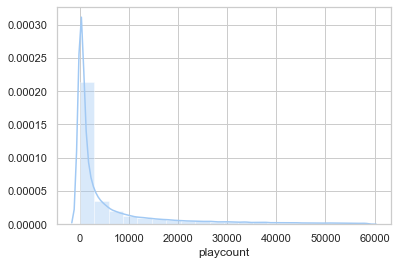

In [44]:
sns.distplot(plays['playcount'].loc[plays['playcount'] < 58725], bins=20)
plt.show()

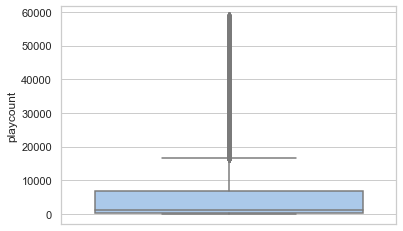

In [45]:
sns.boxplot(y=plays['playcount'].loc[plays['playcount'] < 58725])
plt.show()

И на топ-10 самых прослушиваемых исполнителей:

In [46]:
plays.sort_values(by='playcount', ascending=False).head(10)

,playcount,artist_name
artist_id,,
429274,3930475,Håkan Hellström & Göteborgs Symfoniker
240017,3566682,The Mountain Goats
185344,3417804,K.I.Z.
111129,3339038,Despised Icon
72167,2914885,Ceremony
52181,2722497,Blonde Redhead
250543,2580973,Nick Cave and the Bad Seeds
140477,2394226,Engenheiros Do Hawaii
128599,2296336,東京事変


Меня насторожило, что я мало кого отсюда знаю. Маловероятно, что самый прослушиваемый исполнитель - шведский музыкант. Поэтому я решила не ориентироваться на значение `playcount` от треков в дальнейшем.

### 4. Сессии

Здесь, как и в случае с пользователями, у нас нет связанных сущностей, поэтому достанем столбцы из `properties`. 

In [47]:
data[1].head()

,type,id,timestamp,properties,linked_entities
0,event.session,287144,1390231051,"{""numtracks"":23,""playtime"":4547} {""subjects"":[...",nan
1,event.session,287145,1390241844,"{""numtracks"":11,""playtime"":2907} {""subjects"":[...",nan
2,event.session,287146,1390303249,"{""numtracks"":16,""playtime"":3191} {""subjects"":[...",nan
3,event.session,287147,1390481828,"{""numtracks"":5,""playtime"":1162} {""subjects"":[{...",nan
4,event.session,287140,1421443687,"{""numtracks"":2,""playtime"":250} {""subjects"":[{""...",nan


In [48]:
data[1].shape[0]

2764474

In [49]:
data[1]['linked_entities'].notnull().values.any()

False

In [50]:
def func(row):
    dic = json.loads(row.split("} ", 1)[1])
    usr = dic['subjects'][0]['id']
    return np.array([[usr, pl['id'], pl['playratio']] for pl in dic['objects']])


def session_properties(df):
    return pd.DataFrame(np.concatenate([func(row) for row in df['properties']]), columns=['user_id', 'track_id', 'playratio'])

sessions = session_properties(data[1])

In [51]:
sessions.head()

,user_id,track_id,playratio
0,44361,4698874,None
1,44361,838286,1.010
2,44361,2588097,1.010
3,44361,2746740,1.440
4,44361,3873988,1.010


In [52]:
sessions.shape[0]

31351945

In [53]:
sessions = sessions.astype({'user_id': 'int32', 'track_id': 'int32'})

Мы получили информацию о прослушивании треков пользователями, теперь перейдем от этого к исполнителям.

In [54]:
artist_sessions = pd.merge(sessions, artists, on='track_id')
artist_sessions.drop(columns=['playcount', 'track_id', 'track_MBID', 'track_name', 'artist_MBID', 'playratio'], inplace=True)
artist_sessions.head()

,user_id,artist_id,artist_name
0,44361,107103,Dawes
1,32894,107103,Dawes
2,32894,107103,Dawes
3,23183,107103,Dawes
4,28231,107103,Dawes


Посмотрим на самых прослушиваемых на основе данных о сессиях исполнителей.

In [55]:
artist_sessions.groupby('artist_name').agg({'user_id': 'count'}).rename(columns={'user_id': 'playcount'}).sort_values(by='playcount', ascending=False).head(10)

,playcount
artist_name,
Arctic Monekys,99731
Lana Del Rey,96143
RadioheadNCON,80647
Coldplay & Kylie Minogue,75972
Pink Floyd & Floyd,72836
The Beatles & George Martin,63925
Taylor Swift & Def Leppard,59676
The Black Keys,51607
"National, The",50494


Здесь в топе действительно известные исполнители, что выглядит более естественно, чем прошлая табличка.

In [56]:
sessions = artist_sessions.drop_duplicates(subset=['user_id', 'artist_id']).groupby(['user_id']).agg({'artist_name': list})
sessions.head()

,artist_name
user_id,
1,"[Mac DeMarco, The Cure & James McCartney, Alt-..."
2,"[Shpongle, Sarah Menescal, Fakear, Thievery Co..."
3,"[DragonForce, HammerFall, Dire Straights, Tarj..."
4,"[Avril Lavigne & Goo goo dolls, Imagine Dragon..."
5,"[Frank Sinatra & Tanya Tucker, Sam Smith, City..."


In [57]:
sessions = sessions[sessions['artist_name'].map(len) >= 10]

In [58]:
max_len = max(len(row) for row in sessions['artist_name'])
print(max_len) # максимальная длина сессии

3984


Таким образом, мы получили табличку, где каждому пользователю в виде списка сопоставлены прослушанные им исполнители. Пока мы не использовали дополнительной информации о исполнителях, попробуем получить что-то на основе этого, а дальше, возможно, как-то развить другие идеи. Например, однозначно могут быть интересными теги, которые пользователи ставят трекам, и явно выраженные реакции из файла `love`.

## 3. Разбиение на train/validation/test и метрики качества

Для начала, разобьем данные на train, validation и test. Возьмем 60% данных в train для обучения модели, 20% данных в validation для подбора гиперпараметров и оставшиеся 20% в test для оценки результатов.

In [121]:
X_train, X_test, y_train, y_test = train_test_split(np.array([el[:-1] for el in sessions['artist_name'].tolist()]), np.array([el[-1] for el in sessions['artist_name'].tolist()]), test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

Рассмотрим метрики, которые можем применить для оценки качества рекомендаций.

* $\text{Hit Rate@k}$

    Пусть в общем виде плейлист выглядит следующим образом: $x_1, \dots, x_n$, рекомендации для $x_{n-1}$: $y_1, \dots, y_k$.

    Мы будем проверять, есть ли среди топ-k рекомендованных для $x_{n-1}$ элементов $x_n$. То есть, это выглядит как-то так:

    $HR@k =\begin{cases}1,&\text{if x_n in recommended items @k} \\ 0,&\text{else}\end{cases}$

* $\text{Normalized discounted cumulative gain (NDCG@k)}$ позволяет также оценить качество ранжирования рекомендаций.

     Пусть, опять же, у нас есть плейлист $x_1, \dots, x_n$, и мы рассматриваем топ-k рекомендаций для $x_{n-1}$: $y_1, \dots, y_k$. Тогда:

    $NDCG@k = \begin{cases}\frac{1}{\log_2(i + 1)},&\text{if } y_i = x_n \\ 0,&\text{else}\end{cases}$

Еще некоторые метрики из сферы информационного поиска неплохо подходят для этой задачи:

* $\text{Precision@k}$ - точность, позволяет оценить, насколько релевантны наши рекомендации

    $P@k = \frac{\text{# of recommended items @k that are relevant}}{\text{total # of recommended items @k}}$

* $\text{Recall@k}$ - полнота, позволяет оценить, насколько наши рекомендации охватывают релевантных для пользователя исполнителей

    $R@k = \frac{\text{# of recommended items @k that are relevant}}{\text{total # of relevant items}}$

* $F_1@k = 2 \frac{Precision@k \cdot Recall@k}{Precision@k + Recall@k}$  - стандартный $F_1$-score, позволяет оценивать и точность, и полноту одновременно

Мне не удалось найти подходящего для данной задачи хорошего описания или хорошей реализации трех последних метрик, поэтому я написала их сама *(для первых двух есть хорошее описание в статье [Word2vec applied to Recommendation: Hyperparameters Matter](https://arxiv.org/abs/1804.04212))*. Вышло не самым оптимизированным образом --- к данным, которые получаются после работы с моделью `Word2Vec`, не очень удобно применять векторизированные операции, а циклы в самом питоне работают гораздо медленнее. Также эта реализация метрик зависит от использования модели `Word2Vec` из `gensim`, что тоже является не лучшей идеей (и чего тоже можно было избежать). Тем не менее, я решила пока остановиться на этом, потому что на имеющихся данных все работает за достаточно разумное время.

In [57]:
def hit_rate(X, y, model, k=10):
    cnt = np.sum([any([el[0] == y[i] for el in model.wv.similar_by_vector(model.wv[pl[-1]], topn=k+1)[1:]]) for i, pl in enumerate(X) if pl[-1] in model.wv])
    return cnt / len(X)


def NDCG(X, y, model, k=10):
    cnt = 0
    for i, pl in enumerate(X):
        try:
            val = [el[0] for el in model.wv.similar_by_vector(model.wv[pl[-1]], topn=k+1)[1:]].index(y[i])
            cnt += 1 / math.log2(val + 2)
        except KeyError: # artist is not in vocab (it happens)
            pass
        except ValueError: # y[i] is not present in recommendations
            pass
    return cnt / len(X)


def precision(X, model, k=10):
    prec = []
    for i, pl in enumerate(X):
        vec = [model.wv[art] for art in pl if art in model.wv]
        if vec:
            # let's use average of artists' vectors as playlist vector
            rec = model.wv.similar_by_vector(np.mean(vec, axis=0), topn=k+1)[1:]
            prec.append(len([el for el in rec if el[0] in pl]) / len(rec))
    return np.mean(prec)


def recall(X, model, k=10):
    recall = []
    for i, pl in enumerate(X):
        vec = [model.wv[art] for art in pl if art in model.wv]
        if vec:
            # let's use average of artists' vectors as playlist vector
            rec = model.wv.similar_by_vector(np.mean(vec, axis=0), topn=k+1)[1:]
            recall.append(len([el for el in rec if el[0] in pl]) / len(pl))
    return np.mean(recall)


def F1(X, model, k=10):
    prec = precision(X, model, k)
    rec = recall(X, model, k)
    return 2 * prec * rec / (prec + rec)


def scores(X, y, model, k=10):
    HR = hit_rate(X, y, model, k)
    ndcg = NDCG(X, y, model, k)
    prec = precision(X, model, k)
    rec = recall(X, model, k)
    f1 = 2 * prec * rec / (prec + rec)
    return HR, ndcg, prec, rec, f1

## 3. Векторное представление данных

### 1. Демографический подход

Первое, что пришло мне в голову - посмотреть для каждого исполнителя, люди какого пола, возраста и происхождения их слушают, и на основании этих данных считать между ними близость. Начнем составлять подобный датасет.

In [63]:
artists = pd.merge(artist_sessions, users, left_on='user_id', right_on='id')
artists.drop(columns=['id', 'timestamp', 'lastfm_username', 'type', 'playlists'], inplace=True)
artists.head()

,user_id,artist_id,artist_name,gender,age,country,playcount,subscribertype
0,44361,107103,Dawes,n,29,country not stated,16247,base
1,44361,324333,Smoke Fairies,n,29,country not stated,16247,base
2,44361,344448,Tape Five & Brenda Boykin,n,29,country not stated,16247,base
3,44361,103824,Dark Dark Dark,n,29,country not stated,16247,base
4,44361,312289,Seeed feat. Black Kappa,n,29,country not stated,16247,base


In [64]:
artists['age'].dropna(inplace=True)

In [66]:
artists = pd.concat([artists, pd.get_dummies(artists['gender'], prefix='gender')], axis=1) # one-hot encoding for gender
artists = pd.concat([artists, pd.get_dummies(artists['subscribertype'], prefix='subscribertype')], axis=1) # one-hot encoding for subscribertype
artists.drop(columns=['gender', 'subscribertype'], inplace=True)
artists.head()

,user_id,artist_id,artist_name,age,country,playcount,gender_f,gender_gender not stated,gender_m,gender_n,subscribertype_base,subscribertype_premium
0,44361,107103,Dawes,29,country not stated,16247,0,0,0,1,1,0
1,44361,324333,Smoke Fairies,29,country not stated,16247,0,0,0,1,1,0
2,44361,344448,Tape Five & Brenda Boykin,29,country not stated,16247,0,0,0,1,1,0
3,44361,103824,Dark Dark Dark,29,country not stated,16247,0,0,0,1,1,0
4,44361,312289,Seeed feat. Black Kappa,29,country not stated,16247,0,0,0,1,1,0


На данном этапе мне хотелось добавить и информацию о странах пользователей тоже, но с one-hot encoding получалось более 200 столбцов, и память на моем ноутбуке неизбежно заканчивалась. Так как эта модель служит как простой baseline, я решила остановиться на данном этапе и сосредоточиться на решении других задач.

In [77]:
dem = artists.groupby('artist_id').agg({
                                        'user_id':'count', 
                                        'age': 'mean',
                                        'gender_f': 'sum', 
                                        'gender_m': 'sum',
                                        'gender_n': 'sum', 
                                        'gender_gender not stated': 'sum',
                                        'artist_name': 'last'}).reset_index()

# percentage
dem['gender_f'] = dem['gender_f'] / dem['user_id']
dem['gender_m'] = dem['gender_m'] / dem['user_id']
dem['gender_n'] = dem['gender_n'] / dem['user_id']
dem['gender_gender not stated'] = dem['gender_gender not stated'] / dem['user_id']
dem.rename(columns={'user_id': 'user_count'}, inplace=True)
dem.head()

,artist_id,user_count,age,gender_f,gender_m,gender_n,gender_gender not stated,artist_name
0,7,7,34.571,0.286,0.714,0.000,0.000,0010110000010011 (Cancer)
1,39,2,28.000,1.000,0.000,0.000,0.000,006
2,53,89,26.045,0.157,0.775,0.067,0.000,009 Sound System
3,54,1,28.000,0.000,1.000,0.000,0.000,00.db
4,55,1,29.000,0.000,0.000,1.000,0.000,00Genesis


Будем искать ближайших соседей по косинусному расстоянию, используя реализацию NearestNeighbors из sklearn для неразмеченных данных. В случае с этим алгоритмом у нас нет привычного обучения: мы просто запоминаем расстояния между элементами.

In [119]:
data = dem.drop(columns=['artist_id', 'artist_name', 'user_count']).fillna(0).values
model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
model_knn.fit(data)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [130]:
# query_index = np.random.choice(data.shape[0]) random
art = 'Arctic Monekys'
query_index = dem.index[dem['artist_name'] == art].tolist()[0]

distances, indices = model_knn.kneighbors(data[query_index].reshape(1, -1), n_neighbors = 11)
distances = distances.flatten()
indices = indices.flatten()

for i in range(0, len(distances)):
    if not i:
        print('Recommendations for {0}:\n'.format(dem.iloc[query_index]['artist_name']))
    else:
        print("{0}: {1}, with distance of {2}:".format(i, dem['artist_name'].values[indices[i]], distances.flatten()[i]))

Recommendations for Sinitta:

1: Gerry Mulligan Quartet, with distance of 5.177368778142011e-08:
2: 葉加瀬太郎, with distance of 7.154576220358422e-08:
3: The Nkengas, with distance of 7.154576220358422e-08:
4: Kellie Rucker, with distance of 7.154576220358422e-08:
5: Marc Vision, with distance of 7.832633697191227e-08:
6: Cactus World News, with distance of 8.458930189636504e-08:
7: Blue System, with distance of 8.963360154101707e-08:
8: Mats Ronander & Kim Larsen, with distance of 9.279642732007432e-08:
9: Audiojack, with distance of 9.279642732007432e-08:
10: Martha Wash, with distance of 9.564219805024976e-08:


In [136]:
def make_query(artist=None, query_index=None, k=10):
    if artist:
        query_index = dem.index[dem['artist_name'] == artist].tolist()[0]
    distances, indices = model_knn.kneighbors(data[query_index].reshape(1, -1), n_neighbors = k + 1)
    distances = distances.flatten()
    indices = indices.flatten()
    return [dem['artist_name'].values[index] for i, index in enumerate(indices) if i]


make_query(artist='Arctic Monekys')

['Gerry Mulligan Quartet',
 '葉加瀬太郎',
 'The Nkengas',
 'Kellie Rucker',
 'Marc Vision',
 'Cactus World News',
 'Blue System',
 'Mats Ronander & Kim Larsen',
 'Audiojack',
 'Martha Wash']

Но мы все еще можем проверить качество модели на выборке `X_test`. Реализуем метрики Hit Rate и NDCG для этого случая:

In [148]:
def hit_rate_NN(X, y, k=10):
    return np.sum([y[i] in make_query(artist=X[i][-1]) for i in range(X.shape[0])]) / X.shape[0]   
        
    
def NDCG_NN(X, y, k=10):
    cnt = 0
    for i, pl in enumerate(X):
        try:
            ind = make_query(artist=X[i][-1]).index(y[i])
            cnt += 1 / math.log2(ind + 2)
        except:
            pass
    return cnt / X.shape[0]

In [150]:
HR = hit_rate_NN(X_test, y_test)
print(f"hit rate: {HR}")
ndcg = NDCG_NN(X_test, y_test)
print(f"NDCG: {ndcg}")

hit rate: 0.0012464165524118161
NDCG: 0.0005437555043708372


### 2. Word2Vec

Word2Vec — модель, используящаяся в NLP. Она позволяет получить векторные представления для слов на основе имеющихся предложений. Меня заинтересовали статьи, описывающие применение этой же модели для получения векторного представления "предметов" и использования в рекомендательных системах. В частности, [Word2vec applied to Recommendation: Hyperparameters Matter](https://arxiv.org/abs/1804.04212) и [From Word Embeddings to Item Recommendation](https://arxiv.org/abs/1601.01356). 

Воспользуемся реализацией модели word2vec из библиотеки gensim и попробуем применить ее к нашим данным.

In [54]:
base_model = Word2Vec(workers=4) # my CPU has 4 cores
base_model.build_vocab(sessions['artist_name'].tolist()) # all artists should be in vocab
base_model.train(X_train, total_examples=base_model.corpus_count, epochs=base_model.epochs) # but we will train model on X_train

(12240455, 12511325)

In [55]:
base_model.init_sims(replace=True)  # people say that this helps optimize memory usage if you don't plan to train model anynore

In [56]:
base_model.wv[base_model.wv.vocab].shape # we have 100-dimensional embeddings!

(42825, 100)

После работы Word2Vec каждый исполнитель представляется 100-мерным вектором. Визуализируем полученные вектора в некотором двумерном пространстве, используя метод UMAP для снижения размерности.

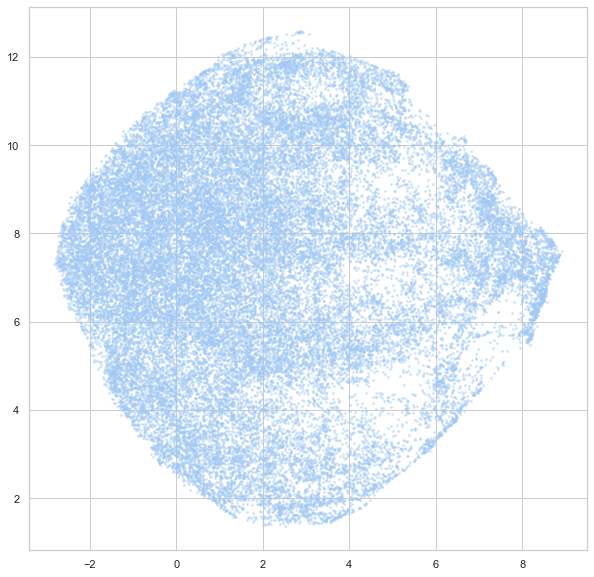

In [57]:
embedding = umap.UMAP(n_components=2).fit_transform(base_model.wv[base_model.wv.vocab])
plt.figure(figsize=(10,10))
plt.scatter(embedding[:, 0], embedding[:, 1], s=3, alpha=0.4)
plt.show()

Большая часть исполнителей здесь находится слева, причем очень близко друг к другу. В правой части графика данные расположены более разреженно и достаточно отчетливо отделены от остальных. Впрочем, сложно сказать, можно ли на основе данного графика оценить качество полученных представлений. Посмотрим на значения метрик:

In [58]:
print(f"train hit rate: {hit_rate(X_train, y_train, base_model)}")
print(f"train NDCG: {NDCG(X_train, y_train, base_model)}")
print(f"train precision: {precision(X_train, base_model)}")
print(f"train recall: {recall(X_train, base_model)}")
print(f"train F1: {F1(X_train, base_model)}")

train hit rate: 0.003505765035836709
train NDCG: 0.0017334227133076491
train precision: 0.08247117482081646
train recall: 0.01790987331261196
train F1: 0.02942882786040997


In [59]:
print(f"test hit rate: {hit_rate(X_test, y_test, base_model)}")
print(f"test NDCG: {NDCG(X_test, y_test, base_model)}")
print(f"test precision: {precision(X_test, base_model)}")
print(f"test recall: {recall(X_test, base_model)}")
print(f"test F1: {F1(X_test, base_model)}")

test hit rate: 0.0032406830362707215
test NDCG: 0.0018042224935865348
test precision: 0.08076779259628568
test recall: 0.017620249979864236
test F1: 0.028929301947782926


`hit rate` и `NDCG` получились больше, чем при использовании предыдущей модели.

### Подбор гиперпараметров

До этого использовались стандартные параметры модели Word2Vec. Заглянем в [документацию](https://radimrehurek.com/gensim/models/word2vec.html) и выберем наиболее интересные из них, чтобы подобрать, используя перебор по сетке.

Параметры при инициализации модели:

* `window`: определяет, сколько слов вокруг каждого слова считаются его контекстом

* `size` - размерность получаемых векторов, обычно от 100 до 300 (также определяет размер скрытого слоя)

* `sg` – используемый алгоритм: 1 - skip-gram; 0 - CBOW
    
* `negative` – если > 0, указывает, сколько слов выбирается для negative sampling (обычно от 5 до 20)

* `ns_exponent` – параметр распределения negative sampling
   - 1.0: пропорционально частотам
   - 0.0: одинаково для всех слов
   - < 0: слова с низкой частотой чаще попадают в sample, чем слова с высокой
   
* `alpha`: изначальный learning rate, коэффициент из градиентного спуска

Я решила попробовать достаточно ограниченное количество вариантов для каждого из параметров, в основном это значение по умолчанию и какое-то еще. Получилось 64 возможных конфигурации модели, что не очень много, но все равно заняло существенное время. 

Интерфейс модели `Word2Vec` не совсем подходит под, например, `GridSearchCV` из `sklearn`. Я решила просто сделать сетку параметров и перебирать каждую конфигурацию, не используя кросс-валидацию.

In [335]:
def create_grid(*iterables):
    """Returns grid with all combinations of input variables."""
    return np.array(np.meshgrid(*iterables)).T.reshape(-1, len(iterables))


window = [5, max_len]
size = [100, 200]
sg = [0, 1]
negative = [0, 5]
ns_exponent = [-0.5, 0.75]
alpha = [0.05, 0.25]


print("================================")
print("=    HYPERPARAMETERS GRID      =") # I'm something of a designer myself
print("================================")
print(f"window: {window}")
print(f"size: {size}")
print(f"sg: {sg}")
print(f"negative: {negative}")
print(f"ns_exponent: {ns_exponent}")
print(f"alpha: {alpha}")

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

=    HYPERPARAMETERS GRID      =
window: [5, 3984]
size: [100, 200]
sg: [0, 1]
negative: [0, 5]
ns_exponent: [-0.5, 0.75]
alpha: [0.05, 0.25]


In [338]:
res = {'window': [], 'size': [], 'sg': [], 'negative': [], 'ns_exponent': [], 'alpha': [], 'hit rate': [], 'NDCG': [],
       'precision': [], 'recall': [], 'F1': []}

for (n_window, n_size, n_sg, n_neg, n_exp, n_alpha) in \
    create_grid(window, size, sg, negative, ns_exponent, alpha):
    model = Word2Vec(window=int(n_window), size=int(n_size), sg=n_sg, negative=int(n_neg),
                     ns_exponent=n_exp, alpha=n_alpha, workers=4)
    model.build_vocab(sessions['artist_name'].tolist())
    model.train(X_train, total_examples=X_train.shape[0], epochs=model.epochs)
    after_train = time.time()
    HR, ndcg, prec, rec, f1 = scores(X_val, y_val, model)
    after_scores = time.time()
    print(f"It took {after_scores - after_train} seconds to calculate metrics")
    res['window'].append(n_window)
    res['size'].append(n_size)
    res['sg'].append(n_sg)
    res['negative'].append(n_neg)
    res['ns_exponent'].append(n_exp)
    res['alpha'].append(n_alpha)
    res['hit rate'].append(HR)
    res['NDCG'].append(ndcg)
    res['precision'].append(prec)
    res['recall'].append(rec)
    res['F1'].append(f1)

2020-06-16 19:06:21,338 : INFO : collecting all words and their counts
2020-06-16 19:06:21,340 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-06-16 19:06:21,504 : INFO : PROGRESS: at sentence #10000, processed 969646 words, keeping 60444 word types
2020-06-16 19:06:21,655 : INFO : PROGRESS: at sentence #20000, processed 1918261 words, keeping 76384 word types
2020-06-16 19:06:21,812 : INFO : PROGRESS: at sentence #30000, processed 2885371 words, keeping 87518 word types
2020-06-16 19:06:21,976 : INFO : PROGRESS: at sentence #40000, processed 3930468 words, keeping 92163 word types
2020-06-16 19:06:21,980 : INFO : collected 92164 word types from a corpus of 3940852 raw words and 40113 sentences
2020-06-16 19:06:21,981 : INFO : Loading a fresh vocabulary
2020-06-16 19:06:22,075 : INFO : effective_min_count=5 retains 42825 unique words (46% of original 92164, drops 49339)
2020-06-16 19:06:22,076 : INFO : effective_min_count=5 leaves 3848605 word corpus (97

It took 45.84200143814087 seconds to calculate metrics


2020-06-16 19:07:22,966 : INFO : PROGRESS: at sentence #20000, processed 1918261 words, keeping 76384 word types
2020-06-16 19:07:23,195 : INFO : PROGRESS: at sentence #30000, processed 2885371 words, keeping 87518 word types
2020-06-16 19:07:23,402 : INFO : PROGRESS: at sentence #40000, processed 3930468 words, keeping 92163 word types
2020-06-16 19:07:23,405 : INFO : collected 92164 word types from a corpus of 3940852 raw words and 40113 sentences
2020-06-16 19:07:23,405 : INFO : Loading a fresh vocabulary
2020-06-16 19:07:23,510 : INFO : effective_min_count=5 retains 42825 unique words (46% of original 92164, drops 49339)
2020-06-16 19:07:23,511 : INFO : effective_min_count=5 leaves 3848605 word corpus (97% of original 3940852, drops 92247)
2020-06-16 19:07:23,647 : INFO : deleting the raw counts dictionary of 92164 items
2020-06-16 19:07:23,650 : INFO : sample=0.001 downsamples 0 most-common words
2020-06-16 19:07:23,651 : INFO : downsampling leaves estimated 3848605 word corpus (1

It took 73.2749981880188 seconds to calculate metrics


2020-06-16 19:08:51,312 : INFO : PROGRESS: at sentence #20000, processed 1918261 words, keeping 76384 word types
2020-06-16 19:08:51,459 : INFO : PROGRESS: at sentence #30000, processed 2885371 words, keeping 87518 word types
2020-06-16 19:08:51,614 : INFO : PROGRESS: at sentence #40000, processed 3930468 words, keeping 92163 word types
2020-06-16 19:08:51,618 : INFO : collected 92164 word types from a corpus of 3940852 raw words and 40113 sentences
2020-06-16 19:08:51,618 : INFO : Loading a fresh vocabulary
2020-06-16 19:08:52,001 : INFO : effective_min_count=5 retains 42825 unique words (46% of original 92164, drops 49339)
2020-06-16 19:08:52,002 : INFO : effective_min_count=5 leaves 3848605 word corpus (97% of original 3940852, drops 92247)
2020-06-16 19:08:52,104 : INFO : deleting the raw counts dictionary of 92164 items
2020-06-16 19:08:52,107 : INFO : sample=0.001 downsamples 0 most-common words
2020-06-16 19:08:52,108 : INFO : downsampling leaves estimated 3848605 word corpus (1

It took 41.886000871658325 seconds to calculate metrics


2020-06-16 19:09:48,156 : INFO : PROGRESS: at sentence #20000, processed 1918261 words, keeping 76384 word types
2020-06-16 19:09:48,305 : INFO : PROGRESS: at sentence #30000, processed 2885371 words, keeping 87518 word types
2020-06-16 19:09:48,461 : INFO : PROGRESS: at sentence #40000, processed 3930468 words, keeping 92163 word types
2020-06-16 19:09:48,463 : INFO : collected 92164 word types from a corpus of 3940852 raw words and 40113 sentences
2020-06-16 19:09:48,464 : INFO : Loading a fresh vocabulary
2020-06-16 19:09:48,550 : INFO : effective_min_count=5 retains 42825 unique words (46% of original 92164, drops 49339)
2020-06-16 19:09:48,552 : INFO : effective_min_count=5 leaves 3848605 word corpus (97% of original 3940852, drops 92247)
2020-06-16 19:09:48,660 : INFO : deleting the raw counts dictionary of 92164 items
2020-06-16 19:09:48,664 : INFO : sample=0.001 downsamples 0 most-common words
2020-06-16 19:09:48,665 : INFO : downsampling leaves estimated 3848605 word corpus (1

It took 69.52900266647339 seconds to calculate metrics


2020-06-16 19:11:12,245 : INFO : PROGRESS: at sentence #20000, processed 1918261 words, keeping 76384 word types
2020-06-16 19:11:12,392 : INFO : PROGRESS: at sentence #30000, processed 2885371 words, keeping 87518 word types
2020-06-16 19:11:12,575 : INFO : PROGRESS: at sentence #40000, processed 3930468 words, keeping 92163 word types
2020-06-16 19:11:12,577 : INFO : collected 92164 word types from a corpus of 3940852 raw words and 40113 sentences
2020-06-16 19:11:12,578 : INFO : Loading a fresh vocabulary
2020-06-16 19:11:12,664 : INFO : effective_min_count=5 retains 42825 unique words (46% of original 92164, drops 49339)
2020-06-16 19:11:12,665 : INFO : effective_min_count=5 leaves 3848605 word corpus (97% of original 3940852, drops 92247)
2020-06-16 19:11:12,784 : INFO : deleting the raw counts dictionary of 92164 items
2020-06-16 19:11:12,786 : INFO : sample=0.001 downsamples 0 most-common words
2020-06-16 19:11:12,787 : INFO : downsampling leaves estimated 3848605 word corpus (1

It took 41.87699747085571 seconds to calculate metrics


2020-06-16 19:12:08,794 : INFO : PROGRESS: at sentence #20000, processed 1918261 words, keeping 76384 word types
2020-06-16 19:12:08,940 : INFO : PROGRESS: at sentence #30000, processed 2885371 words, keeping 87518 word types
2020-06-16 19:12:09,099 : INFO : PROGRESS: at sentence #40000, processed 3930468 words, keeping 92163 word types
2020-06-16 19:12:09,102 : INFO : collected 92164 word types from a corpus of 3940852 raw words and 40113 sentences
2020-06-16 19:12:09,103 : INFO : Loading a fresh vocabulary
2020-06-16 19:12:09,456 : INFO : effective_min_count=5 retains 42825 unique words (46% of original 92164, drops 49339)
2020-06-16 19:12:09,457 : INFO : effective_min_count=5 leaves 3848605 word corpus (97% of original 3940852, drops 92247)
2020-06-16 19:12:09,565 : INFO : deleting the raw counts dictionary of 92164 items
2020-06-16 19:12:09,569 : INFO : sample=0.001 downsamples 0 most-common words
2020-06-16 19:12:09,570 : INFO : downsampling leaves estimated 3848605 word corpus (1

It took 70.43899655342102 seconds to calculate metrics


2020-06-16 19:13:34,219 : INFO : PROGRESS: at sentence #10000, processed 969646 words, keeping 60444 word types
2020-06-16 19:13:34,367 : INFO : PROGRESS: at sentence #20000, processed 1918261 words, keeping 76384 word types
2020-06-16 19:13:34,517 : INFO : PROGRESS: at sentence #30000, processed 2885371 words, keeping 87518 word types
2020-06-16 19:13:34,684 : INFO : PROGRESS: at sentence #40000, processed 3930468 words, keeping 92163 word types
2020-06-16 19:13:34,686 : INFO : collected 92164 word types from a corpus of 3940852 raw words and 40113 sentences
2020-06-16 19:13:34,687 : INFO : Loading a fresh vocabulary
2020-06-16 19:13:34,772 : INFO : effective_min_count=5 retains 42825 unique words (46% of original 92164, drops 49339)
2020-06-16 19:13:34,772 : INFO : effective_min_count=5 leaves 3848605 word corpus (97% of original 3940852, drops 92247)
2020-06-16 19:13:34,893 : INFO : deleting the raw counts dictionary of 92164 items
2020-06-16 19:13:34,896 : INFO : sample=0.001 downs

It took 43.251025438308716 seconds to calculate metrics


2020-06-16 19:14:33,839 : INFO : PROGRESS: at sentence #20000, processed 1918261 words, keeping 76384 word types
2020-06-16 19:14:33,983 : INFO : PROGRESS: at sentence #30000, processed 2885371 words, keeping 87518 word types
2020-06-16 19:14:34,141 : INFO : PROGRESS: at sentence #40000, processed 3930468 words, keeping 92163 word types
2020-06-16 19:14:34,144 : INFO : collected 92164 word types from a corpus of 3940852 raw words and 40113 sentences
2020-06-16 19:14:34,144 : INFO : Loading a fresh vocabulary
2020-06-16 19:14:34,229 : INFO : effective_min_count=5 retains 42825 unique words (46% of original 92164, drops 49339)
2020-06-16 19:14:34,229 : INFO : effective_min_count=5 leaves 3848605 word corpus (97% of original 3940852, drops 92247)
2020-06-16 19:14:34,335 : INFO : deleting the raw counts dictionary of 92164 items
2020-06-16 19:14:34,340 : INFO : sample=0.001 downsamples 0 most-common words
2020-06-16 19:14:34,341 : INFO : downsampling leaves estimated 3848605 word corpus (1

It took 69.40699100494385 seconds to calculate metrics


2020-06-16 19:15:58,091 : INFO : PROGRESS: at sentence #20000, processed 1918261 words, keeping 76384 word types
2020-06-16 19:15:58,237 : INFO : PROGRESS: at sentence #30000, processed 2885371 words, keeping 87518 word types
2020-06-16 19:15:58,397 : INFO : PROGRESS: at sentence #40000, processed 3930468 words, keeping 92163 word types
2020-06-16 19:15:58,401 : INFO : collected 92164 word types from a corpus of 3940852 raw words and 40113 sentences
2020-06-16 19:15:58,402 : INFO : Loading a fresh vocabulary
2020-06-16 19:15:58,489 : INFO : effective_min_count=5 retains 42825 unique words (46% of original 92164, drops 49339)
2020-06-16 19:15:58,490 : INFO : effective_min_count=5 leaves 3848605 word corpus (97% of original 3940852, drops 92247)
2020-06-16 19:15:58,604 : INFO : deleting the raw counts dictionary of 92164 items
2020-06-16 19:15:58,607 : INFO : sample=0.001 downsamples 0 most-common words
2020-06-16 19:15:58,608 : INFO : downsampling leaves estimated 3848605 word corpus (1

It took 42.10398459434509 seconds to calculate metrics


2020-06-16 19:16:59,565 : INFO : PROGRESS: at sentence #10000, processed 969646 words, keeping 60444 word types
2020-06-16 19:16:59,711 : INFO : PROGRESS: at sentence #20000, processed 1918261 words, keeping 76384 word types
2020-06-16 19:16:59,857 : INFO : PROGRESS: at sentence #30000, processed 2885371 words, keeping 87518 word types
2020-06-16 19:17:00,021 : INFO : PROGRESS: at sentence #40000, processed 3930468 words, keeping 92163 word types
2020-06-16 19:17:00,023 : INFO : collected 92164 word types from a corpus of 3940852 raw words and 40113 sentences
2020-06-16 19:17:00,024 : INFO : Loading a fresh vocabulary
2020-06-16 19:17:00,397 : INFO : effective_min_count=5 retains 42825 unique words (46% of original 92164, drops 49339)
2020-06-16 19:17:00,397 : INFO : effective_min_count=5 leaves 3848605 word corpus (97% of original 3940852, drops 92247)
2020-06-16 19:17:00,508 : INFO : deleting the raw counts dictionary of 92164 items
2020-06-16 19:17:00,512 : INFO : sample=0.001 downs

It took 70.16399836540222 seconds to calculate metrics


2020-06-16 19:18:33,563 : INFO : PROGRESS: at sentence #20000, processed 1918261 words, keeping 76384 word types
2020-06-16 19:18:33,707 : INFO : PROGRESS: at sentence #30000, processed 2885371 words, keeping 87518 word types
2020-06-16 19:18:33,864 : INFO : PROGRESS: at sentence #40000, processed 3930468 words, keeping 92163 word types
2020-06-16 19:18:33,866 : INFO : collected 92164 word types from a corpus of 3940852 raw words and 40113 sentences
2020-06-16 19:18:33,867 : INFO : Loading a fresh vocabulary
2020-06-16 19:18:33,954 : INFO : effective_min_count=5 retains 42825 unique words (46% of original 92164, drops 49339)
2020-06-16 19:18:33,955 : INFO : effective_min_count=5 leaves 3848605 word corpus (97% of original 3940852, drops 92247)
2020-06-16 19:18:34,066 : INFO : deleting the raw counts dictionary of 92164 items
2020-06-16 19:18:34,069 : INFO : sample=0.001 downsamples 0 most-common words
2020-06-16 19:18:34,070 : INFO : downsampling leaves estimated 3848605 word corpus (1

2020-06-16 19:19:33,896 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-06-16 19:19:33,961 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-06-16 19:19:34,015 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-06-16 19:19:34,113 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-06-16 19:19:34,114 : INFO : EPOCH - 4 : training on 2490051 raw words (2435883 effective words) took 13.1s, 186202 effective words/s
2020-06-16 19:19:35,170 : INFO : EPOCH 5 - PROGRESS: at 8.77% examples, 194877 words/s, in_qsize 7, out_qsize 0
2020-06-16 19:19:36,268 : INFO : EPOCH 5 - PROGRESS: at 16.19% examples, 181232 words/s, in_qsize 7, out_qsize 0
2020-06-16 19:19:37,312 : INFO : EPOCH 5 - PROGRESS: at 25.07% examples, 188824 words/s, in_qsize 8, out_qsize 0
2020-06-16 19:19:38,323 : INFO : EPOCH 5 - PROGRESS: at 32.43% examples, 187040 words/s, in_qsize 8, out_qsize 0
2020-06-16 19:19:39,344 : INFO : EPOCH 5 - PROG

It took 41.98900389671326 seconds to calculate metrics


2020-06-16 19:20:29,504 : INFO : PROGRESS: at sentence #20000, processed 1918261 words, keeping 76384 word types
2020-06-16 19:20:29,654 : INFO : PROGRESS: at sentence #30000, processed 2885371 words, keeping 87518 word types
2020-06-16 19:20:29,814 : INFO : PROGRESS: at sentence #40000, processed 3930468 words, keeping 92163 word types
2020-06-16 19:20:29,817 : INFO : collected 92164 word types from a corpus of 3940852 raw words and 40113 sentences
2020-06-16 19:20:29,819 : INFO : Loading a fresh vocabulary
2020-06-16 19:20:29,901 : INFO : effective_min_count=5 retains 42825 unique words (46% of original 92164, drops 49339)
2020-06-16 19:20:29,902 : INFO : effective_min_count=5 leaves 3848605 word corpus (97% of original 3940852, drops 92247)
2020-06-16 19:20:30,017 : INFO : deleting the raw counts dictionary of 92164 items
2020-06-16 19:20:30,020 : INFO : sample=0.001 downsamples 0 most-common words
2020-06-16 19:20:30,021 : INFO : downsampling leaves estimated 3848605 word corpus (1

2020-06-16 19:21:33,862 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-06-16 19:21:33,915 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-06-16 19:21:34,090 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-06-16 19:21:34,091 : INFO : EPOCH - 3 : training on 2490051 raw words (2435883 effective words) took 20.2s, 120421 effective words/s
2020-06-16 19:21:35,099 : INFO : EPOCH 4 - PROGRESS: at 6.70% examples, 155193 words/s, in_qsize 8, out_qsize 0
2020-06-16 19:21:36,268 : INFO : EPOCH 4 - PROGRESS: at 11.11% examples, 120999 words/s, in_qsize 8, out_qsize 0
2020-06-16 19:21:37,352 : INFO : EPOCH 4 - PROGRESS: at 14.23% examples, 104569 words/s, in_qsize 7, out_qsize 0
2020-06-16 19:21:38,384 : INFO : EPOCH 4 - PROGRESS: at 19.78% examples, 111136 words/s, in_qsize 7, out_qsize 0
2020-06-16 19:21:39,451 : INFO : EPOCH 4 - PROGRESS: at 25.43% examples, 114389 words/s, in_qsize 8, out_qsize 0
2020-06-16 19:21:40,497 :

It took 69.88551187515259 seconds to calculate metrics


2020-06-16 19:23:24,239 : INFO : PROGRESS: at sentence #10000, processed 969646 words, keeping 60444 word types
2020-06-16 19:23:24,385 : INFO : PROGRESS: at sentence #20000, processed 1918261 words, keeping 76384 word types
2020-06-16 19:23:24,537 : INFO : PROGRESS: at sentence #30000, processed 2885371 words, keeping 87518 word types
2020-06-16 19:23:24,697 : INFO : PROGRESS: at sentence #40000, processed 3930468 words, keeping 92163 word types
2020-06-16 19:23:24,700 : INFO : collected 92164 word types from a corpus of 3940852 raw words and 40113 sentences
2020-06-16 19:23:24,701 : INFO : Loading a fresh vocabulary
2020-06-16 19:23:24,783 : INFO : effective_min_count=5 retains 42825 unique words (46% of original 92164, drops 49339)
2020-06-16 19:23:24,784 : INFO : effective_min_count=5 leaves 3848605 word corpus (97% of original 3940852, drops 92247)
2020-06-16 19:23:24,889 : INFO : deleting the raw counts dictionary of 92164 items
2020-06-16 19:23:24,892 : INFO : sample=0.001 downs

It took 40.88898801803589 seconds to calculate metrics


2020-06-16 19:24:45,849 : INFO : PROGRESS: at sentence #10000, processed 969646 words, keeping 60444 word types
2020-06-16 19:24:45,996 : INFO : PROGRESS: at sentence #20000, processed 1918261 words, keeping 76384 word types
2020-06-16 19:24:46,145 : INFO : PROGRESS: at sentence #30000, processed 2885371 words, keeping 87518 word types
2020-06-16 19:24:46,303 : INFO : PROGRESS: at sentence #40000, processed 3930468 words, keeping 92163 word types
2020-06-16 19:24:46,306 : INFO : collected 92164 word types from a corpus of 3940852 raw words and 40113 sentences
2020-06-16 19:24:46,307 : INFO : Loading a fresh vocabulary
2020-06-16 19:24:46,388 : INFO : effective_min_count=5 retains 42825 unique words (46% of original 92164, drops 49339)
2020-06-16 19:24:46,389 : INFO : effective_min_count=5 leaves 3848605 word corpus (97% of original 3940852, drops 92247)
2020-06-16 19:24:46,497 : INFO : deleting the raw counts dictionary of 92164 items
2020-06-16 19:24:46,501 : INFO : sample=0.001 downs

2020-06-16 19:25:42,686 : INFO : EPOCH 5 - PROGRESS: at 71.17% examples, 235449 words/s, in_qsize 8, out_qsize 0
2020-06-16 19:25:43,796 : INFO : EPOCH 5 - PROGRESS: at 82.13% examples, 236437 words/s, in_qsize 8, out_qsize 0
2020-06-16 19:25:44,796 : INFO : EPOCH 5 - PROGRESS: at 92.24% examples, 237021 words/s, in_qsize 8, out_qsize 0
2020-06-16 19:25:45,452 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-06-16 19:25:45,459 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-06-16 19:25:45,509 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-06-16 19:25:45,515 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-06-16 19:25:45,516 : INFO : EPOCH - 5 : training on 2490051 raw words (2435883 effective words) took 10.2s, 239011 effective words/s
2020-06-16 19:25:45,517 : INFO : training on a 12450255 raw words (12179415 effective words) took 50.9s, 239199 effective words/s
2020-06-16 19:25:45,518 : INF

It took 68.71698498725891 seconds to calculate metrics


2020-06-16 19:26:54,471 : INFO : PROGRESS: at sentence #10000, processed 969646 words, keeping 60444 word types
2020-06-16 19:26:54,610 : INFO : PROGRESS: at sentence #20000, processed 1918261 words, keeping 76384 word types
2020-06-16 19:26:54,759 : INFO : PROGRESS: at sentence #30000, processed 2885371 words, keeping 87518 word types
2020-06-16 19:26:54,918 : INFO : PROGRESS: at sentence #40000, processed 3930468 words, keeping 92163 word types
2020-06-16 19:26:54,921 : INFO : collected 92164 word types from a corpus of 3940852 raw words and 40113 sentences
2020-06-16 19:26:54,922 : INFO : Loading a fresh vocabulary
2020-06-16 19:26:55,274 : INFO : effective_min_count=5 retains 42825 unique words (46% of original 92164, drops 49339)
2020-06-16 19:26:55,275 : INFO : effective_min_count=5 leaves 3848605 word corpus (97% of original 3940852, drops 92247)
2020-06-16 19:26:55,394 : INFO : deleting the raw counts dictionary of 92164 items
2020-06-16 19:26:55,398 : INFO : sample=0.001 downs

2020-06-16 19:28:44,701 : INFO : EPOCH 1 - PROGRESS: at 57.79% examples, 13863 words/s, in_qsize 7, out_qsize 0
2020-06-16 19:28:45,912 : INFO : EPOCH 1 - PROGRESS: at 58.97% examples, 13981 words/s, in_qsize 7, out_qsize 0
2020-06-16 19:28:47,436 : INFO : EPOCH 1 - PROGRESS: at 59.80% examples, 13961 words/s, in_qsize 7, out_qsize 0
2020-06-16 19:28:49,660 : INFO : EPOCH 1 - PROGRESS: at 61.06% examples, 13928 words/s, in_qsize 8, out_qsize 0
2020-06-16 19:28:51,741 : INFO : EPOCH 1 - PROGRESS: at 62.26% examples, 13930 words/s, in_qsize 8, out_qsize 0
2020-06-16 19:28:55,389 : INFO : EPOCH 1 - PROGRESS: at 63.81% examples, 13824 words/s, in_qsize 7, out_qsize 0
2020-06-16 19:28:57,505 : INFO : EPOCH 1 - PROGRESS: at 64.50% examples, 13738 words/s, in_qsize 8, out_qsize 0
2020-06-16 19:29:00,598 : INFO : EPOCH 1 - PROGRESS: at 65.62% examples, 13625 words/s, in_qsize 7, out_qsize 0
2020-06-16 19:29:02,745 : INFO : EPOCH 1 - PROGRESS: at 67.15% examples, 13699 words/s, in_qsize 7, out_

2020-06-16 19:30:49,152 : INFO : EPOCH 2 - PROGRESS: at 26.18% examples, 12943 words/s, in_qsize 7, out_qsize 0
2020-06-16 19:30:50,283 : INFO : EPOCH 2 - PROGRESS: at 26.62% examples, 12844 words/s, in_qsize 7, out_qsize 0
2020-06-16 19:30:51,481 : INFO : EPOCH 2 - PROGRESS: at 27.02% examples, 12733 words/s, in_qsize 8, out_qsize 0
2020-06-16 19:30:52,774 : INFO : EPOCH 2 - PROGRESS: at 27.65% examples, 12784 words/s, in_qsize 7, out_qsize 0
2020-06-16 19:30:54,005 : INFO : EPOCH 2 - PROGRESS: at 28.50% examples, 12850 words/s, in_qsize 8, out_qsize 0
2020-06-16 19:30:55,830 : INFO : EPOCH 2 - PROGRESS: at 29.37% examples, 12779 words/s, in_qsize 8, out_qsize 0
2020-06-16 19:30:57,106 : INFO : EPOCH 2 - PROGRESS: at 30.06% examples, 12827 words/s, in_qsize 7, out_qsize 0
2020-06-16 19:30:58,651 : INFO : EPOCH 2 - PROGRESS: at 30.80% examples, 12812 words/s, in_qsize 7, out_qsize 0
2020-06-16 19:30:59,947 : INFO : EPOCH 2 - PROGRESS: at 31.60% examples, 12860 words/s, in_qsize 8, out_

2020-06-16 19:32:51,954 : INFO : EPOCH 2 - PROGRESS: at 91.55% examples, 12967 words/s, in_qsize 8, out_qsize 0
2020-06-16 19:32:53,310 : INFO : EPOCH 2 - PROGRESS: at 91.91% examples, 12922 words/s, in_qsize 7, out_qsize 0
2020-06-16 19:32:55,826 : INFO : EPOCH 2 - PROGRESS: at 93.51% examples, 12957 words/s, in_qsize 7, out_qsize 0
2020-06-16 19:32:58,405 : INFO : EPOCH 2 - PROGRESS: at 95.11% examples, 12988 words/s, in_qsize 8, out_qsize 0
2020-06-16 19:33:01,476 : INFO : EPOCH 2 - PROGRESS: at 96.74% examples, 12983 words/s, in_qsize 8, out_qsize 0
2020-06-16 19:33:02,958 : INFO : EPOCH 2 - PROGRESS: at 97.82% examples, 13038 words/s, in_qsize 6, out_qsize 0
2020-06-16 19:33:04,054 : INFO : EPOCH 2 - PROGRESS: at 98.63% examples, 13066 words/s, in_qsize 4, out_qsize 0
2020-06-16 19:33:04,056 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-06-16 19:33:05,683 : INFO : EPOCH 2 - PROGRESS: at 99.47% examples, 13057 words/s, in_qsize 2, out_qsize 1
2020-06-16 19

2020-06-16 19:34:52,207 : INFO : EPOCH 3 - PROGRESS: at 56.15% examples, 13112 words/s, in_qsize 8, out_qsize 0
2020-06-16 19:34:53,625 : INFO : EPOCH 3 - PROGRESS: at 56.58% examples, 13029 words/s, in_qsize 8, out_qsize 0
2020-06-16 19:34:55,372 : INFO : EPOCH 3 - PROGRESS: at 57.79% examples, 13086 words/s, in_qsize 7, out_qsize 0
2020-06-16 19:34:56,657 : INFO : EPOCH 3 - PROGRESS: at 58.97% examples, 13198 words/s, in_qsize 7, out_qsize 0
2020-06-16 19:34:57,849 : INFO : EPOCH 3 - PROGRESS: at 59.43% examples, 13141 words/s, in_qsize 8, out_qsize 0
2020-06-16 19:35:00,797 : INFO : EPOCH 3 - PROGRESS: at 61.02% examples, 13130 words/s, in_qsize 7, out_qsize 0
2020-06-16 19:35:03,084 : INFO : EPOCH 3 - PROGRESS: at 62.26% examples, 13121 words/s, in_qsize 7, out_qsize 0
2020-06-16 19:35:07,072 : INFO : EPOCH 3 - PROGRESS: at 63.81% examples, 13008 words/s, in_qsize 7, out_qsize 0
2020-06-16 19:35:08,949 : INFO : EPOCH 3 - PROGRESS: at 64.50% examples, 12967 words/s, in_qsize 7, out_

2020-06-16 19:36:58,122 : INFO : EPOCH 4 - PROGRESS: at 21.49% examples, 13027 words/s, in_qsize 8, out_qsize 0
2020-06-16 19:37:00,176 : INFO : EPOCH 4 - PROGRESS: at 21.92% examples, 12621 words/s, in_qsize 7, out_qsize 0
2020-06-16 19:37:01,606 : INFO : EPOCH 4 - PROGRESS: at 22.64% examples, 12654 words/s, in_qsize 8, out_qsize 0
2020-06-16 19:37:03,123 : INFO : EPOCH 4 - PROGRESS: at 23.03% examples, 12438 words/s, in_qsize 8, out_qsize 0
2020-06-16 19:37:05,240 : INFO : EPOCH 4 - PROGRESS: at 24.24% examples, 12497 words/s, in_qsize 8, out_qsize 0
2020-06-16 19:37:06,251 : INFO : EPOCH 4 - PROGRESS: at 25.07% examples, 12639 words/s, in_qsize 7, out_qsize 0
2020-06-16 19:37:08,051 : INFO : EPOCH 4 - PROGRESS: at 25.43% examples, 12375 words/s, in_qsize 8, out_qsize 0
2020-06-16 19:37:10,328 : INFO : EPOCH 4 - PROGRESS: at 26.62% examples, 12393 words/s, in_qsize 7, out_qsize 0
2020-06-16 19:37:11,616 : INFO : EPOCH 4 - PROGRESS: at 26.91% examples, 12276 words/s, in_qsize 7, out_

2020-06-16 19:39:05,663 : INFO : EPOCH 4 - PROGRESS: at 84.29% examples, 12273 words/s, in_qsize 7, out_qsize 0
2020-06-16 19:39:07,839 : INFO : EPOCH 4 - PROGRESS: at 84.65% examples, 12173 words/s, in_qsize 8, out_qsize 0
2020-06-16 19:39:10,043 : INFO : EPOCH 4 - PROGRESS: at 86.22% examples, 12243 words/s, in_qsize 7, out_qsize 0
2020-06-16 19:39:11,671 : INFO : EPOCH 4 - PROGRESS: at 87.40% examples, 12296 words/s, in_qsize 8, out_qsize 0
2020-06-16 19:39:14,413 : INFO : EPOCH 4 - PROGRESS: at 88.65% examples, 12270 words/s, in_qsize 7, out_qsize 0
2020-06-16 19:39:16,411 : INFO : EPOCH 4 - PROGRESS: at 90.31% examples, 12350 words/s, in_qsize 8, out_qsize 0
2020-06-16 19:39:17,660 : INFO : EPOCH 4 - PROGRESS: at 90.76% examples, 12317 words/s, in_qsize 7, out_qsize 0
2020-06-16 19:39:20,219 : INFO : EPOCH 4 - PROGRESS: at 91.98% examples, 12304 words/s, in_qsize 8, out_qsize 0
2020-06-16 19:39:23,112 : INFO : EPOCH 4 - PROGRESS: at 93.51% examples, 12321 words/s, in_qsize 7, out_

2020-06-16 19:41:12,878 : INFO : EPOCH 5 - PROGRESS: at 46.32% examples, 11670 words/s, in_qsize 8, out_qsize 0
2020-06-16 19:41:15,651 : INFO : EPOCH 5 - PROGRESS: at 47.46% examples, 11630 words/s, in_qsize 7, out_qsize 0
2020-06-16 19:41:16,775 : INFO : EPOCH 5 - PROGRESS: at 48.61% examples, 11791 words/s, in_qsize 8, out_qsize 0
2020-06-16 19:41:18,598 : INFO : EPOCH 5 - PROGRESS: at 49.02% examples, 11675 words/s, in_qsize 8, out_qsize 0
2020-06-16 19:41:21,290 : INFO : EPOCH 5 - PROGRESS: at 50.41% examples, 11655 words/s, in_qsize 8, out_qsize 0
2020-06-16 19:41:22,653 : INFO : EPOCH 5 - PROGRESS: at 51.11% examples, 11689 words/s, in_qsize 7, out_qsize 0
2020-06-16 19:41:24,402 : INFO : EPOCH 5 - PROGRESS: at 51.50% examples, 11589 words/s, in_qsize 8, out_qsize 0
2020-06-16 19:41:25,644 : INFO : EPOCH 5 - PROGRESS: at 52.26% examples, 11633 words/s, in_qsize 8, out_qsize 0
2020-06-16 19:41:26,904 : INFO : EPOCH 5 - PROGRESS: at 52.56% examples, 11589 words/s, in_qsize 7, out_

It took 45.97399830818176 seconds to calculate metrics


2020-06-16 19:44:09,146 : INFO : PROGRESS: at sentence #10000, processed 969646 words, keeping 60444 word types
2020-06-16 19:44:09,346 : INFO : PROGRESS: at sentence #20000, processed 1918261 words, keeping 76384 word types
2020-06-16 19:44:09,590 : INFO : PROGRESS: at sentence #30000, processed 2885371 words, keeping 87518 word types
2020-06-16 19:44:09,837 : INFO : PROGRESS: at sentence #40000, processed 3930468 words, keeping 92163 word types
2020-06-16 19:44:09,842 : INFO : collected 92164 word types from a corpus of 3940852 raw words and 40113 sentences
2020-06-16 19:44:09,843 : INFO : Loading a fresh vocabulary
2020-06-16 19:44:09,946 : INFO : effective_min_count=5 retains 42825 unique words (46% of original 92164, drops 49339)
2020-06-16 19:44:09,947 : INFO : effective_min_count=5 leaves 3848605 word corpus (97% of original 3940852, drops 92247)
2020-06-16 19:44:10,075 : INFO : deleting the raw counts dictionary of 92164 items
2020-06-16 19:44:10,078 : INFO : sample=0.001 downs

2020-06-16 19:46:35,391 : INFO : EPOCH 1 - PROGRESS: at 43.22% examples, 7693 words/s, in_qsize 8, out_qsize 0
2020-06-16 19:46:37,597 : INFO : EPOCH 1 - PROGRESS: at 44.02% examples, 7711 words/s, in_qsize 7, out_qsize 0
2020-06-16 19:46:39,288 : INFO : EPOCH 1 - PROGRESS: at 44.77% examples, 7756 words/s, in_qsize 7, out_qsize 0
2020-06-16 19:46:42,535 : INFO : EPOCH 1 - PROGRESS: at 45.13% examples, 7648 words/s, in_qsize 7, out_qsize 0
2020-06-16 19:46:43,693 : INFO : EPOCH 1 - PROGRESS: at 45.92% examples, 7722 words/s, in_qsize 7, out_qsize 0
2020-06-16 19:46:46,683 : INFO : EPOCH 1 - PROGRESS: at 46.32% examples, 7631 words/s, in_qsize 8, out_qsize 0
2020-06-16 19:46:50,384 : INFO : EPOCH 1 - PROGRESS: at 47.43% examples, 7633 words/s, in_qsize 8, out_qsize 0
2020-06-16 19:46:51,877 : INFO : EPOCH 1 - PROGRESS: at 48.61% examples, 7749 words/s, in_qsize 8, out_qsize 0
2020-06-16 19:46:54,206 : INFO : EPOCH 1 - PROGRESS: at 49.02% examples, 7695 words/s, in_qsize 7, out_qsize 0
2

2020-06-16 19:49:25,375 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-06-16 19:49:25,525 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-06-16 19:49:28,315 : INFO : EPOCH 1 - PROGRESS: at 100.00% examples, 7883 words/s, in_qsize 0, out_qsize 1
2020-06-16 19:49:28,316 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-06-16 19:49:28,317 : INFO : EPOCH - 1 : training on 2490051 raw words (2435883 effective words) took 309.0s, 7883 effective words/s
2020-06-16 19:49:31,662 : INFO : EPOCH 2 - PROGRESS: at 0.43% examples, 2929 words/s, in_qsize 8, out_qsize 0
2020-06-16 19:49:35,119 : INFO : EPOCH 2 - PROGRESS: at 1.82% examples, 5746 words/s, in_qsize 8, out_qsize 0
2020-06-16 19:49:36,166 : INFO : EPOCH 2 - PROGRESS: at 2.64% examples, 7450 words/s, in_qsize 8, out_qsize 0
2020-06-16 19:49:38,029 : INFO : EPOCH 2 - PROGRESS: at 3.44% examples, 8020 words/s, in_qsize 8, out_qsize 0
2020-06-16 19:49:39,583 : INFO : EPOCH

2020-06-16 19:51:52,204 : INFO : EPOCH 2 - PROGRESS: at 48.23% examples, 8149 words/s, in_qsize 8, out_qsize 0
2020-06-16 19:51:55,122 : INFO : EPOCH 2 - PROGRESS: at 49.02% examples, 8119 words/s, in_qsize 8, out_qsize 0
2020-06-16 19:51:58,781 : INFO : EPOCH 2 - PROGRESS: at 50.41% examples, 8116 words/s, in_qsize 7, out_qsize 0
2020-06-16 19:52:00,671 : INFO : EPOCH 2 - PROGRESS: at 51.11% examples, 8143 words/s, in_qsize 8, out_qsize 0
2020-06-16 19:52:02,781 : INFO : EPOCH 2 - PROGRESS: at 51.50% examples, 8095 words/s, in_qsize 8, out_qsize 0
2020-06-16 19:52:04,354 : INFO : EPOCH 2 - PROGRESS: at 52.26% examples, 8136 words/s, in_qsize 8, out_qsize 0
2020-06-16 19:52:05,928 : INFO : EPOCH 2 - PROGRESS: at 52.56% examples, 8117 words/s, in_qsize 8, out_qsize 0
2020-06-16 19:52:06,993 : INFO : EPOCH 2 - PROGRESS: at 53.40% examples, 8184 words/s, in_qsize 8, out_qsize 0
2020-06-16 19:52:10,677 : INFO : EPOCH 2 - PROGRESS: at 54.18% examples, 8118 words/s, in_qsize 7, out_qsize 0
2

2020-06-16 19:54:32,027 : INFO : EPOCH 3 - PROGRESS: at 0.43% examples, 2888 words/s, in_qsize 7, out_qsize 0
2020-06-16 19:54:35,332 : INFO : EPOCH 3 - PROGRESS: at 1.82% examples, 5836 words/s, in_qsize 7, out_qsize 0
2020-06-16 19:54:36,361 : INFO : EPOCH 3 - PROGRESS: at 2.61% examples, 7561 words/s, in_qsize 7, out_qsize 0
2020-06-16 19:54:38,253 : INFO : EPOCH 3 - PROGRESS: at 3.44% examples, 8099 words/s, in_qsize 8, out_qsize 0
2020-06-16 19:54:39,818 : INFO : EPOCH 3 - PROGRESS: at 4.31% examples, 8713 words/s, in_qsize 8, out_qsize 0
2020-06-16 19:54:40,844 : INFO : EPOCH 3 - PROGRESS: at 4.69% examples, 8779 words/s, in_qsize 8, out_qsize 0
2020-06-16 19:54:42,209 : INFO : EPOCH 3 - PROGRESS: at 5.08% examples, 8609 words/s, in_qsize 7, out_qsize 0
2020-06-16 19:54:43,771 : INFO : EPOCH 3 - PROGRESS: at 5.46% examples, 8358 words/s, in_qsize 8, out_qsize 0
2020-06-16 19:54:45,618 : INFO : EPOCH 3 - PROGRESS: at 6.33% examples, 8603 words/s, in_qsize 7, out_qsize 0
2020-06-16

2020-06-16 19:57:02,546 : INFO : EPOCH 3 - PROGRESS: at 51.11% examples, 8061 words/s, in_qsize 7, out_qsize 0
2020-06-16 19:57:04,679 : INFO : EPOCH 3 - PROGRESS: at 51.50% examples, 8013 words/s, in_qsize 8, out_qsize 0
2020-06-16 19:57:06,283 : INFO : EPOCH 3 - PROGRESS: at 52.26% examples, 8053 words/s, in_qsize 8, out_qsize 0
2020-06-16 19:57:07,546 : INFO : EPOCH 3 - PROGRESS: at 52.56% examples, 8051 words/s, in_qsize 7, out_qsize 0
2020-06-16 19:57:08,752 : INFO : EPOCH 3 - PROGRESS: at 52.99% examples, 8050 words/s, in_qsize 8, out_qsize 0
2020-06-16 19:57:12,504 : INFO : EPOCH 3 - PROGRESS: at 54.18% examples, 8044 words/s, in_qsize 8, out_qsize 0
2020-06-16 19:57:15,533 : INFO : EPOCH 3 - PROGRESS: at 54.95% examples, 8015 words/s, in_qsize 7, out_qsize 0
2020-06-16 19:57:16,642 : INFO : EPOCH 3 - PROGRESS: at 56.15% examples, 8136 words/s, in_qsize 8, out_qsize 0
2020-06-16 19:57:19,686 : INFO : EPOCH 3 - PROGRESS: at 56.62% examples, 8048 words/s, in_qsize 7, out_qsize 0
2

2020-06-16 19:59:48,381 : INFO : EPOCH 4 - PROGRESS: at 5.08% examples, 8262 words/s, in_qsize 8, out_qsize 0
2020-06-16 19:59:50,145 : INFO : EPOCH 4 - PROGRESS: at 5.46% examples, 7951 words/s, in_qsize 8, out_qsize 0
2020-06-16 19:59:51,848 : INFO : EPOCH 4 - PROGRESS: at 6.33% examples, 8296 words/s, in_qsize 8, out_qsize 0
2020-06-16 19:59:52,918 : INFO : EPOCH 4 - PROGRESS: at 6.70% examples, 8342 words/s, in_qsize 7, out_qsize 0
2020-06-16 19:59:54,826 : INFO : EPOCH 4 - PROGRESS: at 7.10% examples, 8042 words/s, in_qsize 8, out_qsize 0
2020-06-16 19:59:56,514 : INFO : EPOCH 4 - PROGRESS: at 8.36% examples, 8754 words/s, in_qsize 8, out_qsize 0
2020-06-16 19:59:59,706 : INFO : EPOCH 4 - PROGRESS: at 8.77% examples, 8043 words/s, in_qsize 8, out_qsize 0
2020-06-16 20:00:04,296 : INFO : EPOCH 4 - PROGRESS: at 10.37% examples, 8107 words/s, in_qsize 8, out_qsize 0
2020-06-16 20:00:05,642 : INFO : EPOCH 4 - PROGRESS: at 10.72% examples, 8064 words/s, in_qsize 7, out_qsize 0
2020-06-

2020-06-16 20:02:32,968 : INFO : EPOCH 4 - PROGRESS: at 56.56% examples, 7703 words/s, in_qsize 7, out_qsize 0
2020-06-16 20:02:35,696 : INFO : EPOCH 4 - PROGRESS: at 57.79% examples, 7747 words/s, in_qsize 8, out_qsize 0
2020-06-16 20:02:37,090 : INFO : EPOCH 4 - PROGRESS: at 58.61% examples, 7793 words/s, in_qsize 8, out_qsize 0
2020-06-16 20:02:39,841 : INFO : EPOCH 4 - PROGRESS: at 59.43% examples, 7781 words/s, in_qsize 8, out_qsize 0
2020-06-16 20:02:40,841 : INFO : EPOCH 4 - PROGRESS: at 59.80% examples, 7791 words/s, in_qsize 8, out_qsize 0
2020-06-16 20:02:44,996 : INFO : EPOCH 4 - PROGRESS: at 61.02% examples, 7767 words/s, in_qsize 7, out_qsize 0
2020-06-16 20:02:48,812 : INFO : EPOCH 4 - PROGRESS: at 62.26% examples, 7764 words/s, in_qsize 7, out_qsize 0
2020-06-16 20:02:50,148 : INFO : EPOCH 4 - PROGRESS: at 62.96% examples, 7810 words/s, in_qsize 8, out_qsize 0
2020-06-16 20:02:55,460 : INFO : EPOCH 4 - PROGRESS: at 63.81% examples, 7700 words/s, in_qsize 8, out_qsize 0
2

2020-06-16 20:05:29,053 : INFO : EPOCH 5 - PROGRESS: at 10.72% examples, 7436 words/s, in_qsize 7, out_qsize 0
2020-06-16 20:05:31,991 : INFO : EPOCH 5 - PROGRESS: at 11.11% examples, 7107 words/s, in_qsize 8, out_qsize 0
2020-06-16 20:05:35,392 : INFO : EPOCH 5 - PROGRESS: at 11.92% examples, 6991 words/s, in_qsize 8, out_qsize 0
2020-06-16 20:05:36,598 : INFO : EPOCH 5 - PROGRESS: at 12.31% examples, 7020 words/s, in_qsize 8, out_qsize 0
2020-06-16 20:05:39,021 : INFO : EPOCH 5 - PROGRESS: at 13.05% examples, 7070 words/s, in_qsize 7, out_qsize 0
2020-06-16 20:05:41,387 : INFO : EPOCH 5 - PROGRESS: at 13.88% examples, 7132 words/s, in_qsize 7, out_qsize 0
2020-06-16 20:05:43,539 : INFO : EPOCH 5 - PROGRESS: at 14.66% examples, 7219 words/s, in_qsize 7, out_qsize 0
2020-06-16 20:05:46,364 : INFO : EPOCH 5 - PROGRESS: at 15.10% examples, 7013 words/s, in_qsize 8, out_qsize 0
2020-06-16 20:05:47,525 : INFO : EPOCH 5 - PROGRESS: at 15.83% examples, 7230 words/s, in_qsize 7, out_qsize 0
2

2020-06-16 20:08:15,642 : INFO : EPOCH 5 - PROGRESS: at 59.43% examples, 7197 words/s, in_qsize 7, out_qsize 0
2020-06-16 20:08:16,918 : INFO : EPOCH 5 - PROGRESS: at 59.80% examples, 7200 words/s, in_qsize 7, out_qsize 0
2020-06-16 20:08:21,299 : INFO : EPOCH 5 - PROGRESS: at 61.02% examples, 7182 words/s, in_qsize 7, out_qsize 0
2020-06-16 20:08:22,546 : INFO : EPOCH 5 - PROGRESS: at 61.85% examples, 7231 words/s, in_qsize 7, out_qsize 0
2020-06-16 20:08:26,349 : INFO : EPOCH 5 - PROGRESS: at 62.26% examples, 7147 words/s, in_qsize 8, out_qsize 0
2020-06-16 20:08:28,290 : INFO : EPOCH 5 - PROGRESS: at 62.96% examples, 7173 words/s, in_qsize 8, out_qsize 0
2020-06-16 20:08:34,527 : INFO : EPOCH 5 - PROGRESS: at 63.81% examples, 7058 words/s, in_qsize 7, out_qsize 0
2020-06-16 20:08:38,254 : INFO : EPOCH 5 - PROGRESS: at 64.50% examples, 7028 words/s, in_qsize 7, out_qsize 0
2020-06-16 20:08:40,372 : INFO : EPOCH 5 - PROGRESS: at 64.88% examples, 7005 words/s, in_qsize 8, out_qsize 0
2

It took 71.32999753952026 seconds to calculate metrics


2020-06-16 20:12:04,006 : INFO : PROGRESS: at sentence #20000, processed 1918261 words, keeping 76384 word types
2020-06-16 20:12:04,157 : INFO : PROGRESS: at sentence #30000, processed 2885371 words, keeping 87518 word types
2020-06-16 20:12:04,320 : INFO : PROGRESS: at sentence #40000, processed 3930468 words, keeping 92163 word types
2020-06-16 20:12:04,323 : INFO : collected 92164 word types from a corpus of 3940852 raw words and 40113 sentences
2020-06-16 20:12:04,324 : INFO : Loading a fresh vocabulary
2020-06-16 20:12:04,415 : INFO : effective_min_count=5 retains 42825 unique words (46% of original 92164, drops 49339)
2020-06-16 20:12:04,416 : INFO : effective_min_count=5 leaves 3848605 word corpus (97% of original 3940852, drops 92247)
2020-06-16 20:12:04,525 : INFO : deleting the raw counts dictionary of 92164 items
2020-06-16 20:12:04,528 : INFO : sample=0.001 downsamples 0 most-common words
2020-06-16 20:12:04,529 : INFO : downsampling leaves estimated 3848605 word corpus (1

It took 41.97497224807739 seconds to calculate metrics


2020-06-16 20:13:00,573 : INFO : PROGRESS: at sentence #20000, processed 1918261 words, keeping 76384 word types
2020-06-16 20:13:00,804 : INFO : PROGRESS: at sentence #30000, processed 2885371 words, keeping 87518 word types
2020-06-16 20:13:00,965 : INFO : PROGRESS: at sentence #40000, processed 3930468 words, keeping 92163 word types
2020-06-16 20:13:00,967 : INFO : collected 92164 word types from a corpus of 3940852 raw words and 40113 sentences
2020-06-16 20:13:00,968 : INFO : Loading a fresh vocabulary
2020-06-16 20:13:01,341 : INFO : effective_min_count=5 retains 42825 unique words (46% of original 92164, drops 49339)
2020-06-16 20:13:01,341 : INFO : effective_min_count=5 leaves 3848605 word corpus (97% of original 3940852, drops 92247)
2020-06-16 20:13:01,459 : INFO : deleting the raw counts dictionary of 92164 items
2020-06-16 20:13:01,462 : INFO : sample=0.001 downsamples 0 most-common words
2020-06-16 20:13:01,463 : INFO : downsampling leaves estimated 3848605 word corpus (1

It took 71.40299487113953 seconds to calculate metrics


2020-06-16 20:14:27,046 : INFO : PROGRESS: at sentence #10000, processed 969646 words, keeping 60444 word types
2020-06-16 20:14:27,214 : INFO : PROGRESS: at sentence #20000, processed 1918261 words, keeping 76384 word types
2020-06-16 20:14:27,419 : INFO : PROGRESS: at sentence #30000, processed 2885371 words, keeping 87518 word types
2020-06-16 20:14:27,630 : INFO : PROGRESS: at sentence #40000, processed 3930468 words, keeping 92163 word types
2020-06-16 20:14:27,633 : INFO : collected 92164 word types from a corpus of 3940852 raw words and 40113 sentences
2020-06-16 20:14:27,635 : INFO : Loading a fresh vocabulary
2020-06-16 20:14:27,746 : INFO : effective_min_count=5 retains 42825 unique words (46% of original 92164, drops 49339)
2020-06-16 20:14:27,748 : INFO : effective_min_count=5 leaves 3848605 word corpus (97% of original 3940852, drops 92247)
2020-06-16 20:14:27,874 : INFO : deleting the raw counts dictionary of 92164 items
2020-06-16 20:14:27,878 : INFO : sample=0.001 downs

It took 42.14199137687683 seconds to calculate metrics


2020-06-16 20:15:24,876 : INFO : PROGRESS: at sentence #20000, processed 1918261 words, keeping 76384 word types
2020-06-16 20:15:25,027 : INFO : PROGRESS: at sentence #30000, processed 2885371 words, keeping 87518 word types
2020-06-16 20:15:25,188 : INFO : PROGRESS: at sentence #40000, processed 3930468 words, keeping 92163 word types
2020-06-16 20:15:25,190 : INFO : collected 92164 word types from a corpus of 3940852 raw words and 40113 sentences
2020-06-16 20:15:25,191 : INFO : Loading a fresh vocabulary
2020-06-16 20:15:25,278 : INFO : effective_min_count=5 retains 42825 unique words (46% of original 92164, drops 49339)
2020-06-16 20:15:25,279 : INFO : effective_min_count=5 leaves 3848605 word corpus (97% of original 3940852, drops 92247)
2020-06-16 20:15:25,389 : INFO : deleting the raw counts dictionary of 92164 items
2020-06-16 20:15:25,392 : INFO : sample=0.001 downsamples 0 most-common words
2020-06-16 20:15:25,393 : INFO : downsampling leaves estimated 3848605 word corpus (1

It took 70.336998462677 seconds to calculate metrics


2020-06-16 20:16:49,802 : INFO : PROGRESS: at sentence #20000, processed 1918261 words, keeping 76384 word types
2020-06-16 20:16:49,961 : INFO : PROGRESS: at sentence #30000, processed 2885371 words, keeping 87518 word types
2020-06-16 20:16:50,124 : INFO : PROGRESS: at sentence #40000, processed 3930468 words, keeping 92163 word types
2020-06-16 20:16:50,126 : INFO : collected 92164 word types from a corpus of 3940852 raw words and 40113 sentences
2020-06-16 20:16:50,127 : INFO : Loading a fresh vocabulary
2020-06-16 20:16:50,211 : INFO : effective_min_count=5 retains 42825 unique words (46% of original 92164, drops 49339)
2020-06-16 20:16:50,212 : INFO : effective_min_count=5 leaves 3848605 word corpus (97% of original 3940852, drops 92247)
2020-06-16 20:16:50,329 : INFO : deleting the raw counts dictionary of 92164 items
2020-06-16 20:16:50,332 : INFO : sample=0.001 downsamples 0 most-common words
2020-06-16 20:16:50,333 : INFO : downsampling leaves estimated 3848605 word corpus (1

It took 42.060001373291016 seconds to calculate metrics


2020-06-16 20:17:46,399 : INFO : PROGRESS: at sentence #10000, processed 969646 words, keeping 60444 word types
2020-06-16 20:17:46,541 : INFO : PROGRESS: at sentence #20000, processed 1918261 words, keeping 76384 word types
2020-06-16 20:17:46,690 : INFO : PROGRESS: at sentence #30000, processed 2885371 words, keeping 87518 word types
2020-06-16 20:17:46,842 : INFO : PROGRESS: at sentence #40000, processed 3930468 words, keeping 92163 word types
2020-06-16 20:17:46,844 : INFO : collected 92164 word types from a corpus of 3940852 raw words and 40113 sentences
2020-06-16 20:17:46,845 : INFO : Loading a fresh vocabulary
2020-06-16 20:17:47,215 : INFO : effective_min_count=5 retains 42825 unique words (46% of original 92164, drops 49339)
2020-06-16 20:17:47,215 : INFO : effective_min_count=5 leaves 3848605 word corpus (97% of original 3940852, drops 92247)
2020-06-16 20:17:47,324 : INFO : deleting the raw counts dictionary of 92164 items
2020-06-16 20:17:47,328 : INFO : sample=0.001 downs

It took 69.66799473762512 seconds to calculate metrics


2020-06-16 20:19:11,277 : INFO : PROGRESS: at sentence #20000, processed 1918261 words, keeping 76384 word types
2020-06-16 20:19:11,423 : INFO : PROGRESS: at sentence #30000, processed 2885371 words, keeping 87518 word types
2020-06-16 20:19:11,576 : INFO : PROGRESS: at sentence #40000, processed 3930468 words, keeping 92163 word types
2020-06-16 20:19:11,579 : INFO : collected 92164 word types from a corpus of 3940852 raw words and 40113 sentences
2020-06-16 20:19:11,580 : INFO : Loading a fresh vocabulary
2020-06-16 20:19:11,667 : INFO : effective_min_count=5 retains 42825 unique words (46% of original 92164, drops 49339)
2020-06-16 20:19:11,668 : INFO : effective_min_count=5 leaves 3848605 word corpus (97% of original 3940852, drops 92247)
2020-06-16 20:19:11,787 : INFO : deleting the raw counts dictionary of 92164 items
2020-06-16 20:19:11,790 : INFO : sample=0.001 downsamples 0 most-common words
2020-06-16 20:19:11,791 : INFO : downsampling leaves estimated 3848605 word corpus (1

It took 42.133995056152344 seconds to calculate metrics


2020-06-16 20:20:08,170 : INFO : PROGRESS: at sentence #10000, processed 969646 words, keeping 60444 word types
2020-06-16 20:20:08,347 : INFO : PROGRESS: at sentence #20000, processed 1918261 words, keeping 76384 word types
2020-06-16 20:20:08,527 : INFO : PROGRESS: at sentence #30000, processed 2885371 words, keeping 87518 word types
2020-06-16 20:20:08,722 : INFO : PROGRESS: at sentence #40000, processed 3930468 words, keeping 92163 word types
2020-06-16 20:20:08,726 : INFO : collected 92164 word types from a corpus of 3940852 raw words and 40113 sentences
2020-06-16 20:20:08,727 : INFO : Loading a fresh vocabulary
2020-06-16 20:20:08,816 : INFO : effective_min_count=5 retains 42825 unique words (46% of original 92164, drops 49339)
2020-06-16 20:20:08,817 : INFO : effective_min_count=5 leaves 3848605 word corpus (97% of original 3940852, drops 92247)
2020-06-16 20:20:08,938 : INFO : deleting the raw counts dictionary of 92164 items
2020-06-16 20:20:08,942 : INFO : sample=0.001 downs

It took 69.73099899291992 seconds to calculate metrics


2020-06-16 20:21:33,079 : INFO : PROGRESS: at sentence #20000, processed 1918261 words, keeping 76384 word types
2020-06-16 20:21:33,236 : INFO : PROGRESS: at sentence #30000, processed 2885371 words, keeping 87518 word types
2020-06-16 20:21:33,393 : INFO : PROGRESS: at sentence #40000, processed 3930468 words, keeping 92163 word types
2020-06-16 20:21:33,395 : INFO : collected 92164 word types from a corpus of 3940852 raw words and 40113 sentences
2020-06-16 20:21:33,396 : INFO : Loading a fresh vocabulary
2020-06-16 20:21:33,484 : INFO : effective_min_count=5 retains 42825 unique words (46% of original 92164, drops 49339)
2020-06-16 20:21:33,485 : INFO : effective_min_count=5 leaves 3848605 word corpus (97% of original 3940852, drops 92247)
2020-06-16 20:21:33,595 : INFO : deleting the raw counts dictionary of 92164 items
2020-06-16 20:21:33,599 : INFO : sample=0.001 downsamples 0 most-common words
2020-06-16 20:21:33,600 : INFO : downsampling leaves estimated 3848605 word corpus (1

It took 41.38500452041626 seconds to calculate metrics


2020-06-16 20:22:32,704 : INFO : PROGRESS: at sentence #10000, processed 969646 words, keeping 60444 word types
2020-06-16 20:22:32,848 : INFO : PROGRESS: at sentence #20000, processed 1918261 words, keeping 76384 word types
2020-06-16 20:22:33,000 : INFO : PROGRESS: at sentence #30000, processed 2885371 words, keeping 87518 word types
2020-06-16 20:22:33,168 : INFO : PROGRESS: at sentence #40000, processed 3930468 words, keeping 92163 word types
2020-06-16 20:22:33,171 : INFO : collected 92164 word types from a corpus of 3940852 raw words and 40113 sentences
2020-06-16 20:22:33,172 : INFO : Loading a fresh vocabulary
2020-06-16 20:22:33,258 : INFO : effective_min_count=5 retains 42825 unique words (46% of original 92164, drops 49339)
2020-06-16 20:22:33,258 : INFO : effective_min_count=5 leaves 3848605 word corpus (97% of original 3940852, drops 92247)
2020-06-16 20:22:33,371 : INFO : deleting the raw counts dictionary of 92164 items
2020-06-16 20:22:33,374 : INFO : sample=0.001 downs

It took 67.37550520896912 seconds to calculate metrics


2020-06-16 20:24:01,993 : INFO : PROGRESS: at sentence #10000, processed 969646 words, keeping 60444 word types
2020-06-16 20:24:02,139 : INFO : PROGRESS: at sentence #20000, processed 1918261 words, keeping 76384 word types
2020-06-16 20:24:02,289 : INFO : PROGRESS: at sentence #30000, processed 2885371 words, keeping 87518 word types
2020-06-16 20:24:02,448 : INFO : PROGRESS: at sentence #40000, processed 3930468 words, keeping 92163 word types
2020-06-16 20:24:02,450 : INFO : collected 92164 word types from a corpus of 3940852 raw words and 40113 sentences
2020-06-16 20:24:02,452 : INFO : Loading a fresh vocabulary
2020-06-16 20:24:02,799 : INFO : effective_min_count=5 retains 42825 unique words (46% of original 92164, drops 49339)
2020-06-16 20:24:02,800 : INFO : effective_min_count=5 leaves 3848605 word corpus (97% of original 3940852, drops 92247)
2020-06-16 20:24:02,914 : INFO : deleting the raw counts dictionary of 92164 items
2020-06-16 20:24:02,917 : INFO : sample=0.001 downs

2020-06-16 20:25:02,103 : INFO : EPOCH 4 - PROGRESS: at 95.96% examples, 188314 words/s, in_qsize 8, out_qsize 0
2020-06-16 20:25:02,465 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-06-16 20:25:02,561 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-06-16 20:25:02,593 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-06-16 20:25:02,731 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-06-16 20:25:02,732 : INFO : EPOCH - 4 : training on 2490051 raw words (2435883 effective words) took 13.0s, 187166 effective words/s
2020-06-16 20:25:03,787 : INFO : EPOCH 5 - PROGRESS: at 8.77% examples, 195028 words/s, in_qsize 7, out_qsize 0
2020-06-16 20:25:04,858 : INFO : EPOCH 5 - PROGRESS: at 16.19% examples, 183567 words/s, in_qsize 8, out_qsize 0
2020-06-16 20:25:05,882 : INFO : EPOCH 5 - PROGRESS: at 25.07% examples, 191666 words/s, in_qsize 7, out_qsize 0
2020-06-16 20:25:06,930 : INFO : EPOCH 5 - PROG

It took 42.36500120162964 seconds to calculate metrics


2020-06-16 20:25:58,450 : INFO : PROGRESS: at sentence #10000, processed 969646 words, keeping 60444 word types
2020-06-16 20:25:58,593 : INFO : PROGRESS: at sentence #20000, processed 1918261 words, keeping 76384 word types
2020-06-16 20:25:58,746 : INFO : PROGRESS: at sentence #30000, processed 2885371 words, keeping 87518 word types
2020-06-16 20:25:58,904 : INFO : PROGRESS: at sentence #40000, processed 3930468 words, keeping 92163 word types
2020-06-16 20:25:58,907 : INFO : collected 92164 word types from a corpus of 3940852 raw words and 40113 sentences
2020-06-16 20:25:58,908 : INFO : Loading a fresh vocabulary
2020-06-16 20:25:58,992 : INFO : effective_min_count=5 retains 42825 unique words (46% of original 92164, drops 49339)
2020-06-16 20:25:58,992 : INFO : effective_min_count=5 leaves 3848605 word corpus (97% of original 3940852, drops 92247)
2020-06-16 20:25:59,101 : INFO : deleting the raw counts dictionary of 92164 items
2020-06-16 20:25:59,105 : INFO : sample=0.001 downs

2020-06-16 20:27:01,594 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-06-16 20:27:01,809 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-06-16 20:27:01,810 : INFO : EPOCH - 3 : training on 2490051 raw words (2435883 effective words) took 19.3s, 126210 effective words/s
2020-06-16 20:27:02,837 : INFO : EPOCH 4 - PROGRESS: at 6.33% examples, 142838 words/s, in_qsize 7, out_qsize 0
2020-06-16 20:27:04,071 : INFO : EPOCH 4 - PROGRESS: at 11.99% examples, 125082 words/s, in_qsize 7, out_qsize 0
2020-06-16 20:27:05,103 : INFO : EPOCH 4 - PROGRESS: at 16.18% examples, 118397 words/s, in_qsize 7, out_qsize 0
2020-06-16 20:27:06,106 : INFO : EPOCH 4 - PROGRESS: at 22.24% examples, 124726 words/s, in_qsize 8, out_qsize 0
2020-06-16 20:27:07,232 : INFO : EPOCH 4 - PROGRESS: at 27.02% examples, 120250 words/s, in_qsize 8, out_qsize 0
2020-06-16 20:27:08,311 : INFO : EPOCH 4 - PROGRESS: at 31.31% examples, 116530 words/s, in_qsize 7, out_qsize 0
202

It took 70.41499876976013 seconds to calculate metrics


2020-06-16 20:28:52,764 : INFO : PROGRESS: at sentence #10000, processed 969646 words, keeping 60444 word types
2020-06-16 20:28:52,906 : INFO : PROGRESS: at sentence #20000, processed 1918261 words, keeping 76384 word types
2020-06-16 20:28:53,058 : INFO : PROGRESS: at sentence #30000, processed 2885371 words, keeping 87518 word types
2020-06-16 20:28:53,219 : INFO : PROGRESS: at sentence #40000, processed 3930468 words, keeping 92163 word types
2020-06-16 20:28:53,221 : INFO : collected 92164 word types from a corpus of 3940852 raw words and 40113 sentences
2020-06-16 20:28:53,222 : INFO : Loading a fresh vocabulary
2020-06-16 20:28:53,321 : INFO : effective_min_count=5 retains 42825 unique words (46% of original 92164, drops 49339)
2020-06-16 20:28:53,322 : INFO : effective_min_count=5 leaves 3848605 word corpus (97% of original 3940852, drops 92247)
2020-06-16 20:28:53,429 : INFO : deleting the raw counts dictionary of 92164 items
2020-06-16 20:28:53,432 : INFO : sample=0.001 downs

It took 40.99100041389465 seconds to calculate metrics


2020-06-16 20:30:10,764 : INFO : PROGRESS: at sentence #10000, processed 969646 words, keeping 60444 word types
2020-06-16 20:30:10,937 : INFO : PROGRESS: at sentence #20000, processed 1918261 words, keeping 76384 word types
2020-06-16 20:30:11,087 : INFO : PROGRESS: at sentence #30000, processed 2885371 words, keeping 87518 word types
2020-06-16 20:30:11,243 : INFO : PROGRESS: at sentence #40000, processed 3930468 words, keeping 92163 word types
2020-06-16 20:30:11,245 : INFO : collected 92164 word types from a corpus of 3940852 raw words and 40113 sentences
2020-06-16 20:30:11,246 : INFO : Loading a fresh vocabulary
2020-06-16 20:30:11,595 : INFO : effective_min_count=5 retains 42825 unique words (46% of original 92164, drops 49339)
2020-06-16 20:30:11,596 : INFO : effective_min_count=5 leaves 3848605 word corpus (97% of original 3940852, drops 92247)
2020-06-16 20:30:11,705 : INFO : deleting the raw counts dictionary of 92164 items
2020-06-16 20:30:11,709 : INFO : sample=0.001 downs

2020-06-16 20:32:09,511 : INFO : collecting all words and their counts
2020-06-16 20:32:09,512 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types


It took 68.58499193191528 seconds to calculate metrics


2020-06-16 20:32:09,734 : INFO : PROGRESS: at sentence #10000, processed 969646 words, keeping 60444 word types
2020-06-16 20:32:09,874 : INFO : PROGRESS: at sentence #20000, processed 1918261 words, keeping 76384 word types
2020-06-16 20:32:10,021 : INFO : PROGRESS: at sentence #30000, processed 2885371 words, keeping 87518 word types
2020-06-16 20:32:10,193 : INFO : PROGRESS: at sentence #40000, processed 3930468 words, keeping 92163 word types
2020-06-16 20:32:10,196 : INFO : collected 92164 word types from a corpus of 3940852 raw words and 40113 sentences
2020-06-16 20:32:10,197 : INFO : Loading a fresh vocabulary
2020-06-16 20:32:10,289 : INFO : effective_min_count=5 retains 42825 unique words (46% of original 92164, drops 49339)
2020-06-16 20:32:10,289 : INFO : effective_min_count=5 leaves 3848605 word corpus (97% of original 3940852, drops 92247)
2020-06-16 20:32:10,396 : INFO : deleting the raw counts dictionary of 92164 items
2020-06-16 20:32:10,400 : INFO : sample=0.001 downs

2020-06-16 20:34:06,523 : INFO : EPOCH 1 - PROGRESS: at 67.91% examples, 15309 words/s, in_qsize 7, out_qsize 0
2020-06-16 20:34:07,927 : INFO : EPOCH 1 - PROGRESS: at 69.11% examples, 15379 words/s, in_qsize 7, out_qsize 0
2020-06-16 20:34:09,101 : INFO : EPOCH 1 - PROGRESS: at 69.96% examples, 15393 words/s, in_qsize 8, out_qsize 0
2020-06-16 20:34:10,290 : INFO : EPOCH 1 - PROGRESS: at 70.75% examples, 15401 words/s, in_qsize 8, out_qsize 0
2020-06-16 20:34:11,784 : INFO : EPOCH 1 - PROGRESS: at 72.11% examples, 15456 words/s, in_qsize 7, out_qsize 0
2020-06-16 20:34:13,201 : INFO : EPOCH 1 - PROGRESS: at 72.50% examples, 15349 words/s, in_qsize 8, out_qsize 0
2020-06-16 20:34:15,413 : INFO : EPOCH 1 - PROGRESS: at 73.70% examples, 15303 words/s, in_qsize 7, out_qsize 0
2020-06-16 20:34:17,083 : INFO : EPOCH 1 - PROGRESS: at 74.50% examples, 15252 words/s, in_qsize 7, out_qsize 0
2020-06-16 20:34:19,278 : INFO : EPOCH 1 - PROGRESS: at 75.32% examples, 15135 words/s, in_qsize 7, out_

2020-06-16 20:36:01,781 : INFO : EPOCH 2 - PROGRESS: at 41.71% examples, 15778 words/s, in_qsize 7, out_qsize 0
2020-06-16 20:36:03,859 : INFO : EPOCH 2 - PROGRESS: at 43.22% examples, 15869 words/s, in_qsize 7, out_qsize 0
2020-06-16 20:36:05,083 : INFO : EPOCH 2 - PROGRESS: at 44.37% examples, 16012 words/s, in_qsize 7, out_qsize 0
2020-06-16 20:36:07,243 : INFO : EPOCH 2 - PROGRESS: at 45.13% examples, 15793 words/s, in_qsize 7, out_qsize 0
2020-06-16 20:36:09,426 : INFO : EPOCH 2 - PROGRESS: at 46.32% examples, 15721 words/s, in_qsize 8, out_qsize 0
2020-06-16 20:36:11,413 : INFO : EPOCH 2 - PROGRESS: at 47.46% examples, 15683 words/s, in_qsize 8, out_qsize 0
2020-06-16 20:36:13,570 : INFO : EPOCH 2 - PROGRESS: at 49.02% examples, 15749 words/s, in_qsize 7, out_qsize 0
2020-06-16 20:36:15,496 : INFO : EPOCH 2 - PROGRESS: at 50.41% examples, 15736 words/s, in_qsize 8, out_qsize 0
2020-06-16 20:36:16,587 : INFO : EPOCH 2 - PROGRESS: at 51.11% examples, 15766 words/s, in_qsize 8, out_

2020-06-16 20:38:19,847 : INFO : EPOCH 3 - PROGRESS: at 5.46% examples, 14714 words/s, in_qsize 8, out_qsize 0
2020-06-16 20:38:20,974 : INFO : EPOCH 3 - PROGRESS: at 6.33% examples, 15025 words/s, in_qsize 8, out_qsize 0
2020-06-16 20:38:22,359 : INFO : EPOCH 3 - PROGRESS: at 7.10% examples, 14906 words/s, in_qsize 8, out_qsize 0
2020-06-16 20:38:23,597 : INFO : EPOCH 3 - PROGRESS: at 8.36% examples, 15794 words/s, in_qsize 7, out_qsize 0
2020-06-16 20:38:25,519 : INFO : EPOCH 3 - PROGRESS: at 8.77% examples, 14355 words/s, in_qsize 7, out_qsize 0
2020-06-16 20:38:28,973 : INFO : EPOCH 3 - PROGRESS: at 10.37% examples, 13750 words/s, in_qsize 8, out_qsize 0
2020-06-16 20:38:30,156 : INFO : EPOCH 3 - PROGRESS: at 10.72% examples, 13395 words/s, in_qsize 7, out_qsize 0
2020-06-16 20:38:32,031 : INFO : EPOCH 3 - PROGRESS: at 11.11% examples, 12651 words/s, in_qsize 7, out_qsize 0
2020-06-16 20:38:33,320 : INFO : EPOCH 3 - PROGRESS: at 11.92% examples, 12795 words/s, in_qsize 7, out_qsize

2020-06-16 20:40:29,002 : INFO : EPOCH 3 - PROGRESS: at 70.75% examples, 12513 words/s, in_qsize 8, out_qsize 0
2020-06-16 20:40:30,019 : INFO : EPOCH 3 - PROGRESS: at 71.68% examples, 12562 words/s, in_qsize 8, out_qsize 0
2020-06-16 20:40:32,382 : INFO : EPOCH 3 - PROGRESS: at 72.50% examples, 12488 words/s, in_qsize 7, out_qsize 0
2020-06-16 20:40:34,872 : INFO : EPOCH 3 - PROGRESS: at 73.70% examples, 12471 words/s, in_qsize 8, out_qsize 0
2020-06-16 20:40:36,700 : INFO : EPOCH 3 - PROGRESS: at 74.50% examples, 12448 words/s, in_qsize 8, out_qsize 0
2020-06-16 20:40:39,361 : INFO : EPOCH 3 - PROGRESS: at 75.32% examples, 12355 words/s, in_qsize 7, out_qsize 0
2020-06-16 20:40:41,547 : INFO : EPOCH 3 - PROGRESS: at 76.43% examples, 12368 words/s, in_qsize 7, out_qsize 0
2020-06-16 20:40:42,951 : INFO : EPOCH 3 - PROGRESS: at 77.24% examples, 12380 words/s, in_qsize 8, out_qsize 0
2020-06-16 20:40:45,676 : INFO : EPOCH 3 - PROGRESS: at 77.66% examples, 12224 words/s, in_qsize 7, out_

2020-06-16 20:42:38,007 : INFO : EPOCH 4 - PROGRESS: at 35.17% examples, 13041 words/s, in_qsize 8, out_qsize 0
2020-06-16 20:42:39,370 : INFO : EPOCH 4 - PROGRESS: at 36.37% examples, 13215 words/s, in_qsize 7, out_qsize 0
2020-06-16 20:42:40,854 : INFO : EPOCH 4 - PROGRESS: at 36.79% examples, 13069 words/s, in_qsize 7, out_qsize 0
2020-06-16 20:42:42,072 : INFO : EPOCH 4 - PROGRESS: at 37.68% examples, 13121 words/s, in_qsize 7, out_qsize 0
2020-06-16 20:42:44,183 : INFO : EPOCH 4 - PROGRESS: at 38.47% examples, 13004 words/s, in_qsize 8, out_qsize 0
2020-06-16 20:42:46,942 : INFO : EPOCH 4 - PROGRESS: at 39.70% examples, 12905 words/s, in_qsize 7, out_qsize 0
2020-06-16 20:42:48,198 : INFO : EPOCH 4 - PROGRESS: at 40.55% examples, 12948 words/s, in_qsize 7, out_qsize 0
2020-06-16 20:42:49,347 : INFO : EPOCH 4 - PROGRESS: at 41.34% examples, 13009 words/s, in_qsize 7, out_qsize 0
2020-06-16 20:42:51,308 : INFO : EPOCH 4 - PROGRESS: at 41.71% examples, 12809 words/s, in_qsize 8, out_

2020-06-16 20:45:04,231 : INFO : EPOCH 4 - PROGRESS: at 98.22% examples, 11298 words/s, in_qsize 5, out_qsize 0
2020-06-16 20:45:04,484 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-06-16 20:45:06,442 : INFO : EPOCH 4 - PROGRESS: at 99.47% examples, 11318 words/s, in_qsize 2, out_qsize 1
2020-06-16 20:45:06,444 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-06-16 20:45:06,726 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-06-16 20:45:09,354 : INFO : EPOCH 4 - PROGRESS: at 100.00% examples, 11239 words/s, in_qsize 0, out_qsize 1
2020-06-16 20:45:09,355 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-06-16 20:45:09,357 : INFO : EPOCH - 4 : training on 2490051 raw words (2435883 effective words) took 216.7s, 11239 effective words/s
2020-06-16 20:45:12,156 : INFO : EPOCH 5 - PROGRESS: at 0.46% examples, 3470 words/s, in_qsize 8, out_qsize 0
2020-06-16 20:45:14,717 : INFO : EPOCH 5 - PROGRESS

2020-06-16 20:47:11,331 : INFO : EPOCH 5 - PROGRESS: at 51.50% examples, 10251 words/s, in_qsize 7, out_qsize 0
2020-06-16 20:47:12,914 : INFO : EPOCH 5 - PROGRESS: at 52.26% examples, 10275 words/s, in_qsize 8, out_qsize 0
2020-06-16 20:47:14,193 : INFO : EPOCH 5 - PROGRESS: at 52.56% examples, 10248 words/s, in_qsize 8, out_qsize 0
2020-06-16 20:47:15,578 : INFO : EPOCH 5 - PROGRESS: at 53.84% examples, 10366 words/s, in_qsize 8, out_qsize 0
2020-06-16 20:47:18,037 : INFO : EPOCH 5 - PROGRESS: at 54.28% examples, 10244 words/s, in_qsize 8, out_qsize 0
2020-06-16 20:47:20,019 : INFO : EPOCH 5 - PROGRESS: at 54.99% examples, 10237 words/s, in_qsize 7, out_qsize 0
2020-06-16 20:47:21,431 : INFO : EPOCH 5 - PROGRESS: at 56.15% examples, 10350 words/s, in_qsize 7, out_qsize 0
2020-06-16 20:47:23,234 : INFO : EPOCH 5 - PROGRESS: at 56.62% examples, 10282 words/s, in_qsize 8, out_qsize 0
2020-06-16 20:47:25,492 : INFO : EPOCH 5 - PROGRESS: at 57.79% examples, 10326 words/s, in_qsize 8, out_

It took 55.21199893951416 seconds to calculate metrics


2020-06-16 20:50:07,649 : INFO : PROGRESS: at sentence #10000, processed 969646 words, keeping 60444 word types
2020-06-16 20:50:07,836 : INFO : PROGRESS: at sentence #20000, processed 1918261 words, keeping 76384 word types
2020-06-16 20:50:08,028 : INFO : PROGRESS: at sentence #30000, processed 2885371 words, keeping 87518 word types
2020-06-16 20:50:08,252 : INFO : PROGRESS: at sentence #40000, processed 3930468 words, keeping 92163 word types
2020-06-16 20:50:08,257 : INFO : collected 92164 word types from a corpus of 3940852 raw words and 40113 sentences
2020-06-16 20:50:08,258 : INFO : Loading a fresh vocabulary
2020-06-16 20:50:08,361 : INFO : effective_min_count=5 retains 42825 unique words (46% of original 92164, drops 49339)
2020-06-16 20:50:08,362 : INFO : effective_min_count=5 leaves 3848605 word corpus (97% of original 3940852, drops 92247)
2020-06-16 20:50:08,489 : INFO : deleting the raw counts dictionary of 92164 items
2020-06-16 20:50:08,493 : INFO : sample=0.001 downs

2020-06-16 20:52:35,235 : INFO : EPOCH 1 - PROGRESS: at 42.83% examples, 7543 words/s, in_qsize 7, out_qsize 0
2020-06-16 20:52:38,075 : INFO : EPOCH 1 - PROGRESS: at 43.22% examples, 7459 words/s, in_qsize 8, out_qsize 0
2020-06-16 20:52:39,853 : INFO : EPOCH 1 - PROGRESS: at 44.02% examples, 7503 words/s, in_qsize 8, out_qsize 0
2020-06-16 20:52:41,065 : INFO : EPOCH 1 - PROGRESS: at 44.37% examples, 7506 words/s, in_qsize 7, out_qsize 0
2020-06-16 20:52:42,290 : INFO : EPOCH 1 - PROGRESS: at 44.77% examples, 7510 words/s, in_qsize 7, out_qsize 0
2020-06-16 20:52:45,339 : INFO : EPOCH 1 - PROGRESS: at 45.13% examples, 7420 words/s, in_qsize 8, out_qsize 0
2020-06-16 20:52:46,621 : INFO : EPOCH 1 - PROGRESS: at 45.52% examples, 7422 words/s, in_qsize 8, out_qsize 0
2020-06-16 20:52:49,922 : INFO : EPOCH 1 - PROGRESS: at 46.32% examples, 7390 words/s, in_qsize 8, out_qsize 0
2020-06-16 20:52:51,267 : INFO : EPOCH 1 - PROGRESS: at 47.02% examples, 7447 words/s, in_qsize 7, out_qsize 0
2

2020-06-16 20:55:29,081 : INFO : EPOCH 1 - PROGRESS: at 94.29% examples, 7366 words/s, in_qsize 7, out_qsize 0
2020-06-16 20:55:32,459 : INFO : EPOCH 1 - PROGRESS: at 95.11% examples, 7349 words/s, in_qsize 8, out_qsize 0
2020-06-16 20:55:33,529 : INFO : EPOCH 1 - PROGRESS: at 96.33% examples, 7417 words/s, in_qsize 8, out_qsize 0
2020-06-16 20:55:38,442 : INFO : EPOCH 1 - PROGRESS: at 96.74% examples, 7334 words/s, in_qsize 8, out_qsize 0
2020-06-16 20:55:40,888 : INFO : EPOCH 1 - PROGRESS: at 97.82% examples, 7369 words/s, in_qsize 6, out_qsize 0
2020-06-16 20:55:42,749 : INFO : EPOCH 1 - PROGRESS: at 98.22% examples, 7357 words/s, in_qsize 5, out_qsize 0
2020-06-16 20:55:42,819 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-06-16 20:55:45,711 : INFO : EPOCH 1 - PROGRESS: at 99.47% examples, 7379 words/s, in_qsize 2, out_qsize 1
2020-06-16 20:55:45,712 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-06-16 20:55:45,876 : INFO : worker t

2020-06-16 20:58:14,716 : INFO : EPOCH 2 - PROGRESS: at 44.02% examples, 7324 words/s, in_qsize 7, out_qsize 0
2020-06-16 20:58:17,077 : INFO : EPOCH 2 - PROGRESS: at 44.77% examples, 7338 words/s, in_qsize 7, out_qsize 0
2020-06-16 20:58:20,427 : INFO : EPOCH 2 - PROGRESS: at 45.13% examples, 7240 words/s, in_qsize 8, out_qsize 0
2020-06-16 20:58:21,594 : INFO : EPOCH 2 - PROGRESS: at 45.52% examples, 7248 words/s, in_qsize 8, out_qsize 0
2020-06-16 20:58:25,226 : INFO : EPOCH 2 - PROGRESS: at 46.32% examples, 7205 words/s, in_qsize 8, out_qsize 0
2020-06-16 20:58:29,621 : INFO : EPOCH 2 - PROGRESS: at 47.46% examples, 7185 words/s, in_qsize 7, out_qsize 0
2020-06-16 20:58:30,837 : INFO : EPOCH 2 - PROGRESS: at 48.61% examples, 7311 words/s, in_qsize 7, out_qsize 0
2020-06-16 20:58:34,052 : INFO : EPOCH 2 - PROGRESS: at 49.02% examples, 7227 words/s, in_qsize 7, out_qsize 0
2020-06-16 20:58:38,124 : INFO : EPOCH 2 - PROGRESS: at 50.41% examples, 7227 words/s, in_qsize 7, out_qsize 0
2

2020-06-16 21:01:25,394 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-06-16 21:01:28,354 : INFO : EPOCH 2 - PROGRESS: at 99.47% examples, 7135 words/s, in_qsize 2, out_qsize 1
2020-06-16 21:01:28,356 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-06-16 21:01:28,600 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-06-16 21:01:31,893 : INFO : EPOCH 2 - PROGRESS: at 100.00% examples, 7107 words/s, in_qsize 0, out_qsize 1
2020-06-16 21:01:31,894 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-06-16 21:01:31,895 : INFO : EPOCH - 2 : training on 2490051 raw words (2435883 effective words) took 342.7s, 7107 effective words/s
2020-06-16 21:01:35,913 : INFO : EPOCH 3 - PROGRESS: at 0.43% examples, 2436 words/s, in_qsize 7, out_qsize 0
2020-06-16 21:01:39,814 : INFO : EPOCH 3 - PROGRESS: at 1.82% examples, 4934 words/s, in_qsize 7, out_qsize 0
2020-06-16 21:01:40,982 : INFO : EPOCH 3 - PROGRESS: at 

2020-06-16 21:04:11,945 : INFO : EPOCH 3 - PROGRESS: at 45.13% examples, 6843 words/s, in_qsize 7, out_qsize 0
2020-06-16 21:04:13,207 : INFO : EPOCH 3 - PROGRESS: at 45.52% examples, 6850 words/s, in_qsize 8, out_qsize 0
2020-06-16 21:04:16,546 : INFO : EPOCH 3 - PROGRESS: at 46.32% examples, 6830 words/s, in_qsize 7, out_qsize 0
2020-06-16 21:04:20,186 : INFO : EPOCH 3 - PROGRESS: at 47.46% examples, 6851 words/s, in_qsize 7, out_qsize 0
2020-06-16 21:04:21,350 : INFO : EPOCH 3 - PROGRESS: at 48.61% examples, 6976 words/s, in_qsize 7, out_qsize 0
2020-06-16 21:04:23,480 : INFO : EPOCH 3 - PROGRESS: at 49.02% examples, 6946 words/s, in_qsize 8, out_qsize 0
2020-06-16 21:04:26,967 : INFO : EPOCH 3 - PROGRESS: at 50.41% examples, 6975 words/s, in_qsize 7, out_qsize 0
2020-06-16 21:04:29,450 : INFO : EPOCH 3 - PROGRESS: at 51.11% examples, 6988 words/s, in_qsize 8, out_qsize 0
2020-06-16 21:04:31,710 : INFO : EPOCH 3 - PROGRESS: at 51.50% examples, 6953 words/s, in_qsize 8, out_qsize 0
2

2020-06-16 21:06:53,121 : INFO : EPOCH 4 - PROGRESS: at 1.82% examples, 6002 words/s, in_qsize 7, out_qsize 0
2020-06-16 21:06:55,840 : INFO : EPOCH 4 - PROGRESS: at 3.44% examples, 8438 words/s, in_qsize 7, out_qsize 0
2020-06-16 21:06:56,944 : INFO : EPOCH 4 - PROGRESS: at 4.31% examples, 9428 words/s, in_qsize 7, out_qsize 0
2020-06-16 21:06:59,313 : INFO : EPOCH 4 - PROGRESS: at 5.08% examples, 9198 words/s, in_qsize 8, out_qsize 0
2020-06-16 21:07:00,587 : INFO : EPOCH 4 - PROGRESS: at 5.46% examples, 9050 words/s, in_qsize 7, out_qsize 0
2020-06-16 21:07:02,312 : INFO : EPOCH 4 - PROGRESS: at 6.33% examples, 9304 words/s, in_qsize 7, out_qsize 0
2020-06-16 21:07:04,469 : INFO : EPOCH 4 - PROGRESS: at 7.10% examples, 9271 words/s, in_qsize 8, out_qsize 0
2020-06-16 21:07:05,486 : INFO : EPOCH 4 - PROGRESS: at 7.51% examples, 9291 words/s, in_qsize 7, out_qsize 0
2020-06-16 21:07:08,622 : INFO : EPOCH 4 - PROGRESS: at 8.77% examples, 9305 words/s, in_qsize 7, out_qsize 0
2020-06-16

2020-06-16 21:09:49,738 : INFO : EPOCH 4 - PROGRESS: at 52.26% examples, 6933 words/s, in_qsize 8, out_qsize 0
2020-06-16 21:09:51,645 : INFO : EPOCH 4 - PROGRESS: at 52.56% examples, 6914 words/s, in_qsize 7, out_qsize 0
2020-06-16 21:09:52,664 : INFO : EPOCH 4 - PROGRESS: at 52.99% examples, 6927 words/s, in_qsize 6, out_qsize 1
2020-06-16 21:09:53,945 : INFO : EPOCH 4 - PROGRESS: at 53.84% examples, 6984 words/s, in_qsize 7, out_qsize 0
2020-06-16 21:09:57,602 : INFO : EPOCH 4 - PROGRESS: at 54.18% examples, 6901 words/s, in_qsize 8, out_qsize 0
2020-06-16 21:10:01,009 : INFO : EPOCH 4 - PROGRESS: at 54.99% examples, 6880 words/s, in_qsize 8, out_qsize 0
2020-06-16 21:10:02,835 : INFO : EPOCH 4 - PROGRESS: at 56.15% examples, 6966 words/s, in_qsize 7, out_qsize 0
2020-06-16 21:10:06,099 : INFO : EPOCH 4 - PROGRESS: at 56.58% examples, 6901 words/s, in_qsize 7, out_qsize 0
2020-06-16 21:10:09,102 : INFO : EPOCH 4 - PROGRESS: at 57.79% examples, 6942 words/s, in_qsize 8, out_qsize 0
2

2020-06-16 21:13:02,894 : INFO : EPOCH 5 - PROGRESS: at 1.82% examples, 4431 words/s, in_qsize 8, out_qsize 0
2020-06-16 21:13:04,242 : INFO : EPOCH 5 - PROGRESS: at 2.61% examples, 5745 words/s, in_qsize 8, out_qsize 0
2020-06-16 21:13:06,832 : INFO : EPOCH 5 - PROGRESS: at 3.44% examples, 6105 words/s, in_qsize 7, out_qsize 0
2020-06-16 21:13:08,840 : INFO : EPOCH 5 - PROGRESS: at 4.31% examples, 6598 words/s, in_qsize 7, out_qsize 0
2020-06-16 21:13:12,059 : INFO : EPOCH 5 - PROGRESS: at 5.08% examples, 6497 words/s, in_qsize 7, out_qsize 0
2020-06-16 21:13:14,087 : INFO : EPOCH 5 - PROGRESS: at 5.46% examples, 6320 words/s, in_qsize 8, out_qsize 0
2020-06-16 21:13:16,442 : INFO : EPOCH 5 - PROGRESS: at 6.33% examples, 6531 words/s, in_qsize 7, out_qsize 0
2020-06-16 21:13:17,999 : INFO : EPOCH 5 - PROGRESS: at 6.70% examples, 6514 words/s, in_qsize 7, out_qsize 0
2020-06-16 21:13:19,856 : INFO : EPOCH 5 - PROGRESS: at 7.10% examples, 6422 words/s, in_qsize 8, out_qsize 0
2020-06-16

2020-06-16 21:16:15,796 : INFO : EPOCH 5 - PROGRESS: at 49.02% examples, 5908 words/s, in_qsize 7, out_qsize 0
2020-06-16 21:16:16,914 : INFO : EPOCH 5 - PROGRESS: at 50.00% examples, 5973 words/s, in_qsize 7, out_qsize 0
2020-06-16 21:16:20,841 : INFO : EPOCH 5 - PROGRESS: at 50.41% examples, 5906 words/s, in_qsize 7, out_qsize 0
2020-06-16 21:16:24,152 : INFO : EPOCH 5 - PROGRESS: at 51.11% examples, 5906 words/s, in_qsize 7, out_qsize 0
2020-06-16 21:16:26,536 : INFO : EPOCH 5 - PROGRESS: at 51.50% examples, 5885 words/s, in_qsize 8, out_qsize 0
2020-06-16 21:16:29,430 : INFO : EPOCH 5 - PROGRESS: at 52.26% examples, 5895 words/s, in_qsize 7, out_qsize 0
2020-06-16 21:16:30,963 : INFO : EPOCH 5 - PROGRESS: at 52.56% examples, 5899 words/s, in_qsize 7, out_qsize 0
2020-06-16 21:16:32,015 : INFO : EPOCH 5 - PROGRESS: at 52.99% examples, 5914 words/s, in_qsize 8, out_qsize 0
2020-06-16 21:16:34,133 : INFO : EPOCH 5 - PROGRESS: at 53.84% examples, 5946 words/s, in_qsize 8, out_qsize 0
2

2020-06-16 21:19:38,645 : INFO : EPOCH 5 - PROGRESS: at 96.74% examples, 5814 words/s, in_qsize 8, out_qsize 0
2020-06-16 21:19:39,829 : INFO : EPOCH 5 - PROGRESS: at 97.48% examples, 5845 words/s, in_qsize 7, out_qsize 0
2020-06-16 21:19:42,043 : INFO : EPOCH 5 - PROGRESS: at 97.82% examples, 5837 words/s, in_qsize 6, out_qsize 0
2020-06-16 21:19:44,067 : INFO : EPOCH 5 - PROGRESS: at 98.22% examples, 5832 words/s, in_qsize 4, out_qsize 1
2020-06-16 21:19:44,834 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-06-16 21:19:48,015 : INFO : EPOCH 5 - PROGRESS: at 99.25% examples, 5838 words/s, in_qsize 2, out_qsize 1
2020-06-16 21:19:48,017 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-06-16 21:19:48,037 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-06-16 21:19:52,254 : INFO : EPOCH 5 - PROGRESS: at 100.00% examples, 5825 words/s, in_qsize 0, out_qsize 1
2020-06-16 21:19:52,255 : INFO : worker thread finished; awa

It took 91.24400329589844 seconds to calculate metrics


2020-06-16 21:21:23,764 : INFO : PROGRESS: at sentence #10000, processed 969646 words, keeping 60444 word types
2020-06-16 21:21:23,970 : INFO : PROGRESS: at sentence #20000, processed 1918261 words, keeping 76384 word types
2020-06-16 21:21:24,175 : INFO : PROGRESS: at sentence #30000, processed 2885371 words, keeping 87518 word types
2020-06-16 21:21:24,396 : INFO : PROGRESS: at sentence #40000, processed 3930468 words, keeping 92163 word types
2020-06-16 21:21:24,401 : INFO : collected 92164 word types from a corpus of 3940852 raw words and 40113 sentences
2020-06-16 21:21:24,401 : INFO : Loading a fresh vocabulary
2020-06-16 21:21:24,497 : INFO : effective_min_count=5 retains 42825 unique words (46% of original 92164, drops 49339)
2020-06-16 21:21:24,499 : INFO : effective_min_count=5 leaves 3848605 word corpus (97% of original 3940852, drops 92247)
2020-06-16 21:21:24,626 : INFO : deleting the raw counts dictionary of 92164 items
2020-06-16 21:21:24,631 : INFO : sample=0.001 downs

It took 54.26283025741577 seconds to calculate metrics


2020-06-16 21:22:35,773 : INFO : PROGRESS: at sentence #10000, processed 969646 words, keeping 60444 word types
2020-06-16 21:22:35,949 : INFO : PROGRESS: at sentence #20000, processed 1918261 words, keeping 76384 word types
2020-06-16 21:22:36,136 : INFO : PROGRESS: at sentence #30000, processed 2885371 words, keeping 87518 word types
2020-06-16 21:22:36,354 : INFO : PROGRESS: at sentence #40000, processed 3930468 words, keeping 92163 word types
2020-06-16 21:22:36,359 : INFO : collected 92164 word types from a corpus of 3940852 raw words and 40113 sentences
2020-06-16 21:22:36,361 : INFO : Loading a fresh vocabulary
2020-06-16 21:22:36,831 : INFO : effective_min_count=5 retains 42825 unique words (46% of original 92164, drops 49339)
2020-06-16 21:22:36,832 : INFO : effective_min_count=5 leaves 3848605 word corpus (97% of original 3940852, drops 92247)
2020-06-16 21:22:36,953 : INFO : deleting the raw counts dictionary of 92164 items
2020-06-16 21:22:36,956 : INFO : sample=0.001 downs

It took 88.63911604881287 seconds to calculate metrics


2020-06-16 21:24:22,663 : INFO : PROGRESS: at sentence #10000, processed 969646 words, keeping 60444 word types
2020-06-16 21:24:22,870 : INFO : PROGRESS: at sentence #20000, processed 1918261 words, keeping 76384 word types
2020-06-16 21:24:23,069 : INFO : PROGRESS: at sentence #30000, processed 2885371 words, keeping 87518 word types
2020-06-16 21:24:23,280 : INFO : PROGRESS: at sentence #40000, processed 3930468 words, keeping 92163 word types
2020-06-16 21:24:23,283 : INFO : collected 92164 word types from a corpus of 3940852 raw words and 40113 sentences
2020-06-16 21:24:23,284 : INFO : Loading a fresh vocabulary
2020-06-16 21:24:23,378 : INFO : effective_min_count=5 retains 42825 unique words (46% of original 92164, drops 49339)
2020-06-16 21:24:23,379 : INFO : effective_min_count=5 leaves 3848605 word corpus (97% of original 3940852, drops 92247)
2020-06-16 21:24:23,502 : INFO : deleting the raw counts dictionary of 92164 items
2020-06-16 21:24:23,505 : INFO : sample=0.001 downs

It took 54.18603157997131 seconds to calculate metrics


2020-06-16 21:25:34,835 : INFO : PROGRESS: at sentence #10000, processed 969646 words, keeping 60444 word types
2020-06-16 21:25:35,026 : INFO : PROGRESS: at sentence #20000, processed 1918261 words, keeping 76384 word types
2020-06-16 21:25:35,214 : INFO : PROGRESS: at sentence #30000, processed 2885371 words, keeping 87518 word types
2020-06-16 21:25:35,441 : INFO : PROGRESS: at sentence #40000, processed 3930468 words, keeping 92163 word types
2020-06-16 21:25:35,445 : INFO : collected 92164 word types from a corpus of 3940852 raw words and 40113 sentences
2020-06-16 21:25:35,446 : INFO : Loading a fresh vocabulary
2020-06-16 21:25:35,537 : INFO : effective_min_count=5 retains 42825 unique words (46% of original 92164, drops 49339)
2020-06-16 21:25:35,538 : INFO : effective_min_count=5 leaves 3848605 word corpus (97% of original 3940852, drops 92247)
2020-06-16 21:25:35,662 : INFO : deleting the raw counts dictionary of 92164 items
2020-06-16 21:25:35,665 : INFO : sample=0.001 downs

It took 90.23580980300903 seconds to calculate metrics


2020-06-16 21:27:23,037 : INFO : PROGRESS: at sentence #10000, processed 969646 words, keeping 60444 word types
2020-06-16 21:27:23,213 : INFO : PROGRESS: at sentence #20000, processed 1918261 words, keeping 76384 word types
2020-06-16 21:27:23,386 : INFO : PROGRESS: at sentence #30000, processed 2885371 words, keeping 87518 word types
2020-06-16 21:27:23,565 : INFO : PROGRESS: at sentence #40000, processed 3930468 words, keeping 92163 word types
2020-06-16 21:27:23,568 : INFO : collected 92164 word types from a corpus of 3940852 raw words and 40113 sentences
2020-06-16 21:27:23,569 : INFO : Loading a fresh vocabulary
2020-06-16 21:27:23,717 : INFO : effective_min_count=5 retains 42825 unique words (46% of original 92164, drops 49339)
2020-06-16 21:27:23,718 : INFO : effective_min_count=5 leaves 3848605 word corpus (97% of original 3940852, drops 92247)
2020-06-16 21:27:23,873 : INFO : deleting the raw counts dictionary of 92164 items
2020-06-16 21:27:23,880 : INFO : sample=0.001 downs

It took 47.06003546714783 seconds to calculate metrics


2020-06-16 21:28:26,467 : INFO : PROGRESS: at sentence #20000, processed 1918261 words, keeping 76384 word types
2020-06-16 21:28:26,625 : INFO : PROGRESS: at sentence #30000, processed 2885371 words, keeping 87518 word types
2020-06-16 21:28:26,795 : INFO : PROGRESS: at sentence #40000, processed 3930468 words, keeping 92163 word types
2020-06-16 21:28:26,798 : INFO : collected 92164 word types from a corpus of 3940852 raw words and 40113 sentences
2020-06-16 21:28:26,799 : INFO : Loading a fresh vocabulary
2020-06-16 21:28:27,155 : INFO : effective_min_count=5 retains 42825 unique words (46% of original 92164, drops 49339)
2020-06-16 21:28:27,156 : INFO : effective_min_count=5 leaves 3848605 word corpus (97% of original 3940852, drops 92247)
2020-06-16 21:28:27,263 : INFO : deleting the raw counts dictionary of 92164 items
2020-06-16 21:28:27,266 : INFO : sample=0.001 downsamples 0 most-common words
2020-06-16 21:28:27,267 : INFO : downsampling leaves estimated 3848605 word corpus (1

It took 89.20800065994263 seconds to calculate metrics


2020-06-16 21:30:14,021 : INFO : PROGRESS: at sentence #10000, processed 969646 words, keeping 60444 word types
2020-06-16 21:30:14,203 : INFO : PROGRESS: at sentence #20000, processed 1918261 words, keeping 76384 word types
2020-06-16 21:30:14,399 : INFO : PROGRESS: at sentence #30000, processed 2885371 words, keeping 87518 word types
2020-06-16 21:30:14,652 : INFO : PROGRESS: at sentence #40000, processed 3930468 words, keeping 92163 word types
2020-06-16 21:30:14,657 : INFO : collected 92164 word types from a corpus of 3940852 raw words and 40113 sentences
2020-06-16 21:30:14,659 : INFO : Loading a fresh vocabulary
2020-06-16 21:30:14,765 : INFO : effective_min_count=5 retains 42825 unique words (46% of original 92164, drops 49339)
2020-06-16 21:30:14,766 : INFO : effective_min_count=5 leaves 3848605 word corpus (97% of original 3940852, drops 92247)
2020-06-16 21:30:14,896 : INFO : deleting the raw counts dictionary of 92164 items
2020-06-16 21:30:14,900 : INFO : sample=0.001 downs

It took 54.85901665687561 seconds to calculate metrics


2020-06-16 21:31:27,906 : INFO : PROGRESS: at sentence #10000, processed 969646 words, keeping 60444 word types
2020-06-16 21:31:28,089 : INFO : PROGRESS: at sentence #20000, processed 1918261 words, keeping 76384 word types
2020-06-16 21:31:28,296 : INFO : PROGRESS: at sentence #30000, processed 2885371 words, keeping 87518 word types
2020-06-16 21:31:28,541 : INFO : PROGRESS: at sentence #40000, processed 3930468 words, keeping 92163 word types
2020-06-16 21:31:28,546 : INFO : collected 92164 word types from a corpus of 3940852 raw words and 40113 sentences
2020-06-16 21:31:28,547 : INFO : Loading a fresh vocabulary
2020-06-16 21:31:28,642 : INFO : effective_min_count=5 retains 42825 unique words (46% of original 92164, drops 49339)
2020-06-16 21:31:28,643 : INFO : effective_min_count=5 leaves 3848605 word corpus (97% of original 3940852, drops 92247)
2020-06-16 21:31:28,768 : INFO : deleting the raw counts dictionary of 92164 items
2020-06-16 21:31:28,771 : INFO : sample=0.001 downs

It took 89.10483813285828 seconds to calculate metrics


2020-06-16 21:33:15,413 : INFO : PROGRESS: at sentence #10000, processed 969646 words, keeping 60444 word types
2020-06-16 21:33:15,593 : INFO : PROGRESS: at sentence #20000, processed 1918261 words, keeping 76384 word types
2020-06-16 21:33:15,787 : INFO : PROGRESS: at sentence #30000, processed 2885371 words, keeping 87518 word types
2020-06-16 21:33:16,017 : INFO : PROGRESS: at sentence #40000, processed 3930468 words, keeping 92163 word types
2020-06-16 21:33:16,019 : INFO : collected 92164 word types from a corpus of 3940852 raw words and 40113 sentences
2020-06-16 21:33:16,020 : INFO : Loading a fresh vocabulary
2020-06-16 21:33:16,122 : INFO : effective_min_count=5 retains 42825 unique words (46% of original 92164, drops 49339)
2020-06-16 21:33:16,123 : INFO : effective_min_count=5 leaves 3848605 word corpus (97% of original 3940852, drops 92247)
2020-06-16 21:33:16,279 : INFO : deleting the raw counts dictionary of 92164 items
2020-06-16 21:33:16,282 : INFO : sample=0.001 downs

It took 54.90899991989136 seconds to calculate metrics


2020-06-16 21:34:33,792 : INFO : PROGRESS: at sentence #10000, processed 969646 words, keeping 60444 word types
2020-06-16 21:34:33,995 : INFO : PROGRESS: at sentence #20000, processed 1918261 words, keeping 76384 word types
2020-06-16 21:34:34,201 : INFO : PROGRESS: at sentence #30000, processed 2885371 words, keeping 87518 word types
2020-06-16 21:34:34,439 : INFO : PROGRESS: at sentence #40000, processed 3930468 words, keeping 92163 word types
2020-06-16 21:34:34,443 : INFO : collected 92164 word types from a corpus of 3940852 raw words and 40113 sentences
2020-06-16 21:34:34,444 : INFO : Loading a fresh vocabulary
2020-06-16 21:34:34,915 : INFO : effective_min_count=5 retains 42825 unique words (46% of original 92164, drops 49339)
2020-06-16 21:34:34,916 : INFO : effective_min_count=5 leaves 3848605 word corpus (97% of original 3940852, drops 92247)
2020-06-16 21:34:35,042 : INFO : deleting the raw counts dictionary of 92164 items
2020-06-16 21:34:35,047 : INFO : sample=0.001 downs

It took 88.19197416305542 seconds to calculate metrics


2020-06-16 21:36:30,944 : INFO : PROGRESS: at sentence #10000, processed 969646 words, keeping 60444 word types
2020-06-16 21:36:31,124 : INFO : PROGRESS: at sentence #20000, processed 1918261 words, keeping 76384 word types
2020-06-16 21:36:31,321 : INFO : PROGRESS: at sentence #30000, processed 2885371 words, keeping 87518 word types
2020-06-16 21:36:31,534 : INFO : PROGRESS: at sentence #40000, processed 3930468 words, keeping 92163 word types
2020-06-16 21:36:31,538 : INFO : collected 92164 word types from a corpus of 3940852 raw words and 40113 sentences
2020-06-16 21:36:31,538 : INFO : Loading a fresh vocabulary
2020-06-16 21:36:31,633 : INFO : effective_min_count=5 retains 42825 unique words (46% of original 92164, drops 49339)
2020-06-16 21:36:31,634 : INFO : effective_min_count=5 leaves 3848605 word corpus (97% of original 3940852, drops 92247)
2020-06-16 21:36:31,758 : INFO : deleting the raw counts dictionary of 92164 items
2020-06-16 21:36:31,763 : INFO : sample=0.001 downs

2020-06-16 21:37:34,351 : INFO : EPOCH 4 - PROGRESS: at 41.34% examples, 159967 words/s, in_qsize 7, out_qsize 0
2020-06-16 21:37:35,359 : INFO : EPOCH 4 - PROGRESS: at 47.46% examples, 159071 words/s, in_qsize 7, out_qsize 0
2020-06-16 21:37:36,386 : INFO : EPOCH 4 - PROGRESS: at 54.18% examples, 159264 words/s, in_qsize 7, out_qsize 0
2020-06-16 21:37:37,465 : INFO : EPOCH 4 - PROGRESS: at 62.26% examples, 161480 words/s, in_qsize 8, out_qsize 0
2020-06-16 21:37:38,475 : INFO : EPOCH 4 - PROGRESS: at 67.56% examples, 158792 words/s, in_qsize 8, out_qsize 0
2020-06-16 21:37:39,490 : INFO : EPOCH 4 - PROGRESS: at 74.50% examples, 159103 words/s, in_qsize 7, out_qsize 0
2020-06-16 21:37:40,567 : INFO : EPOCH 4 - PROGRESS: at 79.70% examples, 155406 words/s, in_qsize 8, out_qsize 0
2020-06-16 21:37:41,642 : INFO : EPOCH 4 - PROGRESS: at 86.67% examples, 155878 words/s, in_qsize 8, out_qsize 0
2020-06-16 21:37:42,796 : INFO : EPOCH 4 - PROGRESS: at 95.11% examples, 157494 words/s, in_qsiz

It took 54.25999641418457 seconds to calculate metrics


2020-06-16 21:38:53,540 : INFO : PROGRESS: at sentence #10000, processed 969646 words, keeping 60444 word types
2020-06-16 21:38:53,718 : INFO : PROGRESS: at sentence #20000, processed 1918261 words, keeping 76384 word types
2020-06-16 21:38:53,917 : INFO : PROGRESS: at sentence #30000, processed 2885371 words, keeping 87518 word types
2020-06-16 21:38:54,128 : INFO : PROGRESS: at sentence #40000, processed 3930468 words, keeping 92163 word types
2020-06-16 21:38:54,131 : INFO : collected 92164 word types from a corpus of 3940852 raw words and 40113 sentences
2020-06-16 21:38:54,132 : INFO : Loading a fresh vocabulary
2020-06-16 21:38:54,232 : INFO : effective_min_count=5 retains 42825 unique words (46% of original 92164, drops 49339)
2020-06-16 21:38:54,233 : INFO : effective_min_count=5 leaves 3848605 word corpus (97% of original 3940852, drops 92247)
2020-06-16 21:38:54,358 : INFO : deleting the raw counts dictionary of 92164 items
2020-06-16 21:38:54,363 : INFO : sample=0.001 downs

2020-06-16 21:40:01,275 : INFO : EPOCH 3 - PROGRESS: at 60.20% examples, 114352 words/s, in_qsize 7, out_qsize 0
2020-06-16 21:40:02,286 : INFO : EPOCH 3 - PROGRESS: at 64.16% examples, 112999 words/s, in_qsize 7, out_qsize 0
2020-06-16 21:40:03,362 : INFO : EPOCH 3 - PROGRESS: at 67.91% examples, 111314 words/s, in_qsize 7, out_qsize 0
2020-06-16 21:40:04,410 : INFO : EPOCH 3 - PROGRESS: at 73.75% examples, 112509 words/s, in_qsize 6, out_qsize 1
2020-06-16 21:40:05,581 : INFO : EPOCH 3 - PROGRESS: at 77.03% examples, 109328 words/s, in_qsize 7, out_qsize 0
2020-06-16 21:40:06,699 : INFO : EPOCH 3 - PROGRESS: at 80.48% examples, 107364 words/s, in_qsize 7, out_qsize 0
2020-06-16 21:40:07,789 : INFO : EPOCH 3 - PROGRESS: at 84.40% examples, 106268 words/s, in_qsize 8, out_qsize 0
2020-06-16 21:40:08,903 : INFO : EPOCH 3 - PROGRESS: at 90.76% examples, 108070 words/s, in_qsize 8, out_qsize 0
2020-06-16 21:40:10,024 : INFO : EPOCH 3 - PROGRESS: at 96.74% examples, 109213 words/s, in_qsiz

It took 89.57300162315369 seconds to calculate metrics


2020-06-16 21:42:25,250 : INFO : PROGRESS: at sentence #10000, processed 969646 words, keeping 60444 word types
2020-06-16 21:42:25,454 : INFO : PROGRESS: at sentence #20000, processed 1918261 words, keeping 76384 word types
2020-06-16 21:42:25,659 : INFO : PROGRESS: at sentence #30000, processed 2885371 words, keeping 87518 word types
2020-06-16 21:42:25,867 : INFO : PROGRESS: at sentence #40000, processed 3930468 words, keeping 92163 word types
2020-06-16 21:42:25,869 : INFO : collected 92164 word types from a corpus of 3940852 raw words and 40113 sentences
2020-06-16 21:42:25,869 : INFO : Loading a fresh vocabulary
2020-06-16 21:42:25,966 : INFO : effective_min_count=5 retains 42825 unique words (46% of original 92164, drops 49339)
2020-06-16 21:42:25,967 : INFO : effective_min_count=5 leaves 3848605 word corpus (97% of original 3940852, drops 92247)
2020-06-16 21:42:26,100 : INFO : deleting the raw counts dictionary of 92164 items
2020-06-16 21:42:26,104 : INFO : sample=0.001 downs

It took 54.392005443573 seconds to calculate metrics


2020-06-16 21:44:05,285 : INFO : PROGRESS: at sentence #10000, processed 969646 words, keeping 60444 word types
2020-06-16 21:44:05,462 : INFO : PROGRESS: at sentence #20000, processed 1918261 words, keeping 76384 word types
2020-06-16 21:44:05,653 : INFO : PROGRESS: at sentence #30000, processed 2885371 words, keeping 87518 word types
2020-06-16 21:44:05,861 : INFO : PROGRESS: at sentence #40000, processed 3930468 words, keeping 92163 word types
2020-06-16 21:44:05,865 : INFO : collected 92164 word types from a corpus of 3940852 raw words and 40113 sentences
2020-06-16 21:44:05,866 : INFO : Loading a fresh vocabulary
2020-06-16 21:44:06,282 : INFO : effective_min_count=5 retains 42825 unique words (46% of original 92164, drops 49339)
2020-06-16 21:44:06,283 : INFO : effective_min_count=5 leaves 3848605 word corpus (97% of original 3940852, drops 92247)
2020-06-16 21:44:06,412 : INFO : deleting the raw counts dictionary of 92164 items
2020-06-16 21:44:06,416 : INFO : sample=0.001 downs

2020-06-16 21:45:02,660 : INFO : EPOCH 5 - PROGRESS: at 55.32% examples, 250707 words/s, in_qsize 7, out_qsize 0
2020-06-16 21:45:03,667 : INFO : EPOCH 5 - PROGRESS: at 66.34% examples, 253426 words/s, in_qsize 8, out_qsize 0
2020-06-16 21:45:04,695 : INFO : EPOCH 5 - PROGRESS: at 76.68% examples, 252196 words/s, in_qsize 6, out_qsize 1
2020-06-16 21:45:05,700 : INFO : EPOCH 5 - PROGRESS: at 87.40% examples, 253000 words/s, in_qsize 7, out_qsize 0
2020-06-16 21:45:06,747 : INFO : EPOCH 5 - PROGRESS: at 98.22% examples, 252716 words/s, in_qsize 5, out_qsize 0
2020-06-16 21:45:06,820 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-06-16 21:45:06,825 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-06-16 21:45:06,842 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-06-16 21:45:06,869 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-06-16 21:45:06,870 : INFO : EPOCH - 5 : training on 2490051 raw wo

It took 91.56525921821594 seconds to calculate metrics


2020-06-16 21:46:38,679 : INFO : PROGRESS: at sentence #10000, processed 969646 words, keeping 60444 word types
2020-06-16 21:46:38,873 : INFO : PROGRESS: at sentence #20000, processed 1918261 words, keeping 76384 word types
2020-06-16 21:46:39,075 : INFO : PROGRESS: at sentence #30000, processed 2885371 words, keeping 87518 word types
2020-06-16 21:46:39,333 : INFO : PROGRESS: at sentence #40000, processed 3930468 words, keeping 92163 word types
2020-06-16 21:46:39,338 : INFO : collected 92164 word types from a corpus of 3940852 raw words and 40113 sentences
2020-06-16 21:46:39,339 : INFO : Loading a fresh vocabulary
2020-06-16 21:46:39,453 : INFO : effective_min_count=5 retains 42825 unique words (46% of original 92164, drops 49339)
2020-06-16 21:46:39,454 : INFO : effective_min_count=5 leaves 3848605 word corpus (97% of original 3940852, drops 92247)
2020-06-16 21:46:39,581 : INFO : deleting the raw counts dictionary of 92164 items
2020-06-16 21:46:39,585 : INFO : sample=0.001 downs

2020-06-16 21:48:34,718 : INFO : EPOCH 1 - PROGRESS: at 51.11% examples, 11727 words/s, in_qsize 7, out_qsize 0
2020-06-16 21:48:36,115 : INFO : EPOCH 1 - PROGRESS: at 51.50% examples, 11665 words/s, in_qsize 7, out_qsize 0
2020-06-16 21:48:37,268 : INFO : EPOCH 1 - PROGRESS: at 52.26% examples, 11718 words/s, in_qsize 7, out_qsize 0
2020-06-16 21:48:38,882 : INFO : EPOCH 1 - PROGRESS: at 52.56% examples, 11635 words/s, in_qsize 7, out_qsize 0
2020-06-16 21:48:42,009 : INFO : EPOCH 1 - PROGRESS: at 54.28% examples, 11657 words/s, in_qsize 7, out_qsize 0
2020-06-16 21:48:43,476 : INFO : EPOCH 1 - PROGRESS: at 54.95% examples, 11678 words/s, in_qsize 8, out_qsize 0
2020-06-16 21:48:44,787 : INFO : EPOCH 1 - PROGRESS: at 56.15% examples, 11798 words/s, in_qsize 8, out_qsize 0
2020-06-16 21:48:46,237 : INFO : EPOCH 1 - PROGRESS: at 56.58% examples, 11736 words/s, in_qsize 7, out_qsize 0
2020-06-16 21:48:48,227 : INFO : EPOCH 1 - PROGRESS: at 57.79% examples, 11783 words/s, in_qsize 7, out_

2020-06-16 21:50:48,110 : INFO : EPOCH 2 - PROGRESS: at 13.12% examples, 10169 words/s, in_qsize 8, out_qsize 0
2020-06-16 21:50:49,121 : INFO : EPOCH 2 - PROGRESS: at 13.88% examples, 10459 words/s, in_qsize 8, out_qsize 0
2020-06-16 21:50:50,298 : INFO : EPOCH 2 - PROGRESS: at 14.66% examples, 10680 words/s, in_qsize 7, out_qsize 0
2020-06-16 21:50:52,306 : INFO : EPOCH 2 - PROGRESS: at 15.10% examples, 10345 words/s, in_qsize 7, out_qsize 0
2020-06-16 21:50:53,371 : INFO : EPOCH 2 - PROGRESS: at 15.83% examples, 10583 words/s, in_qsize 7, out_qsize 0
2020-06-16 21:50:54,688 : INFO : EPOCH 2 - PROGRESS: at 16.19% examples, 10468 words/s, in_qsize 8, out_qsize 0
2020-06-16 21:50:55,808 : INFO : EPOCH 2 - PROGRESS: at 16.92% examples, 10666 words/s, in_qsize 7, out_qsize 0
2020-06-16 21:50:56,819 : INFO : EPOCH 2 - PROGRESS: at 17.38% examples, 10639 words/s, in_qsize 7, out_qsize 0
2020-06-16 21:50:58,271 : INFO : EPOCH 2 - PROGRESS: at 18.11% examples, 10736 words/s, in_qsize 8, out_

2020-06-16 21:52:52,686 : INFO : EPOCH 2 - PROGRESS: at 73.75% examples, 11542 words/s, in_qsize 8, out_qsize 0
2020-06-16 21:52:55,037 : INFO : EPOCH 2 - PROGRESS: at 74.50% examples, 11492 words/s, in_qsize 7, out_qsize 0
2020-06-16 21:52:57,824 : INFO : EPOCH 2 - PROGRESS: at 75.32% examples, 11413 words/s, in_qsize 7, out_qsize 0
2020-06-16 21:52:59,029 : INFO : EPOCH 2 - PROGRESS: at 76.01% examples, 11446 words/s, in_qsize 8, out_qsize 0
2020-06-16 21:53:00,388 : INFO : EPOCH 2 - PROGRESS: at 76.43% examples, 11411 words/s, in_qsize 7, out_qsize 0
2020-06-16 21:53:02,972 : INFO : EPOCH 2 - PROGRESS: at 77.24% examples, 11349 words/s, in_qsize 8, out_qsize 0
2020-06-16 21:53:05,220 : INFO : EPOCH 2 - PROGRESS: at 78.49% examples, 11371 words/s, in_qsize 8, out_qsize 0
2020-06-16 21:53:06,250 : INFO : EPOCH 2 - PROGRESS: at 79.28% examples, 11417 words/s, in_qsize 7, out_qsize 0
2020-06-16 21:53:08,239 : INFO : EPOCH 2 - PROGRESS: at 79.70% examples, 11338 words/s, in_qsize 7, out_

2020-06-16 21:54:53,469 : INFO : EPOCH 3 - PROGRESS: at 31.60% examples, 11740 words/s, in_qsize 8, out_qsize 0
2020-06-16 21:54:54,657 : INFO : EPOCH 3 - PROGRESS: at 31.97% examples, 11677 words/s, in_qsize 8, out_qsize 0
2020-06-16 21:54:56,316 : INFO : EPOCH 3 - PROGRESS: at 33.22% examples, 11819 words/s, in_qsize 7, out_qsize 0
2020-06-16 21:54:57,875 : INFO : EPOCH 3 - PROGRESS: at 33.67% examples, 11693 words/s, in_qsize 8, out_qsize 0
2020-06-16 21:55:00,075 : INFO : EPOCH 3 - PROGRESS: at 34.52% examples, 11601 words/s, in_qsize 8, out_qsize 0
2020-06-16 21:55:01,107 : INFO : EPOCH 3 - PROGRESS: at 35.17% examples, 11690 words/s, in_qsize 7, out_qsize 0
2020-06-16 21:55:02,572 : INFO : EPOCH 3 - PROGRESS: at 35.93% examples, 11724 words/s, in_qsize 7, out_qsize 0
2020-06-16 21:55:03,769 : INFO : EPOCH 3 - PROGRESS: at 36.79% examples, 11794 words/s, in_qsize 8, out_qsize 0
2020-06-16 21:55:05,170 : INFO : EPOCH 3 - PROGRESS: at 37.68% examples, 11833 words/s, in_qsize 7, out_

2020-06-16 21:57:04,729 : INFO : EPOCH 3 - PROGRESS: at 95.11% examples, 11766 words/s, in_qsize 8, out_qsize 0
2020-06-16 21:57:08,488 : INFO : EPOCH 3 - PROGRESS: at 96.74% examples, 11740 words/s, in_qsize 7, out_qsize 0
2020-06-16 21:57:10,036 : INFO : EPOCH 3 - PROGRESS: at 97.82% examples, 11795 words/s, in_qsize 6, out_qsize 0
2020-06-16 21:57:11,149 : INFO : EPOCH 3 - PROGRESS: at 98.22% examples, 11778 words/s, in_qsize 5, out_qsize 0
2020-06-16 21:57:11,229 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-06-16 21:57:13,066 : INFO : EPOCH 3 - PROGRESS: at 99.47% examples, 11811 words/s, in_qsize 2, out_qsize 1
2020-06-16 21:57:13,067 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-06-16 21:57:13,166 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-06-16 21:57:15,437 : INFO : EPOCH 3 - PROGRESS: at 100.00% examples, 11752 words/s, in_qsize 0, out_qsize 1
2020-06-16 21:57:15,438 : INFO : worker thread finishe

2020-06-16 21:58:59,726 : INFO : EPOCH 4 - PROGRESS: at 51.11% examples, 11897 words/s, in_qsize 7, out_qsize 0
2020-06-16 21:59:01,317 : INFO : EPOCH 4 - PROGRESS: at 51.50% examples, 11809 words/s, in_qsize 8, out_qsize 0
2020-06-16 21:59:03,891 : INFO : EPOCH 4 - PROGRESS: at 52.56% examples, 11797 words/s, in_qsize 8, out_qsize 0
2020-06-16 21:59:06,926 : INFO : EPOCH 4 - PROGRESS: at 54.28% examples, 11824 words/s, in_qsize 7, out_qsize 0
2020-06-16 21:59:08,369 : INFO : EPOCH 4 - PROGRESS: at 54.95% examples, 11845 words/s, in_qsize 8, out_qsize 0
2020-06-16 21:59:09,699 : INFO : EPOCH 4 - PROGRESS: at 56.15% examples, 11964 words/s, in_qsize 8, out_qsize 0
2020-06-16 21:59:11,230 : INFO : EPOCH 4 - PROGRESS: at 56.56% examples, 11889 words/s, in_qsize 7, out_qsize 0
2020-06-16 21:59:13,172 : INFO : EPOCH 4 - PROGRESS: at 57.79% examples, 11940 words/s, in_qsize 8, out_qsize 0
2020-06-16 21:59:14,487 : INFO : EPOCH 4 - PROGRESS: at 58.97% examples, 12051 words/s, in_qsize 8, out_

2020-06-16 22:01:10,651 : INFO : EPOCH 5 - PROGRESS: at 13.05% examples, 10857 words/s, in_qsize 8, out_qsize 0
2020-06-16 22:01:11,773 : INFO : EPOCH 5 - PROGRESS: at 13.88% examples, 11107 words/s, in_qsize 8, out_qsize 0
2020-06-16 22:01:13,093 : INFO : EPOCH 5 - PROGRESS: at 14.66% examples, 11265 words/s, in_qsize 8, out_qsize 0
2020-06-16 22:01:14,924 : INFO : EPOCH 5 - PROGRESS: at 15.10% examples, 10936 words/s, in_qsize 7, out_qsize 0
2020-06-16 22:01:17,301 : INFO : EPOCH 5 - PROGRESS: at 16.19% examples, 11027 words/s, in_qsize 7, out_qsize 0
2020-06-16 22:01:19,360 : INFO : EPOCH 5 - PROGRESS: at 17.38% examples, 11196 words/s, in_qsize 7, out_qsize 0
2020-06-16 22:01:20,644 : INFO : EPOCH 5 - PROGRESS: at 18.11% examples, 11326 words/s, in_qsize 8, out_qsize 0
2020-06-16 22:01:21,911 : INFO : EPOCH 5 - PROGRESS: at 18.50% examples, 11209 words/s, in_qsize 7, out_qsize 0
2020-06-16 22:01:24,246 : INFO : EPOCH 5 - PROGRESS: at 20.19% examples, 11506 words/s, in_qsize 7, out_

2020-06-16 22:03:25,963 : INFO : EPOCH 5 - PROGRESS: at 77.24% examples, 11453 words/s, in_qsize 8, out_qsize 0
2020-06-16 22:03:28,317 : INFO : EPOCH 5 - PROGRESS: at 78.49% examples, 11467 words/s, in_qsize 8, out_qsize 0
2020-06-16 22:03:31,386 : INFO : EPOCH 5 - PROGRESS: at 79.70% examples, 11428 words/s, in_qsize 8, out_qsize 0
2020-06-16 22:03:33,317 : INFO : EPOCH 5 - PROGRESS: at 80.66% examples, 11464 words/s, in_qsize 7, out_qsize 0
2020-06-16 22:03:34,439 : INFO : EPOCH 5 - PROGRESS: at 81.08% examples, 11445 words/s, in_qsize 8, out_qsize 0
2020-06-16 22:03:35,634 : INFO : EPOCH 5 - PROGRESS: at 81.49% examples, 11422 words/s, in_qsize 8, out_qsize 0
2020-06-16 22:03:37,882 : INFO : EPOCH 5 - PROGRESS: at 82.61% examples, 11443 words/s, in_qsize 7, out_qsize 0
2020-06-16 22:03:39,148 : INFO : EPOCH 5 - PROGRESS: at 83.84% examples, 11522 words/s, in_qsize 7, out_qsize 0
2020-06-16 22:03:40,517 : INFO : EPOCH 5 - PROGRESS: at 84.29% examples, 11488 words/s, in_qsize 7, out_

It took 52.912134408950806 seconds to calculate metrics


2020-06-16 22:05:04,554 : INFO : PROGRESS: at sentence #10000, processed 969646 words, keeping 60444 word types
2020-06-16 22:05:04,768 : INFO : PROGRESS: at sentence #20000, processed 1918261 words, keeping 76384 word types
2020-06-16 22:05:04,958 : INFO : PROGRESS: at sentence #30000, processed 2885371 words, keeping 87518 word types
2020-06-16 22:05:05,168 : INFO : PROGRESS: at sentence #40000, processed 3930468 words, keeping 92163 word types
2020-06-16 22:05:05,171 : INFO : collected 92164 word types from a corpus of 3940852 raw words and 40113 sentences
2020-06-16 22:05:05,172 : INFO : Loading a fresh vocabulary
2020-06-16 22:05:05,269 : INFO : effective_min_count=5 retains 42825 unique words (46% of original 92164, drops 49339)
2020-06-16 22:05:05,270 : INFO : effective_min_count=5 leaves 3848605 word corpus (97% of original 3940852, drops 92247)
2020-06-16 22:05:05,403 : INFO : deleting the raw counts dictionary of 92164 items
2020-06-16 22:05:05,406 : INFO : sample=0.001 downs

2020-06-16 22:07:29,204 : INFO : EPOCH 1 - PROGRESS: at 39.70% examples, 7146 words/s, in_qsize 8, out_qsize 0
2020-06-16 22:07:31,143 : INFO : EPOCH 1 - PROGRESS: at 40.55% examples, 7187 words/s, in_qsize 8, out_qsize 0
2020-06-16 22:07:32,571 : INFO : EPOCH 1 - PROGRESS: at 41.34% examples, 7254 words/s, in_qsize 7, out_qsize 0
2020-06-16 22:07:35,570 : INFO : EPOCH 1 - PROGRESS: at 41.71% examples, 7169 words/s, in_qsize 7, out_qsize 0
2020-06-16 22:07:37,358 : INFO : EPOCH 1 - PROGRESS: at 42.83% examples, 7283 words/s, in_qsize 7, out_qsize 0
2020-06-16 22:07:39,961 : INFO : EPOCH 1 - PROGRESS: at 43.22% examples, 7219 words/s, in_qsize 8, out_qsize 0
2020-06-16 22:07:42,034 : INFO : EPOCH 1 - PROGRESS: at 44.02% examples, 7250 words/s, in_qsize 8, out_qsize 0
2020-06-16 22:07:44,233 : INFO : EPOCH 1 - PROGRESS: at 44.77% examples, 7272 words/s, in_qsize 8, out_qsize 0
2020-06-16 22:07:47,557 : INFO : EPOCH 1 - PROGRESS: at 45.13% examples, 7177 words/s, in_qsize 8, out_qsize 0
2

2020-06-16 22:10:24,434 : INFO : EPOCH 1 - PROGRESS: at 91.55% examples, 7192 words/s, in_qsize 7, out_qsize 0
2020-06-16 22:10:27,628 : INFO : EPOCH 1 - PROGRESS: at 91.88% examples, 7149 words/s, in_qsize 8, out_qsize 0
2020-06-16 22:10:32,472 : INFO : EPOCH 1 - PROGRESS: at 93.51% examples, 7162 words/s, in_qsize 8, out_qsize 0
2020-06-16 22:10:33,668 : INFO : EPOCH 1 - PROGRESS: at 94.35% examples, 7197 words/s, in_qsize 7, out_qsize 0
2020-06-16 22:10:37,324 : INFO : EPOCH 1 - PROGRESS: at 95.11% examples, 7175 words/s, in_qsize 8, out_qsize 0
2020-06-16 22:10:42,781 : INFO : EPOCH 1 - PROGRESS: at 96.74% examples, 7175 words/s, in_qsize 7, out_qsize 0
2020-06-16 22:10:45,457 : INFO : EPOCH 1 - PROGRESS: at 97.82% examples, 7205 words/s, in_qsize 6, out_qsize 0
2020-06-16 22:10:46,720 : INFO : EPOCH 1 - PROGRESS: at 98.19% examples, 7207 words/s, in_qsize 5, out_qsize 0
2020-06-16 22:10:46,943 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-06-16 22:10:49,7

2020-06-16 22:12:50,765 : INFO : EPOCH 2 - PROGRESS: at 39.28% examples, 8058 words/s, in_qsize 8, out_qsize 0
2020-06-16 22:12:52,367 : INFO : EPOCH 2 - PROGRESS: at 39.74% examples, 8032 words/s, in_qsize 7, out_qsize 0
2020-06-16 22:12:54,214 : INFO : EPOCH 2 - PROGRESS: at 40.55% examples, 8069 words/s, in_qsize 8, out_qsize 0
2020-06-16 22:12:57,432 : INFO : EPOCH 2 - PROGRESS: at 41.71% examples, 8096 words/s, in_qsize 8, out_qsize 0
2020-06-16 22:12:59,153 : INFO : EPOCH 2 - PROGRESS: at 42.83% examples, 8216 words/s, in_qsize 7, out_qsize 0
2020-06-16 22:13:00,906 : INFO : EPOCH 2 - PROGRESS: at 43.22% examples, 8179 words/s, in_qsize 7, out_qsize 0
2020-06-16 22:13:02,842 : INFO : EPOCH 2 - PROGRESS: at 44.02% examples, 8207 words/s, in_qsize 7, out_qsize 0
2020-06-16 22:13:04,137 : INFO : EPOCH 2 - PROGRESS: at 44.77% examples, 8273 words/s, in_qsize 8, out_qsize 0
2020-06-16 22:13:10,824 : INFO : EPOCH 2 - PROGRESS: at 45.13% examples, 7942 words/s, in_qsize 7, out_qsize 0
2

2020-06-16 22:16:01,360 : INFO : EPOCH 2 - PROGRESS: at 98.26% examples, 7752 words/s, in_qsize 5, out_qsize 0
2020-06-16 22:16:01,612 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-06-16 22:16:04,116 : INFO : EPOCH 2 - PROGRESS: at 99.25% examples, 7766 words/s, in_qsize 2, out_qsize 1
2020-06-16 22:16:04,117 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-06-16 22:16:04,360 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-06-16 22:16:06,781 : INFO : EPOCH 2 - PROGRESS: at 100.00% examples, 7761 words/s, in_qsize 0, out_qsize 1
2020-06-16 22:16:06,782 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-06-16 22:16:06,783 : INFO : EPOCH - 2 : training on 2490051 raw words (2435883 effective words) took 313.9s, 7761 effective words/s
2020-06-16 22:16:09,778 : INFO : EPOCH 3 - PROGRESS: at 0.43% examples, 3270 words/s, in_qsize 7, out_qsize 0
2020-06-16 22:16:12,634 : INFO : EPOCH 3 - PROGRESS: at

2020-06-16 22:18:12,064 : INFO : EPOCH 3 - PROGRESS: at 47.46% examples, 9204 words/s, in_qsize 8, out_qsize 0
2020-06-16 22:18:13,073 : INFO : EPOCH 3 - PROGRESS: at 48.23% examples, 9284 words/s, in_qsize 7, out_qsize 0
2020-06-16 22:18:15,523 : INFO : EPOCH 3 - PROGRESS: at 49.02% examples, 9258 words/s, in_qsize 7, out_qsize 0
2020-06-16 22:18:18,757 : INFO : EPOCH 3 - PROGRESS: at 50.41% examples, 9253 words/s, in_qsize 7, out_qsize 0
2020-06-16 22:18:20,446 : INFO : EPOCH 3 - PROGRESS: at 51.11% examples, 9282 words/s, in_qsize 7, out_qsize 0
2020-06-16 22:18:22,287 : INFO : EPOCH 3 - PROGRESS: at 51.50% examples, 9227 words/s, in_qsize 8, out_qsize 0
2020-06-16 22:18:23,629 : INFO : EPOCH 3 - PROGRESS: at 52.26% examples, 9277 words/s, in_qsize 8, out_qsize 0
2020-06-16 22:18:25,766 : INFO : EPOCH 3 - PROGRESS: at 52.69% examples, 9203 words/s, in_qsize 7, out_qsize 0
2020-06-16 22:18:29,610 : INFO : EPOCH 3 - PROGRESS: at 54.28% examples, 9230 words/s, in_qsize 8, out_qsize 0
2

2020-06-16 22:20:51,065 : INFO : EPOCH 4 - PROGRESS: at 4.31% examples, 9035 words/s, in_qsize 8, out_qsize 0
2020-06-16 22:20:52,495 : INFO : EPOCH 4 - PROGRESS: at 4.69% examples, 8775 words/s, in_qsize 7, out_qsize 0
2020-06-16 22:20:53,599 : INFO : EPOCH 4 - PROGRESS: at 5.08% examples, 8774 words/s, in_qsize 7, out_qsize 0
2020-06-16 22:20:55,074 : INFO : EPOCH 4 - PROGRESS: at 5.46% examples, 8551 words/s, in_qsize 7, out_qsize 0
2020-06-16 22:20:56,929 : INFO : EPOCH 4 - PROGRESS: at 6.33% examples, 8776 words/s, in_qsize 8, out_qsize 0
2020-06-16 22:20:58,005 : INFO : EPOCH 4 - PROGRESS: at 6.70% examples, 8793 words/s, in_qsize 7, out_qsize 0
2020-06-16 22:20:59,562 : INFO : EPOCH 4 - PROGRESS: at 7.10% examples, 8588 words/s, in_qsize 8, out_qsize 0
2020-06-16 22:21:01,117 : INFO : EPOCH 4 - PROGRESS: at 7.90% examples, 8889 words/s, in_qsize 7, out_qsize 0
2020-06-16 22:21:04,304 : INFO : EPOCH 4 - PROGRESS: at 8.77% examples, 8527 words/s, in_qsize 7, out_qsize 0
2020-06-16

2020-06-16 22:23:26,476 : INFO : EPOCH 4 - PROGRESS: at 54.95% examples, 8049 words/s, in_qsize 8, out_qsize 0
2020-06-16 22:23:27,562 : INFO : EPOCH 4 - PROGRESS: at 55.75% examples, 8113 words/s, in_qsize 8, out_qsize 0
2020-06-16 22:23:30,114 : INFO : EPOCH 4 - PROGRESS: at 56.56% examples, 8106 words/s, in_qsize 7, out_qsize 0
2020-06-16 22:23:32,398 : INFO : EPOCH 4 - PROGRESS: at 57.79% examples, 8167 words/s, in_qsize 7, out_qsize 0
2020-06-16 22:23:34,308 : INFO : EPOCH 4 - PROGRESS: at 58.97% examples, 8244 words/s, in_qsize 8, out_qsize 0
2020-06-16 22:23:35,682 : INFO : EPOCH 4 - PROGRESS: at 59.43% examples, 8233 words/s, in_qsize 7, out_qsize 0
2020-06-16 22:23:36,808 : INFO : EPOCH 4 - PROGRESS: at 60.19% examples, 8290 words/s, in_qsize 7, out_qsize 0
2020-06-16 22:23:39,890 : INFO : EPOCH 4 - PROGRESS: at 61.02% examples, 8249 words/s, in_qsize 8, out_qsize 0
2020-06-16 22:23:42,920 : INFO : EPOCH 4 - PROGRESS: at 62.26% examples, 8271 words/s, in_qsize 7, out_qsize 0
2

2020-06-16 22:25:58,738 : INFO : EPOCH 5 - PROGRESS: at 8.36% examples, 9630 words/s, in_qsize 8, out_qsize 0
2020-06-16 22:26:01,426 : INFO : EPOCH 5 - PROGRESS: at 8.77% examples, 8930 words/s, in_qsize 7, out_qsize 0
2020-06-16 22:26:05,299 : INFO : EPOCH 5 - PROGRESS: at 10.37% examples, 9089 words/s, in_qsize 8, out_qsize 0
2020-06-16 22:26:06,414 : INFO : EPOCH 5 - PROGRESS: at 10.72% examples, 9068 words/s, in_qsize 8, out_qsize 0
2020-06-16 22:26:09,053 : INFO : EPOCH 5 - PROGRESS: at 11.11% examples, 8602 words/s, in_qsize 8, out_qsize 0
2020-06-16 22:26:11,987 : INFO : EPOCH 5 - PROGRESS: at 11.92% examples, 8430 words/s, in_qsize 8, out_qsize 0
2020-06-16 22:26:14,821 : INFO : EPOCH 5 - PROGRESS: at 13.05% examples, 8566 words/s, in_qsize 8, out_qsize 0
2020-06-16 22:26:15,969 : INFO : EPOCH 5 - PROGRESS: at 13.88% examples, 8827 words/s, in_qsize 8, out_qsize 0
2020-06-16 22:26:18,216 : INFO : EPOCH 5 - PROGRESS: at 14.66% examples, 8821 words/s, in_qsize 7, out_qsize 0
202

2020-06-16 22:28:27,914 : INFO : EPOCH 5 - PROGRESS: at 63.81% examples, 9146 words/s, in_qsize 7, out_qsize 0
2020-06-16 22:28:29,069 : INFO : EPOCH 5 - PROGRESS: at 64.16% examples, 9140 words/s, in_qsize 7, out_qsize 0
2020-06-16 22:28:30,987 : INFO : EPOCH 5 - PROGRESS: at 64.50% examples, 9095 words/s, in_qsize 8, out_qsize 0
2020-06-16 22:28:32,332 : INFO : EPOCH 5 - PROGRESS: at 64.88% examples, 9081 words/s, in_qsize 7, out_qsize 0
2020-06-16 22:28:35,602 : INFO : EPOCH 5 - PROGRESS: at 65.64% examples, 9020 words/s, in_qsize 8, out_qsize 0
2020-06-16 22:28:36,932 : INFO : EPOCH 5 - PROGRESS: at 66.73% examples, 9115 words/s, in_qsize 8, out_qsize 0
2020-06-16 22:28:39,022 : INFO : EPOCH 5 - PROGRESS: at 67.15% examples, 9063 words/s, in_qsize 8, out_qsize 0
2020-06-16 22:28:41,284 : INFO : EPOCH 5 - PROGRESS: at 67.90% examples, 9057 words/s, in_qsize 8, out_qsize 0
2020-06-16 22:28:44,000 : INFO : EPOCH 5 - PROGRESS: at 69.11% examples, 9082 words/s, in_qsize 8, out_qsize 0
2

It took 71.35099744796753 seconds to calculate metrics


2020-06-16 22:31:18,243 : INFO : PROGRESS: at sentence #10000, processed 969646 words, keeping 60444 word types
2020-06-16 22:31:18,390 : INFO : PROGRESS: at sentence #20000, processed 1918261 words, keeping 76384 word types
2020-06-16 22:31:18,557 : INFO : PROGRESS: at sentence #30000, processed 2885371 words, keeping 87518 word types
2020-06-16 22:31:18,718 : INFO : PROGRESS: at sentence #40000, processed 3930468 words, keeping 92163 word types
2020-06-16 22:31:18,721 : INFO : collected 92164 word types from a corpus of 3940852 raw words and 40113 sentences
2020-06-16 22:31:18,722 : INFO : Loading a fresh vocabulary
2020-06-16 22:31:18,808 : INFO : effective_min_count=5 retains 42825 unique words (46% of original 92164, drops 49339)
2020-06-16 22:31:18,809 : INFO : effective_min_count=5 leaves 3848605 word corpus (97% of original 3940852, drops 92247)
2020-06-16 22:31:18,926 : INFO : deleting the raw counts dictionary of 92164 items
2020-06-16 22:31:18,931 : INFO : sample=0.001 downs

It took 42.019001722335815 seconds to calculate metrics


2020-06-16 22:32:15,220 : INFO : PROGRESS: at sentence #10000, processed 969646 words, keeping 60444 word types
2020-06-16 22:32:15,364 : INFO : PROGRESS: at sentence #20000, processed 1918261 words, keeping 76384 word types
2020-06-16 22:32:15,513 : INFO : PROGRESS: at sentence #30000, processed 2885371 words, keeping 87518 word types
2020-06-16 22:32:15,670 : INFO : PROGRESS: at sentence #40000, processed 3930468 words, keeping 92163 word types
2020-06-16 22:32:15,674 : INFO : collected 92164 word types from a corpus of 3940852 raw words and 40113 sentences
2020-06-16 22:32:15,674 : INFO : Loading a fresh vocabulary
2020-06-16 22:32:16,042 : INFO : effective_min_count=5 retains 42825 unique words (46% of original 92164, drops 49339)
2020-06-16 22:32:16,043 : INFO : effective_min_count=5 leaves 3848605 word corpus (97% of original 3940852, drops 92247)
2020-06-16 22:32:16,150 : INFO : deleting the raw counts dictionary of 92164 items
2020-06-16 22:32:16,154 : INFO : sample=0.001 downs

It took 69.41799783706665 seconds to calculate metrics


2020-06-16 22:33:39,727 : INFO : PROGRESS: at sentence #20000, processed 1918261 words, keeping 76384 word types
2020-06-16 22:33:39,874 : INFO : PROGRESS: at sentence #30000, processed 2885371 words, keeping 87518 word types
2020-06-16 22:33:40,035 : INFO : PROGRESS: at sentence #40000, processed 3930468 words, keeping 92163 word types
2020-06-16 22:33:40,038 : INFO : collected 92164 word types from a corpus of 3940852 raw words and 40113 sentences
2020-06-16 22:33:40,038 : INFO : Loading a fresh vocabulary
2020-06-16 22:33:40,123 : INFO : effective_min_count=5 retains 42825 unique words (46% of original 92164, drops 49339)
2020-06-16 22:33:40,124 : INFO : effective_min_count=5 leaves 3848605 word corpus (97% of original 3940852, drops 92247)
2020-06-16 22:33:40,230 : INFO : deleting the raw counts dictionary of 92164 items
2020-06-16 22:33:40,233 : INFO : sample=0.001 downsamples 0 most-common words
2020-06-16 22:33:40,234 : INFO : downsampling leaves estimated 3848605 word corpus (1

It took 42.0740008354187 seconds to calculate metrics


2020-06-16 22:34:36,793 : INFO : PROGRESS: at sentence #20000, processed 1918261 words, keeping 76384 word types
2020-06-16 22:34:36,941 : INFO : PROGRESS: at sentence #30000, processed 2885371 words, keeping 87518 word types
2020-06-16 22:34:37,111 : INFO : PROGRESS: at sentence #40000, processed 3930468 words, keeping 92163 word types
2020-06-16 22:34:37,114 : INFO : collected 92164 word types from a corpus of 3940852 raw words and 40113 sentences
2020-06-16 22:34:37,115 : INFO : Loading a fresh vocabulary
2020-06-16 22:34:37,199 : INFO : effective_min_count=5 retains 42825 unique words (46% of original 92164, drops 49339)
2020-06-16 22:34:37,199 : INFO : effective_min_count=5 leaves 3848605 word corpus (97% of original 3940852, drops 92247)
2020-06-16 22:34:37,306 : INFO : deleting the raw counts dictionary of 92164 items
2020-06-16 22:34:37,311 : INFO : sample=0.001 downsamples 0 most-common words
2020-06-16 22:34:37,312 : INFO : downsampling leaves estimated 3848605 word corpus (1

It took 69.68300461769104 seconds to calculate metrics


2020-06-16 22:36:01,324 : INFO : PROGRESS: at sentence #20000, processed 1918261 words, keeping 76384 word types
2020-06-16 22:36:01,479 : INFO : PROGRESS: at sentence #30000, processed 2885371 words, keeping 87518 word types
2020-06-16 22:36:01,638 : INFO : PROGRESS: at sentence #40000, processed 3930468 words, keeping 92163 word types
2020-06-16 22:36:01,640 : INFO : collected 92164 word types from a corpus of 3940852 raw words and 40113 sentences
2020-06-16 22:36:01,642 : INFO : Loading a fresh vocabulary
2020-06-16 22:36:01,737 : INFO : effective_min_count=5 retains 42825 unique words (46% of original 92164, drops 49339)
2020-06-16 22:36:01,738 : INFO : effective_min_count=5 leaves 3848605 word corpus (97% of original 3940852, drops 92247)
2020-06-16 22:36:01,850 : INFO : deleting the raw counts dictionary of 92164 items
2020-06-16 22:36:01,853 : INFO : sample=0.001 downsamples 0 most-common words
2020-06-16 22:36:01,854 : INFO : downsampling leaves estimated 3848605 word corpus (1

It took 42.1260039806366 seconds to calculate metrics


2020-06-16 22:36:57,930 : INFO : PROGRESS: at sentence #10000, processed 969646 words, keeping 60444 word types
2020-06-16 22:36:58,084 : INFO : PROGRESS: at sentence #20000, processed 1918261 words, keeping 76384 word types
2020-06-16 22:36:58,237 : INFO : PROGRESS: at sentence #30000, processed 2885371 words, keeping 87518 word types
2020-06-16 22:36:58,426 : INFO : PROGRESS: at sentence #40000, processed 3930468 words, keeping 92163 word types
2020-06-16 22:36:58,428 : INFO : collected 92164 word types from a corpus of 3940852 raw words and 40113 sentences
2020-06-16 22:36:58,429 : INFO : Loading a fresh vocabulary
2020-06-16 22:36:58,790 : INFO : effective_min_count=5 retains 42825 unique words (46% of original 92164, drops 49339)
2020-06-16 22:36:58,791 : INFO : effective_min_count=5 leaves 3848605 word corpus (97% of original 3940852, drops 92247)
2020-06-16 22:36:58,898 : INFO : deleting the raw counts dictionary of 92164 items
2020-06-16 22:36:58,901 : INFO : sample=0.001 downs

It took 69.50900292396545 seconds to calculate metrics


2020-06-16 22:38:22,702 : INFO : PROGRESS: at sentence #20000, processed 1918261 words, keeping 76384 word types
2020-06-16 22:38:22,849 : INFO : PROGRESS: at sentence #30000, processed 2885371 words, keeping 87518 word types
2020-06-16 22:38:23,015 : INFO : PROGRESS: at sentence #40000, processed 3930468 words, keeping 92163 word types
2020-06-16 22:38:23,018 : INFO : collected 92164 word types from a corpus of 3940852 raw words and 40113 sentences
2020-06-16 22:38:23,019 : INFO : Loading a fresh vocabulary
2020-06-16 22:38:23,104 : INFO : effective_min_count=5 retains 42825 unique words (46% of original 92164, drops 49339)
2020-06-16 22:38:23,104 : INFO : effective_min_count=5 leaves 3848605 word corpus (97% of original 3940852, drops 92247)
2020-06-16 22:38:23,210 : INFO : deleting the raw counts dictionary of 92164 items
2020-06-16 22:38:23,214 : INFO : sample=0.001 downsamples 0 most-common words
2020-06-16 22:38:23,215 : INFO : downsampling leaves estimated 3848605 word corpus (1

It took 42.04998517036438 seconds to calculate metrics


2020-06-16 22:39:19,408 : INFO : PROGRESS: at sentence #10000, processed 969646 words, keeping 60444 word types
2020-06-16 22:39:19,554 : INFO : PROGRESS: at sentence #20000, processed 1918261 words, keeping 76384 word types
2020-06-16 22:39:19,703 : INFO : PROGRESS: at sentence #30000, processed 2885371 words, keeping 87518 word types
2020-06-16 22:39:19,859 : INFO : PROGRESS: at sentence #40000, processed 3930468 words, keeping 92163 word types
2020-06-16 22:39:19,861 : INFO : collected 92164 word types from a corpus of 3940852 raw words and 40113 sentences
2020-06-16 22:39:19,862 : INFO : Loading a fresh vocabulary
2020-06-16 22:39:19,947 : INFO : effective_min_count=5 retains 42825 unique words (46% of original 92164, drops 49339)
2020-06-16 22:39:19,948 : INFO : effective_min_count=5 leaves 3848605 word corpus (97% of original 3940852, drops 92247)
2020-06-16 22:39:20,062 : INFO : deleting the raw counts dictionary of 92164 items
2020-06-16 22:39:20,066 : INFO : sample=0.001 downs

It took 69.44299674034119 seconds to calculate metrics


2020-06-16 22:40:43,943 : INFO : PROGRESS: at sentence #20000, processed 1918261 words, keeping 76384 word types
2020-06-16 22:40:44,094 : INFO : PROGRESS: at sentence #30000, processed 2885371 words, keeping 87518 word types
2020-06-16 22:40:44,252 : INFO : PROGRESS: at sentence #40000, processed 3930468 words, keeping 92163 word types
2020-06-16 22:40:44,256 : INFO : collected 92164 word types from a corpus of 3940852 raw words and 40113 sentences
2020-06-16 22:40:44,256 : INFO : Loading a fresh vocabulary
2020-06-16 22:40:44,342 : INFO : effective_min_count=5 retains 42825 unique words (46% of original 92164, drops 49339)
2020-06-16 22:40:44,343 : INFO : effective_min_count=5 leaves 3848605 word corpus (97% of original 3940852, drops 92247)
2020-06-16 22:40:44,449 : INFO : deleting the raw counts dictionary of 92164 items
2020-06-16 22:40:44,453 : INFO : sample=0.001 downsamples 0 most-common words
2020-06-16 22:40:44,454 : INFO : downsampling leaves estimated 3848605 word corpus (1

It took 44.07198238372803 seconds to calculate metrics


2020-06-16 22:41:45,546 : INFO : PROGRESS: at sentence #10000, processed 969646 words, keeping 60444 word types
2020-06-16 22:41:45,694 : INFO : PROGRESS: at sentence #20000, processed 1918261 words, keeping 76384 word types
2020-06-16 22:41:45,847 : INFO : PROGRESS: at sentence #30000, processed 2885371 words, keeping 87518 word types
2020-06-16 22:41:46,016 : INFO : PROGRESS: at sentence #40000, processed 3930468 words, keeping 92163 word types
2020-06-16 22:41:46,018 : INFO : collected 92164 word types from a corpus of 3940852 raw words and 40113 sentences
2020-06-16 22:41:46,019 : INFO : Loading a fresh vocabulary
2020-06-16 22:41:46,377 : INFO : effective_min_count=5 retains 42825 unique words (46% of original 92164, drops 49339)
2020-06-16 22:41:46,377 : INFO : effective_min_count=5 leaves 3848605 word corpus (97% of original 3940852, drops 92247)
2020-06-16 22:41:46,483 : INFO : deleting the raw counts dictionary of 92164 items
2020-06-16 22:41:46,486 : INFO : sample=0.001 downs

It took 68.71100068092346 seconds to calculate metrics


2020-06-16 22:43:14,940 : INFO : PROGRESS: at sentence #20000, processed 1918261 words, keeping 76384 word types
2020-06-16 22:43:15,097 : INFO : PROGRESS: at sentence #30000, processed 2885371 words, keeping 87518 word types
2020-06-16 22:43:15,259 : INFO : PROGRESS: at sentence #40000, processed 3930468 words, keeping 92163 word types
2020-06-16 22:43:15,261 : INFO : collected 92164 word types from a corpus of 3940852 raw words and 40113 sentences
2020-06-16 22:43:15,262 : INFO : Loading a fresh vocabulary
2020-06-16 22:43:15,347 : INFO : effective_min_count=5 retains 42825 unique words (46% of original 92164, drops 49339)
2020-06-16 22:43:15,348 : INFO : effective_min_count=5 leaves 3848605 word corpus (97% of original 3940852, drops 92247)
2020-06-16 22:43:15,469 : INFO : deleting the raw counts dictionary of 92164 items
2020-06-16 22:43:15,473 : INFO : sample=0.001 downsamples 0 most-common words
2020-06-16 22:43:15,474 : INFO : downsampling leaves estimated 3848605 word corpus (1

2020-06-16 22:44:16,109 : INFO : EPOCH 4 - PROGRESS: at 91.98% examples, 196558 words/s, in_qsize 7, out_qsize 0
2020-06-16 22:44:16,833 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-06-16 22:44:16,930 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-06-16 22:44:16,970 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-06-16 22:44:17,113 : INFO : EPOCH 4 - PROGRESS: at 100.00% examples, 196825 words/s, in_qsize 0, out_qsize 1
2020-06-16 22:44:17,114 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-06-16 22:44:17,114 : INFO : EPOCH - 4 : training on 2490051 raw words (2435883 effective words) took 12.4s, 196793 effective words/s
2020-06-16 22:44:18,161 : INFO : EPOCH 5 - PROGRESS: at 9.19% examples, 205852 words/s, in_qsize 7, out_qsize 0
2020-06-16 22:44:19,194 : INFO : EPOCH 5 - PROGRESS: at 16.55% examples, 192303 words/s, in_qsize 7, out_qsize 0
2020-06-16 22:44:20,293 : INFO : EPOCH 5 - PRO

It took 41.40600347518921 seconds to calculate metrics


2020-06-16 22:45:11,341 : INFO : PROGRESS: at sentence #20000, processed 1918261 words, keeping 76384 word types
2020-06-16 22:45:11,487 : INFO : PROGRESS: at sentence #30000, processed 2885371 words, keeping 87518 word types
2020-06-16 22:45:11,647 : INFO : PROGRESS: at sentence #40000, processed 3930468 words, keeping 92163 word types
2020-06-16 22:45:11,649 : INFO : collected 92164 word types from a corpus of 3940852 raw words and 40113 sentences
2020-06-16 22:45:11,650 : INFO : Loading a fresh vocabulary
2020-06-16 22:45:11,736 : INFO : effective_min_count=5 retains 42825 unique words (46% of original 92164, drops 49339)
2020-06-16 22:45:11,737 : INFO : effective_min_count=5 leaves 3848605 word corpus (97% of original 3940852, drops 92247)
2020-06-16 22:45:11,842 : INFO : deleting the raw counts dictionary of 92164 items
2020-06-16 22:45:11,846 : INFO : sample=0.001 downsamples 0 most-common words
2020-06-16 22:45:11,847 : INFO : downsampling leaves estimated 3848605 word corpus (1

2020-06-16 22:46:16,519 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-06-16 22:46:16,675 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-06-16 22:46:16,679 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-06-16 22:46:16,893 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-06-16 22:46:16,894 : INFO : EPOCH - 3 : training on 2490051 raw words (2435883 effective words) took 18.7s, 130034 effective words/s
2020-06-16 22:46:17,949 : INFO : EPOCH 4 - PROGRESS: at 5.46% examples, 120470 words/s, in_qsize 8, out_qsize 0
2020-06-16 22:46:19,016 : INFO : EPOCH 4 - PROGRESS: at 11.11% examples, 124157 words/s, in_qsize 7, out_qsize 0
2020-06-16 22:46:20,158 : INFO : EPOCH 4 - PROGRESS: at 14.68% examples, 107561 words/s, in_qsize 7, out_qsize 0
2020-06-16 22:46:21,163 : INFO : EPOCH 4 - PROGRESS: at 21.49% examples, 120895 words/s, in_qsize 7, out_qsize 0
2020-06-16 22:46:22,245 : INFO : EPOCH 4 - PROG

It took 75.55299639701843 seconds to calculate metrics


2020-06-16 22:48:13,282 : INFO : PROGRESS: at sentence #10000, processed 969646 words, keeping 60444 word types
2020-06-16 22:48:13,429 : INFO : PROGRESS: at sentence #20000, processed 1918261 words, keeping 76384 word types
2020-06-16 22:48:13,582 : INFO : PROGRESS: at sentence #30000, processed 2885371 words, keeping 87518 word types
2020-06-16 22:48:13,784 : INFO : PROGRESS: at sentence #40000, processed 3930468 words, keeping 92163 word types
2020-06-16 22:48:13,792 : INFO : collected 92164 word types from a corpus of 3940852 raw words and 40113 sentences
2020-06-16 22:48:13,792 : INFO : Loading a fresh vocabulary
2020-06-16 22:48:13,888 : INFO : effective_min_count=5 retains 42825 unique words (46% of original 92164, drops 49339)
2020-06-16 22:48:13,889 : INFO : effective_min_count=5 leaves 3848605 word corpus (97% of original 3940852, drops 92247)
2020-06-16 22:48:14,003 : INFO : deleting the raw counts dictionary of 92164 items
2020-06-16 22:48:14,007 : INFO : sample=0.001 downs

It took 45.64303493499756 seconds to calculate metrics


2020-06-16 22:49:28,578 : INFO : PROGRESS: at sentence #10000, processed 969646 words, keeping 60444 word types
2020-06-16 22:49:28,714 : INFO : PROGRESS: at sentence #20000, processed 1918261 words, keeping 76384 word types
2020-06-16 22:49:28,932 : INFO : PROGRESS: at sentence #30000, processed 2885371 words, keeping 87518 word types
2020-06-16 22:49:29,125 : INFO : PROGRESS: at sentence #40000, processed 3930468 words, keeping 92163 word types
2020-06-16 22:49:29,128 : INFO : collected 92164 word types from a corpus of 3940852 raw words and 40113 sentences
2020-06-16 22:49:29,129 : INFO : Loading a fresh vocabulary
2020-06-16 22:49:29,210 : INFO : effective_min_count=5 retains 42825 unique words (46% of original 92164, drops 49339)
2020-06-16 22:49:29,211 : INFO : effective_min_count=5 leaves 3848605 word corpus (97% of original 3940852, drops 92247)
2020-06-16 22:49:29,342 : INFO : deleting the raw counts dictionary of 92164 items
2020-06-16 22:49:29,344 : INFO : sample=0.001 downs

It took 79.49603724479675 seconds to calculate metrics


2020-06-16 22:51:32,462 : INFO : PROGRESS: at sentence #10000, processed 969646 words, keeping 60444 word types
2020-06-16 22:51:32,631 : INFO : PROGRESS: at sentence #20000, processed 1918261 words, keeping 76384 word types
2020-06-16 22:51:32,793 : INFO : PROGRESS: at sentence #30000, processed 2885371 words, keeping 87518 word types
2020-06-16 22:51:32,974 : INFO : PROGRESS: at sentence #40000, processed 3930468 words, keeping 92163 word types
2020-06-16 22:51:32,977 : INFO : collected 92164 word types from a corpus of 3940852 raw words and 40113 sentences
2020-06-16 22:51:32,978 : INFO : Loading a fresh vocabulary
2020-06-16 22:51:33,353 : INFO : effective_min_count=5 retains 42825 unique words (46% of original 92164, drops 49339)
2020-06-16 22:51:33,354 : INFO : effective_min_count=5 leaves 3848605 word corpus (97% of original 3940852, drops 92247)
2020-06-16 22:51:33,464 : INFO : deleting the raw counts dictionary of 92164 items
2020-06-16 22:51:33,467 : INFO : sample=0.001 downs

2020-06-16 22:53:15,101 : INFO : EPOCH 1 - PROGRESS: at 72.50% examples, 18913 words/s, in_qsize 8, out_qsize 0
2020-06-16 22:53:16,929 : INFO : EPOCH 1 - PROGRESS: at 73.70% examples, 18850 words/s, in_qsize 7, out_qsize 0
2020-06-16 22:53:18,476 : INFO : EPOCH 1 - PROGRESS: at 74.50% examples, 18749 words/s, in_qsize 7, out_qsize 0
2020-06-16 22:53:20,144 : INFO : EPOCH 1 - PROGRESS: at 75.32% examples, 18628 words/s, in_qsize 7, out_qsize 0
2020-06-16 22:53:21,171 : INFO : EPOCH 1 - PROGRESS: at 76.01% examples, 18628 words/s, in_qsize 7, out_qsize 0
2020-06-16 22:53:23,386 : INFO : EPOCH 1 - PROGRESS: at 77.28% examples, 18508 words/s, in_qsize 8, out_qsize 0
2020-06-16 22:53:24,726 : INFO : EPOCH 1 - PROGRESS: at 78.49% examples, 18550 words/s, in_qsize 7, out_qsize 0
2020-06-16 22:53:26,668 : INFO : EPOCH 1 - PROGRESS: at 79.70% examples, 18480 words/s, in_qsize 7, out_qsize 0
2020-06-16 22:53:27,930 : INFO : EPOCH 1 - PROGRESS: at 80.66% examples, 18526 words/s, in_qsize 8, out_

2020-06-16 22:54:55,453 : INFO : EPOCH 2 - PROGRESS: at 51.50% examples, 19620 words/s, in_qsize 8, out_qsize 0
2020-06-16 22:54:57,032 : INFO : EPOCH 2 - PROGRESS: at 52.69% examples, 19585 words/s, in_qsize 8, out_qsize 0
2020-06-16 22:54:58,900 : INFO : EPOCH 2 - PROGRESS: at 54.18% examples, 19621 words/s, in_qsize 8, out_qsize 0
2020-06-16 22:55:00,118 : INFO : EPOCH 2 - PROGRESS: at 55.75% examples, 19843 words/s, in_qsize 7, out_qsize 0
2020-06-16 22:55:01,411 : INFO : EPOCH 2 - PROGRESS: at 56.62% examples, 19754 words/s, in_qsize 7, out_qsize 0
2020-06-16 22:55:02,490 : INFO : EPOCH 2 - PROGRESS: at 57.79% examples, 19864 words/s, in_qsize 8, out_qsize 0
2020-06-16 22:55:03,978 : INFO : EPOCH 2 - PROGRESS: at 59.43% examples, 19987 words/s, in_qsize 8, out_qsize 0
2020-06-16 22:55:05,896 : INFO : EPOCH 2 - PROGRESS: at 61.06% examples, 19972 words/s, in_qsize 7, out_qsize 0
2020-06-16 22:55:07,342 : INFO : EPOCH 2 - PROGRESS: at 62.26% examples, 19976 words/s, in_qsize 7, out_

2020-06-16 22:56:35,295 : INFO : EPOCH 3 - PROGRESS: at 31.60% examples, 19389 words/s, in_qsize 8, out_qsize 0
2020-06-16 22:56:36,962 : INFO : EPOCH 3 - PROGRESS: at 33.22% examples, 19546 words/s, in_qsize 7, out_qsize 0
2020-06-16 22:56:38,942 : INFO : EPOCH 3 - PROGRESS: at 34.52% examples, 19316 words/s, in_qsize 8, out_qsize 0
2020-06-16 22:56:40,407 : INFO : EPOCH 3 - PROGRESS: at 35.93% examples, 19536 words/s, in_qsize 7, out_qsize 0
2020-06-16 22:56:41,439 : INFO : EPOCH 3 - PROGRESS: at 37.20% examples, 19732 words/s, in_qsize 8, out_qsize 0
2020-06-16 22:56:43,000 : INFO : EPOCH 3 - PROGRESS: at 38.47% examples, 19696 words/s, in_qsize 7, out_qsize 0
2020-06-16 22:56:44,381 : INFO : EPOCH 3 - PROGRESS: at 39.74% examples, 19725 words/s, in_qsize 7, out_qsize 0
2020-06-16 22:56:45,602 : INFO : EPOCH 3 - PROGRESS: at 41.34% examples, 20023 words/s, in_qsize 8, out_qsize 0
2020-06-16 22:56:46,741 : INFO : EPOCH 3 - PROGRESS: at 41.71% examples, 19767 words/s, in_qsize 8, out_

2020-06-16 22:58:17,339 : INFO : EPOCH 4 - PROGRESS: at 15.45% examples, 19945 words/s, in_qsize 7, out_qsize 0
2020-06-16 22:58:18,841 : INFO : EPOCH 4 - PROGRESS: at 16.18% examples, 19417 words/s, in_qsize 8, out_qsize 1
2020-06-16 22:58:20,035 : INFO : EPOCH 4 - PROGRESS: at 17.38% examples, 19696 words/s, in_qsize 7, out_qsize 0
2020-06-16 22:58:21,340 : INFO : EPOCH 4 - PROGRESS: at 18.50% examples, 19845 words/s, in_qsize 8, out_qsize 0
2020-06-16 22:58:22,608 : INFO : EPOCH 4 - PROGRESS: at 20.19% examples, 20416 words/s, in_qsize 8, out_qsize 0
2020-06-16 22:58:24,818 : INFO : EPOCH 4 - PROGRESS: at 21.92% examples, 20187 words/s, in_qsize 7, out_qsize 0
2020-06-16 22:58:26,519 : INFO : EPOCH 4 - PROGRESS: at 23.03% examples, 19996 words/s, in_qsize 8, out_qsize 0
2020-06-16 22:58:27,786 : INFO : EPOCH 4 - PROGRESS: at 24.24% examples, 20125 words/s, in_qsize 7, out_qsize 0
2020-06-16 22:58:29,555 : INFO : EPOCH 4 - PROGRESS: at 25.43% examples, 19914 words/s, in_qsize 8, out_

2020-06-16 23:00:01,610 : INFO : EPOCH 4 - PROGRESS: at 100.00% examples, 19833 words/s, in_qsize 0, out_qsize 1
2020-06-16 23:00:01,611 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-06-16 23:00:01,612 : INFO : EPOCH - 4 : training on 2490051 raw words (2435883 effective words) took 122.8s, 19833 effective words/s
2020-06-16 23:00:02,978 : INFO : EPOCH 5 - PROGRESS: at 0.43% examples, 7186 words/s, in_qsize 7, out_qsize 0
2020-06-16 23:00:04,302 : INFO : EPOCH 5 - PROGRESS: at 1.82% examples, 14546 words/s, in_qsize 8, out_qsize 0
2020-06-16 23:00:05,451 : INFO : EPOCH 5 - PROGRESS: at 3.44% examples, 20305 words/s, in_qsize 8, out_qsize 0
2020-06-16 23:00:06,635 : INFO : EPOCH 5 - PROGRESS: at 4.69% examples, 21348 words/s, in_qsize 8, out_qsize 0
2020-06-16 23:00:07,719 : INFO : EPOCH 5 - PROGRESS: at 5.46% examples, 20722 words/s, in_qsize 8, out_qsize 0
2020-06-16 23:00:09,083 : INFO : EPOCH 5 - PROGRESS: at 6.70% examples, 20867 words/s, in_qsize 8, out_q

2020-06-16 23:01:49,141 : INFO : EPOCH 5 - PROGRESS: at 80.41% examples, 18178 words/s, in_qsize 8, out_qsize 0
2020-06-16 23:01:50,550 : INFO : EPOCH 5 - PROGRESS: at 81.08% examples, 18118 words/s, in_qsize 8, out_qsize 0
2020-06-16 23:01:51,822 : INFO : EPOCH 5 - PROGRESS: at 81.98% examples, 18087 words/s, in_qsize 8, out_qsize 0
2020-06-16 23:01:53,260 : INFO : EPOCH 5 - PROGRESS: at 83.05% examples, 18110 words/s, in_qsize 8, out_qsize 0
2020-06-16 23:01:54,579 : INFO : EPOCH 5 - PROGRESS: at 84.29% examples, 18156 words/s, in_qsize 7, out_qsize 0
2020-06-16 23:01:55,683 : INFO : EPOCH 5 - PROGRESS: at 84.65% examples, 18065 words/s, in_qsize 8, out_qsize 0
2020-06-16 23:01:56,970 : INFO : EPOCH 5 - PROGRESS: at 86.22% examples, 18201 words/s, in_qsize 8, out_qsize 0
2020-06-16 23:01:58,043 : INFO : EPOCH 5 - PROGRESS: at 87.40% examples, 18284 words/s, in_qsize 7, out_qsize 0
2020-06-16 23:01:59,685 : INFO : EPOCH 5 - PROGRESS: at 88.65% examples, 18277 words/s, in_qsize 8, out_

It took 47.239001512527466 seconds to calculate metrics


2020-06-16 23:03:00,563 : INFO : PROGRESS: at sentence #10000, processed 969646 words, keeping 60444 word types
2020-06-16 23:03:00,719 : INFO : PROGRESS: at sentence #20000, processed 1918261 words, keeping 76384 word types
2020-06-16 23:03:00,891 : INFO : PROGRESS: at sentence #30000, processed 2885371 words, keeping 87518 word types
2020-06-16 23:03:01,068 : INFO : PROGRESS: at sentence #40000, processed 3930468 words, keeping 92163 word types
2020-06-16 23:03:01,071 : INFO : collected 92164 word types from a corpus of 3940852 raw words and 40113 sentences
2020-06-16 23:03:01,072 : INFO : Loading a fresh vocabulary
2020-06-16 23:03:01,164 : INFO : effective_min_count=5 retains 42825 unique words (46% of original 92164, drops 49339)
2020-06-16 23:03:01,165 : INFO : effective_min_count=5 leaves 3848605 word corpus (97% of original 3940852, drops 92247)
2020-06-16 23:03:01,279 : INFO : deleting the raw counts dictionary of 92164 items
2020-06-16 23:03:01,283 : INFO : sample=0.001 downs

2020-06-16 23:04:59,128 : INFO : EPOCH 1 - PROGRESS: at 50.41% examples, 11144 words/s, in_qsize 7, out_qsize 0
2020-06-16 23:05:00,664 : INFO : EPOCH 1 - PROGRESS: at 51.11% examples, 11166 words/s, in_qsize 7, out_qsize 0
2020-06-16 23:05:02,193 : INFO : EPOCH 1 - PROGRESS: at 51.50% examples, 11100 words/s, in_qsize 8, out_qsize 0
2020-06-16 23:05:03,672 : INFO : EPOCH 1 - PROGRESS: at 52.26% examples, 11125 words/s, in_qsize 8, out_qsize 0
2020-06-16 23:05:05,425 : INFO : EPOCH 1 - PROGRESS: at 52.69% examples, 11038 words/s, in_qsize 8, out_qsize 0
2020-06-16 23:05:08,826 : INFO : EPOCH 1 - PROGRESS: at 54.28% examples, 11052 words/s, in_qsize 8, out_qsize 0
2020-06-16 23:05:10,525 : INFO : EPOCH 1 - PROGRESS: at 54.95% examples, 11058 words/s, in_qsize 7, out_qsize 0
2020-06-16 23:05:11,822 : INFO : EPOCH 1 - PROGRESS: at 56.15% examples, 11180 words/s, in_qsize 8, out_qsize 0
2020-06-16 23:05:13,454 : INFO : EPOCH 1 - PROGRESS: at 56.56% examples, 11111 words/s, in_qsize 7, out_

2020-06-16 23:07:12,809 : INFO : EPOCH 2 - PROGRESS: at 10.72% examples, 11727 words/s, in_qsize 8, out_qsize 0
2020-06-16 23:07:15,359 : INFO : EPOCH 2 - PROGRESS: at 11.11% examples, 10888 words/s, in_qsize 7, out_qsize 0
2020-06-16 23:07:17,883 : INFO : EPOCH 2 - PROGRESS: at 11.92% examples, 10588 words/s, in_qsize 8, out_qsize 0
2020-06-16 23:07:18,930 : INFO : EPOCH 2 - PROGRESS: at 12.72% examples, 10881 words/s, in_qsize 7, out_qsize 0
2020-06-16 23:07:20,794 : INFO : EPOCH 2 - PROGRESS: at 13.05% examples, 10521 words/s, in_qsize 8, out_qsize 0
2020-06-16 23:07:22,045 : INFO : EPOCH 2 - PROGRESS: at 14.23% examples, 11047 words/s, in_qsize 7, out_qsize 0
2020-06-16 23:07:23,154 : INFO : EPOCH 2 - PROGRESS: at 14.66% examples, 10971 words/s, in_qsize 7, out_qsize 0
2020-06-16 23:07:25,098 : INFO : EPOCH 2 - PROGRESS: at 15.10% examples, 10631 words/s, in_qsize 8, out_qsize 0
2020-06-16 23:07:26,481 : INFO : EPOCH 2 - PROGRESS: at 15.83% examples, 10768 words/s, in_qsize 7, out_

2020-06-16 23:09:25,203 : INFO : EPOCH 2 - PROGRESS: at 66.73% examples, 10563 words/s, in_qsize 8, out_qsize 0
2020-06-16 23:09:26,627 : INFO : EPOCH 2 - PROGRESS: at 67.15% examples, 10528 words/s, in_qsize 8, out_qsize 0
2020-06-16 23:09:28,397 : INFO : EPOCH 2 - PROGRESS: at 67.91% examples, 10533 words/s, in_qsize 7, out_qsize 0
2020-06-16 23:09:30,191 : INFO : EPOCH 2 - PROGRESS: at 69.11% examples, 10598 words/s, in_qsize 7, out_qsize 0
2020-06-16 23:09:31,248 : INFO : EPOCH 2 - PROGRESS: at 69.96% examples, 10650 words/s, in_qsize 7, out_qsize 0
2020-06-16 23:09:32,934 : INFO : EPOCH 2 - PROGRESS: at 70.75% examples, 10658 words/s, in_qsize 8, out_qsize 0
2020-06-16 23:09:35,095 : INFO : EPOCH 2 - PROGRESS: at 72.11% examples, 10697 words/s, in_qsize 8, out_qsize 0
2020-06-16 23:09:36,887 : INFO : EPOCH 2 - PROGRESS: at 72.50% examples, 10638 words/s, in_qsize 8, out_qsize 0
2020-06-16 23:09:40,731 : INFO : EPOCH 2 - PROGRESS: at 73.70% examples, 10566 words/s, in_qsize 8, out_

2020-06-16 23:11:46,980 : INFO : EPOCH 3 - PROGRESS: at 25.43% examples, 9556 words/s, in_qsize 7, out_qsize 0
2020-06-16 23:11:48,702 : INFO : EPOCH 3 - PROGRESS: at 26.18% examples, 9600 words/s, in_qsize 7, out_qsize 0
2020-06-16 23:11:50,266 : INFO : EPOCH 3 - PROGRESS: at 26.62% examples, 9521 words/s, in_qsize 7, out_qsize 0
2020-06-16 23:11:51,991 : INFO : EPOCH 3 - PROGRESS: at 27.02% examples, 9424 words/s, in_qsize 7, out_qsize 0
2020-06-16 23:11:53,970 : INFO : EPOCH 3 - PROGRESS: at 27.65% examples, 9431 words/s, in_qsize 7, out_qsize 0
2020-06-16 23:11:55,643 : INFO : EPOCH 3 - PROGRESS: at 28.50% examples, 9479 words/s, in_qsize 7, out_qsize 0
2020-06-16 23:11:58,790 : INFO : EPOCH 3 - PROGRESS: at 29.37% examples, 9343 words/s, in_qsize 8, out_qsize 0
2020-06-16 23:12:00,252 : INFO : EPOCH 3 - PROGRESS: at 29.69% examples, 9285 words/s, in_qsize 7, out_qsize 0
2020-06-16 23:12:01,469 : INFO : EPOCH 3 - PROGRESS: at 30.09% examples, 9259 words/s, in_qsize 8, out_qsize 0
2

2020-06-16 23:14:12,670 : INFO : EPOCH 3 - PROGRESS: at 80.66% examples, 9362 words/s, in_qsize 7, out_qsize 0
2020-06-16 23:14:14,061 : INFO : EPOCH 3 - PROGRESS: at 81.08% examples, 9345 words/s, in_qsize 8, out_qsize 0
2020-06-16 23:14:15,673 : INFO : EPOCH 3 - PROGRESS: at 81.49% examples, 9321 words/s, in_qsize 7, out_qsize 0
2020-06-16 23:14:19,138 : INFO : EPOCH 3 - PROGRESS: at 82.61% examples, 9307 words/s, in_qsize 8, out_qsize 0
2020-06-16 23:14:20,530 : INFO : EPOCH 3 - PROGRESS: at 83.84% examples, 9378 words/s, in_qsize 8, out_qsize 0
2020-06-16 23:14:21,833 : INFO : EPOCH 3 - PROGRESS: at 84.29% examples, 9367 words/s, in_qsize 8, out_qsize 0
2020-06-16 23:14:24,635 : INFO : EPOCH 3 - PROGRESS: at 84.65% examples, 9293 words/s, in_qsize 8, out_qsize 0
2020-06-16 23:14:27,063 : INFO : EPOCH 3 - PROGRESS: at 86.22% examples, 9365 words/s, in_qsize 8, out_qsize 0
2020-06-16 23:14:28,620 : INFO : EPOCH 3 - PROGRESS: at 86.99% examples, 9387 words/s, in_qsize 7, out_qsize 0
2

2020-06-16 23:16:35,334 : INFO : EPOCH 4 - PROGRESS: at 35.17% examples, 8899 words/s, in_qsize 8, out_qsize 0
2020-06-16 23:16:36,694 : INFO : EPOCH 4 - PROGRESS: at 35.93% examples, 8977 words/s, in_qsize 7, out_qsize 0
2020-06-16 23:16:38,743 : INFO : EPOCH 4 - PROGRESS: at 36.79% examples, 8987 words/s, in_qsize 8, out_qsize 0
2020-06-16 23:16:40,547 : INFO : EPOCH 4 - PROGRESS: at 37.68% examples, 9020 words/s, in_qsize 8, out_qsize 0
2020-06-16 23:16:43,115 : INFO : EPOCH 4 - PROGRESS: at 38.47% examples, 8983 words/s, in_qsize 7, out_qsize 0
2020-06-16 23:16:44,937 : INFO : EPOCH 4 - PROGRESS: at 39.28% examples, 9007 words/s, in_qsize 8, out_qsize 0
2020-06-16 23:16:46,659 : INFO : EPOCH 4 - PROGRESS: at 39.74% examples, 8953 words/s, in_qsize 7, out_qsize 0
2020-06-16 23:16:48,928 : INFO : EPOCH 4 - PROGRESS: at 40.55% examples, 8944 words/s, in_qsize 7, out_qsize 0
2020-06-16 23:16:52,665 : INFO : EPOCH 4 - PROGRESS: at 41.71% examples, 8908 words/s, in_qsize 7, out_qsize 0
2

2020-06-16 23:19:23,236 : INFO : EPOCH 4 - PROGRESS: at 93.51% examples, 8623 words/s, in_qsize 8, out_qsize 0
2020-06-16 23:19:26,061 : INFO : EPOCH 4 - PROGRESS: at 95.11% examples, 8677 words/s, in_qsize 7, out_qsize 0
2020-06-16 23:19:29,788 : INFO : EPOCH 4 - PROGRESS: at 96.74% examples, 8702 words/s, in_qsize 8, out_qsize 0
2020-06-16 23:19:31,372 : INFO : EPOCH 4 - PROGRESS: at 97.82% examples, 8759 words/s, in_qsize 6, out_qsize 0
2020-06-16 23:19:32,408 : INFO : EPOCH 4 - PROGRESS: at 98.59% examples, 8797 words/s, in_qsize 4, out_qsize 0
2020-06-16 23:19:32,419 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-06-16 23:19:34,346 : INFO : EPOCH 4 - PROGRESS: at 99.47% examples, 8806 words/s, in_qsize 2, out_qsize 1
2020-06-16 23:19:34,348 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-06-16 23:19:34,376 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-06-16 23:19:36,592 : INFO : EPOCH 4 - PROGRESS: at 100.0

2020-06-16 23:21:33,691 : INFO : EPOCH 5 - PROGRESS: at 51.50% examples, 10678 words/s, in_qsize 7, out_qsize 0
2020-06-16 23:21:34,821 : INFO : EPOCH 5 - PROGRESS: at 52.26% examples, 10738 words/s, in_qsize 7, out_qsize 0
2020-06-16 23:21:36,478 : INFO : EPOCH 5 - PROGRESS: at 52.56% examples, 10672 words/s, in_qsize 8, out_qsize 0
2020-06-16 23:21:37,949 : INFO : EPOCH 5 - PROGRESS: at 53.84% examples, 10782 words/s, in_qsize 7, out_qsize 0
2020-06-16 23:21:41,343 : INFO : EPOCH 5 - PROGRESS: at 54.28% examples, 10567 words/s, in_qsize 7, out_qsize 0
2020-06-16 23:21:43,129 : INFO : EPOCH 5 - PROGRESS: at 54.95% examples, 10572 words/s, in_qsize 7, out_qsize 0
2020-06-16 23:21:44,549 : INFO : EPOCH 5 - PROGRESS: at 56.15% examples, 10683 words/s, in_qsize 8, out_qsize 0
2020-06-16 23:21:46,270 : INFO : EPOCH 5 - PROGRESS: at 56.56% examples, 10616 words/s, in_qsize 7, out_qsize 0
2020-06-16 23:21:48,546 : INFO : EPOCH 5 - PROGRESS: at 57.79% examples, 10653 words/s, in_qsize 8, out_

It took 80.1420407295227 seconds to calculate metrics


Это занимает действительно много времени, поэтому для удобства работы сохраним полученный словарь в json-файл, чтобы в дальнейшем загружать его оттуда, и не запускать процесс перебора параметров еще раз.

Выяснилось, в частности, что с использованием алгоритма `CBOW (Continious Bag of Word)` обучение проходит гораздо быстрее, чем со `Skip-gram`. Посмотрим на результаты.

In [341]:
with open('hp.json', 'w') as f:
    json.dump(res, f)

In [61]:
with open('hp.json') as json_file:
    res = json.load(json_file)

In [62]:
df = pd.DataFrame.from_dict(res, orient='columns')
df.head()

,window,size,sg,negative,ns_exponent,alpha,hit rate,NDCG,precision,recall,F1
0,5.000,100.000,0.000,0.000,-0.500,0.050,0.000,0.000,0.086,0.033,0.047
1,5.000,200.000,0.000,0.000,-0.500,0.050,0.000,0.000,0.267,0.100,0.146
2,3984.000,100.000,0.000,0.000,-0.500,0.050,0.000,0.000,0.086,0.033,0.047
3,3984.000,200.000,0.000,0.000,-0.500,0.050,0.000,0.000,0.267,0.100,0.146
4,5.000,100.000,1.000,0.000,-0.500,0.050,0.000,0.000,0.086,0.033,0.047


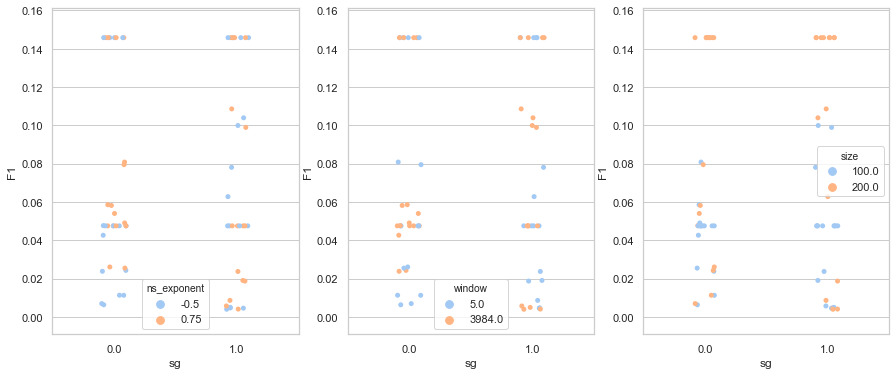

In [63]:
fig = plt.figure(figsize=(15,6))
sns.catplot(x="sg", y="F1", hue="ns_exponent", data=df, ax=fig.add_subplot(131))
sns.catplot(x="sg", y="F1", hue="window", data=df, ax=fig.add_subplot(132))
sns.catplot(x="sg", y="F1", hue="size", data=df, ax=fig.add_subplot(133))
plt.close(2)
plt.close(3)
plt.close(4)
plt.show()

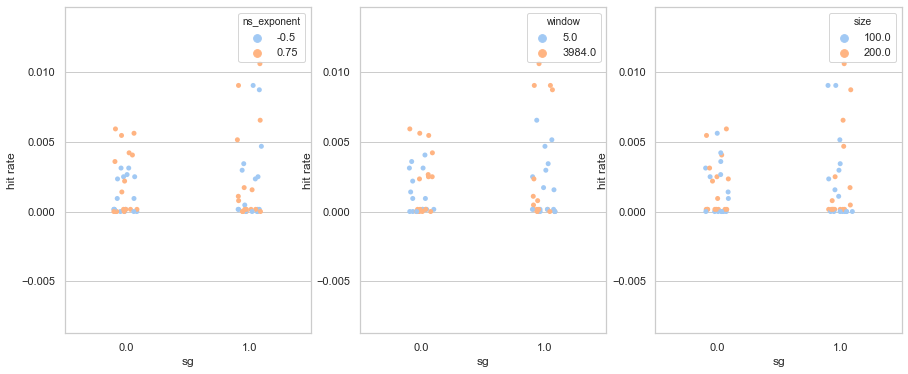

In [64]:
fig = plt.figure(figsize=(15,6))
sns.catplot(x="sg", y="hit rate", hue="ns_exponent", data=df, ax=fig.add_subplot(131))
sns.catplot(x="sg", y="hit rate", hue="window", data=df, ax=fig.add_subplot(132))
sns.catplot(x="sg", y="hit rate", hue="size", data=df, ax=fig.add_subplot(133))
plt.close(2)
plt.close(3)
plt.close(4)
plt.show()

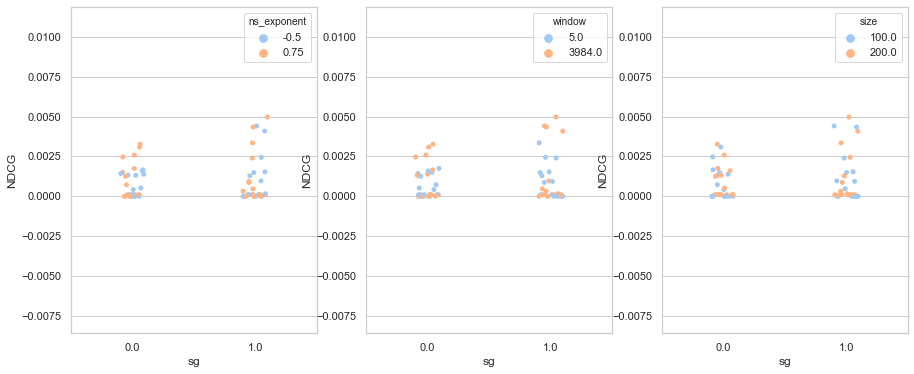

In [65]:
fig = plt.figure(figsize=(15,6))
sns.catplot(x="sg", y="NDCG", hue="ns_exponent", data=df, ax=fig.add_subplot(131))
sns.catplot(x="sg", y="NDCG", hue="window", data=df, ax=fig.add_subplot(132))
sns.catplot(x="sg", y="NDCG", hue="size", data=df, ax=fig.add_subplot(133))
plt.close(2)
plt.close(3)
plt.close(4)
plt.show()

В случае с метрикой `F1` максимальное значение достигается несколькими точками, и среди них присутствуют обе категории по каждому из параметров, кроме `size` (это как-то заставляет задуматься, не ошиблась ли я где-то при вычислении точности или полноты).

В случае с `hit rate` или `NDCG` все интереснее, и одни значения параметров дают более высокие показатели, чем другие. В частности, все лучшие значения получались при использовании алгоритма `Skip-gram`. 

Попробуем определить, какие из рассмотренных нами параметры дают наиболее оптимальный результат.

In [66]:
df.sort_values(by='F1', ascending=False).head(17)

,window,size,sg,negative,ns_exponent,alpha,hit rate,NDCG,precision,recall,F1
35,3984.000,200.000,0.000,0.000,-0.500,0.250,0.000,0.000,0.267,0.100,0.146
53,5.000,200.000,1.000,0.000,0.750,0.250,0.000,0.000,0.267,0.100,0.146
21,5.000,200.000,1.000,0.000,0.750,0.050,0.000,0.000,0.267,0.100,0.146
19,3984.000,200.000,0.000,0.000,0.750,0.050,0.000,0.000,0.267,0.100,0.146
17,5.000,200.000,0.000,0.000,0.750,0.050,0.000,0.000,0.267,0.100,0.146
39,3984.000,200.000,1.000,0.000,-0.500,0.250,0.000,0.000,0.267,0.100,0.146
49,5.000,200.000,0.000,0.000,0.750,0.250,0.000,0.000,0.267,0.100,0.146
23,3984.000,200.000,1.000,0.000,0.750,0.050,0.000,0.000,0.267,0.100,0.146
51,3984.000,200.000,0.000,0.000,0.750,0.250,0.000,0.000,0.267,0.100,0.146
1,5.000,200.000,0.000,0.000,-0.500,0.050,0.000,0.000,0.267,0.100,0.146


In [67]:
df.sort_values(by='hit rate', ascending=False).head(10)

,window,size,sg,negative,ns_exponent,alpha,hit rate,NDCG,precision,recall,F1
31,3984.000,200.000,1.000,5.000,0.750,0.050,0.011,0.005,0.343,0.064,0.109
14,3984.000,100.000,1.000,5.000,-0.500,0.050,0.009,0.004,0.334,0.059,0.100
30,3984.000,100.000,1.000,5.000,0.750,0.050,0.009,0.004,0.327,0.058,0.099
15,3984.000,200.000,1.000,5.000,-0.500,0.050,0.009,0.004,0.334,0.062,0.104
29,5.000,200.000,1.000,5.000,0.750,0.050,0.007,0.003,0.015,0.006,0.009
27,3984.000,200.000,0.000,5.000,0.750,0.050,0.006,0.003,0.155,0.036,0.058
26,3984.000,100.000,0.000,5.000,0.750,0.050,0.006,0.003,0.157,0.036,0.059
59,3984.000,200.000,0.000,5.000,0.750,0.250,0.005,0.003,0.132,0.034,0.054
28,5.000,100.000,1.000,5.000,0.750,0.050,0.005,0.002,0.049,0.016,0.024
45,5.000,200.000,1.000,5.000,-0.500,0.250,0.005,0.002,0.132,0.041,0.063


In [68]:
df.sort_values(by='NDCG', ascending=False).head(10)

,window,size,sg,negative,ns_exponent,alpha,hit rate,NDCG,precision,recall,F1
31,3984.000,200.000,1.000,5.000,0.750,0.050,0.011,0.005,0.343,0.064,0.109
14,3984.000,100.000,1.000,5.000,-0.500,0.050,0.009,0.004,0.334,0.059,0.100
30,3984.000,100.000,1.000,5.000,0.750,0.050,0.009,0.004,0.327,0.058,0.099
15,3984.000,200.000,1.000,5.000,-0.500,0.050,0.009,0.004,0.334,0.062,0.104
29,5.000,200.000,1.000,5.000,0.750,0.050,0.007,0.003,0.015,0.006,0.009
27,3984.000,200.000,0.000,5.000,0.750,0.050,0.006,0.003,0.155,0.036,0.058
26,3984.000,100.000,0.000,5.000,0.750,0.050,0.006,0.003,0.157,0.036,0.059
59,3984.000,200.000,0.000,5.000,0.750,0.250,0.005,0.003,0.132,0.034,0.054
58,3984.000,100.000,0.000,5.000,0.750,0.250,0.004,0.002,0.118,0.031,0.049
45,5.000,200.000,1.000,5.000,-0.500,0.250,0.005,0.002,0.132,0.041,0.063


Кажется оптимальным выбрать 31 строчку из датасета: такие параметры дают максимальные значения для `hit rate` и `NDCG`, а `F1` при этом тоже неплохой.

In [69]:
opt = df.iloc[31]
opt

window        3984.000
size           200.000
sg               1.000
negative         5.000
ns_exponent      0.750
alpha            0.050
hit rate         0.011
NDCG             0.005
precision        0.343
recall           0.064
F1               0.109
Name: 31, dtype: float64

Что можно сказать об этих параметрах?

* контекстом каждого исполнителя считается весь его плейлист (ширина окна выбрана максимальной длиной плейлиста в датасете)

* получаются 200-мерные вектора

* используется алгоритм `Skip-gram`

* применяется `negative sampling`

* параметр распределения `negative sampling` имеет значение 0.75

    Что интересно, в библиотеке `gensim` это значение по умолчанию, потому что оно лучше всего показало себя при построении векторных представлений слов естественных языков. При этом в статье [Word2vec applied to Recommendation: Hyperparameters Matter](https://arxiv.org/abs/1804.04212) авторы применяли модель Word2Vec к задаче рекомендации и добились лучшего результата со значением параметра -0.5.
    
    
* выбран меньший `learning rate` из двух имеющихся

In [70]:
model = Word2Vec(window=int(df.iloc[31]['window']), size=int(df.iloc[31]['size']), sg=df.iloc[31]['sg'], 
                 negative=int(df.iloc[31]['negative']), ns_exponent=df.iloc[31]['ns_exponent'], 
                 alpha=df.iloc[31]['alpha'], workers=4)
model.build_vocab(sessions['artist_name'].tolist())
model.train(X_train, total_examples=X_train.shape[0], epochs=model.epochs)

(12240455, 12511325)

Посмотрим на визуализацию полученных векторов, используя UMAP.

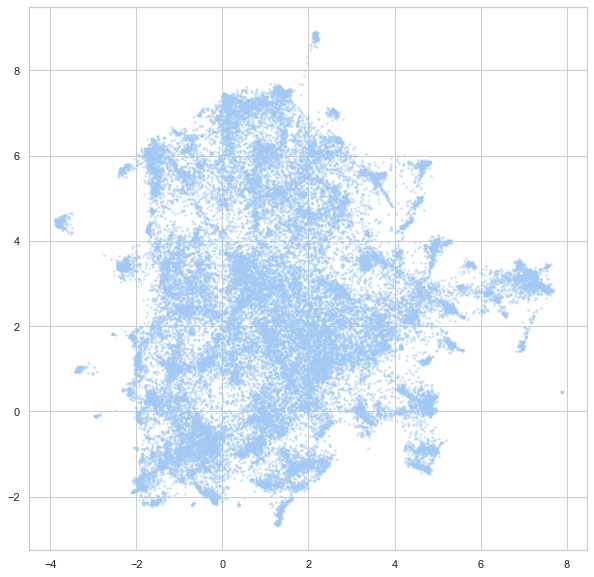

In [71]:
embedding = umap.UMAP(n_components=2).fit_transform(model.wv[model.wv.vocab])
plt.figure(figsize=(10,10))
plt.scatter(embedding[:, 0], embedding[:, 1], s=3, alpha=0.4)
plt.show()

Здесь получился более интересный график: есть много маленьких кластеров точек по краям, слабо связанных с остальными. Можно проинтерпретировать это как лучшее представление для не самых популярных исполнителей, которых редко встречались среди имеющихся данных. При этом сам большой центральный кластер тоже выглядит менее однородно.

Посмотрим на значения метрик качества на тесте и их разницу с моделью по умолчанию.

In [77]:
HR, ndcg, prec, rec, f1 = scores(X_test, y_test, base_model)
print("Base model")
print(f"test hit rate: {HR}")
print(f"test NDCG: {ndcg}")
print(f"test precision: {prec}")
print(f"test recall: {rec}")
print(f"test F1: {f1}")

Base model
test hit rate: 0.0032406830362707215
test NDCG: 0.0018042224935865348
test precision: 0.08076779259628568
test recall: 0.017620249979864236
test F1: 0.028929301947782926


In [78]:
HR, ndcg, prec, rec, f1 = scores(X_test, y_test, model)
print("Model with tuned hyperparameters")
print(f"test hit rate: {HR}")
print(f"test NDCG: {ndcg}")
print(f"test precision: {prec}")
print(f"test recall: {rec}")
print(f"test F1: {f1}")

Model with tuned hyperparameters
test hit rate: 0.012838090489841705
test NDCG: 0.006499038639821779
test precision: 0.35549046491337405
test recall: 0.06707825972038328
test F1: 0.11286060867020525


### Статистическая значимость

Видно, что значения улучшились. Попробуем оценить статистическую значимость полученного результата. Для этого нам нужно получить некоторые выборки для значений метрик, оценив качество моделей на различных тестовых данных. Так как у нас только одна тестовая выборка, можно использовать, например, бутстрэп. Я решила 15 раз пробутстрэпить тестовую выборку, тем самым получив по 15 значений для каждой метрики.

In [90]:
def bootstrap(X):
    X_b = []
    for sample in X:
        resample = np.array(sample)[np.random.choice(len(sample), size=len(sample))]
        X_b.append(resample)
    return np.array(X_b)


comp = {'base': [], 'tuned': []}
for i in range(15):
    print(f"{i + 1}th iteration")
    X_b = bootstrap(X_test)
    comp['base'].extend(scores(X_b, y_test, base_model))
    comp['tuned'].extend(scores(X_b, y_test, model))
print(comp)

1th iteration
2th iteration
3th iteration
4th iteration
5th iteration
6th iteration
7th iteration
8th iteration
9th iteration
10th iteration
11th iteration
12th iteration
13th iteration
14th iteration
15th iteration
{'base': [0.001994266483858906, 0.0011954045579722608, 0.05920478623956126, 0.01425202381703335, 0.022973718105060676, 0.0026174747600648134, 0.0011776534673001138, 0.06031409697120777, 0.014162851625918719, 0.022939167687314386, 0.0013710582076529975, 0.0007916675939014503, 0.05945406955004363, 0.014358277406040381, 0.023130493981594818, 0.0026174747600648134, 0.001494537680520593, 0.06082512775769662, 0.014331092478548831, 0.02319676343954054, 0.0014956998628941791, 0.0006185495278231266, 0.060800199426648396, 0.014488988818166706, 0.023401325746015892, 0.0017449831733765424, 0.0009475031746290594, 0.0601894553159666, 0.014360182590858486, 0.023188082267062708, 0.001994266483858906, 0.0008713340239728537, 0.05974074535709834, 0.014472695718726737, 0.0233006209395367, 0.00

Для определения статистической значимости результата можно применять как параметрические статистические критерии, так и непараметрические. Посмотрим на гистограммы получившихся выборок. Будет здорово, если их можно считать нормальными и применять t-test.

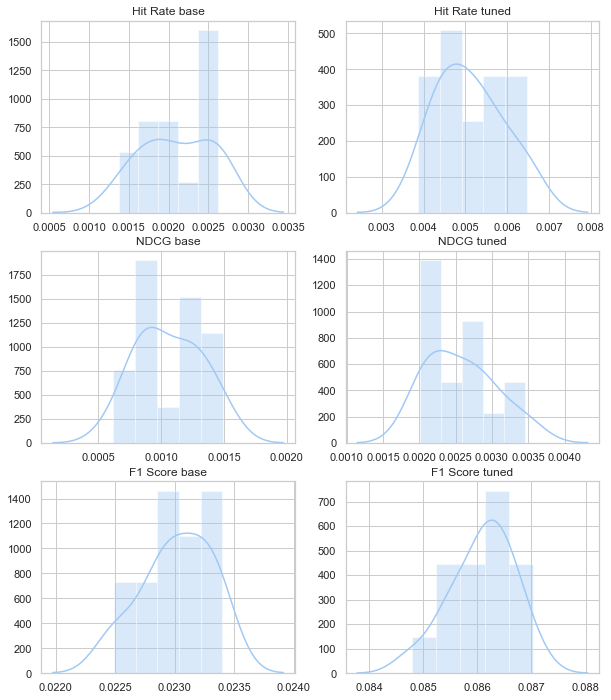

In [162]:
hr1 = comp['base'][0::5]
hr2 = comp['tuned'][0::5]
ndcg1 = comp['base'][1::5]
ndcg2 = comp['tuned'][1::5]
f1_1 = comp['base'][4::5]
f1_2 = comp['tuned'][4::5]

fig = plt.figure(figsize=(10,12))
ax1 = fig.add_subplot(321)
ax1.title.set_text('Hit Rate base')
ax2 = fig.add_subplot(322)
ax2.title.set_text('Hit Rate tuned')
ax3 = fig.add_subplot(323)
ax3.title.set_text('NDCG base')
ax4 = fig.add_subplot(324)
ax4.title.set_text('NDCG tuned')
ax5 = fig.add_subplot(325)
ax5.title.set_text('F1 Score base')
ax6 = fig.add_subplot(326)
ax6.title.set_text('F1 Score tuned')

sns.distplot(hr1, ax=ax1, bins='rice')
sns.distplot(hr2, ax=ax2,  bins='rice')
sns.distplot(ndcg1, ax=ax3,  bins='rice')
sns.distplot(ndcg2, ax=ax4,  bins='rice')
sns.distplot(f1_1, ax=ax5,  bins='rice')
sns.distplot(f1_2, ax=ax6,  bins='rice')

plt.show()

Выглядят они не совсем нормальными, но это может быть связано с небольшим размером выборки. В целом для большинства данных приближение их плотности выглядит похоже на нормальную.

Теперь посмотрим на probability plot с нормальным распределением.

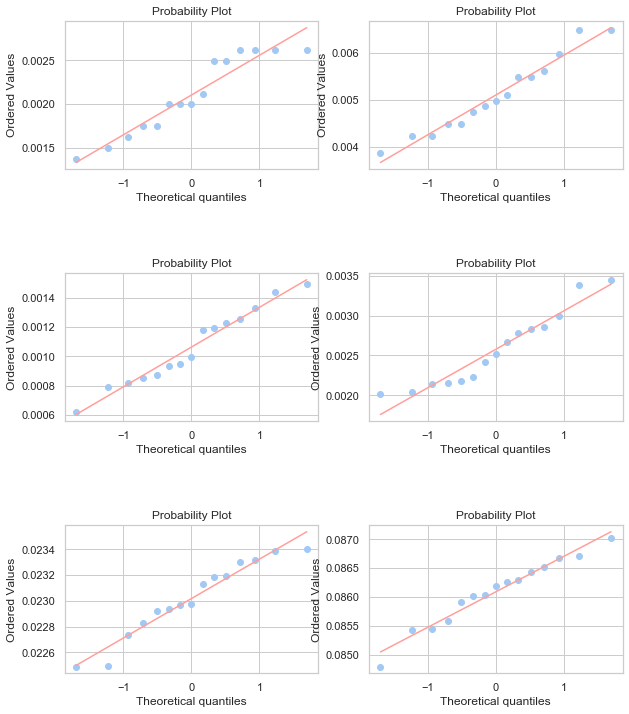

In [156]:
fig = plt.figure(figsize=(10,12))
ax1 = fig.add_subplot(321)
ax2 = fig.add_subplot(322)
ax3 = fig.add_subplot(323)
ax4 = fig.add_subplot(324)
ax5 = fig.add_subplot(325)
ax6 = fig.add_subplot(326)

stats.probplot(hr1, dist="norm", plot=ax1)
stats.probplot(hr2, dist="norm", plot=ax2)
stats.probplot(ndcg1, dist="norm", plot=ax3)
stats.probplot(ndcg2, dist="norm", plot=ax4)
stats.probplot(f1_1, dist="norm", plot=ax5)
stats.probplot(f1_2, dist="norm", plot=ax6)
fig.subplots_adjust(hspace=.7)
plt.show()

Почти на всех графиках точки находится близко к прямой, это хороший знак. 

Напоследок проверим гипотезу о принадлежности нормальному распределению, используя критерий Шапиро-Уилка  из `scipy.stats` c уровнем значимости 0.05.

В `scipy.stats` проверяется нулевая гипотеза о том, что данные удовлетворяют нормальному распределению. Если полученное p value меньше уровня значимости, то нулевая гипотеза отвергается, иначе у нас недостаточно аргументов, чтобы отвергнуть нулевую гипотезу.

In [170]:
def shapiro(data, alpha0=0.05):
    pval = stats.shapiro(data)[1]
    if pval >= alpha0:
        print("By Shapiro-Wilk test, data was drawn from normal distribution.")
    else:
        print("By Shapiro-Wilk test, data wasn't drawn from normal distribution.")
    
    
print("Hit Rate base")
shapiro(hr1)
print("Hit Rate tuned")
shapiro(hr2)
print("NDCG base")
shapiro(ndcg1)
print("NDCG tuned")
shapiro(ndcg2)
print("F1 Score base")
shapiro(f1_1)
print("F1 Score tuned")
shapiro(f1_2)

Hit Rate base
By Shapiro-Wilk test, data was drawn from normal distribution.
Hit Rate tuned
By Shapiro-Wilk test, data was drawn from normal distribution.
NDCG base
By Shapiro-Wilk test, data was drawn from normal distribution.
NDCG tuned
By Shapiro-Wilk test, data was drawn from normal distribution.
F1 Score base
By Shapiro-Wilk test, data was drawn from normal distribution.
F1 Score tuned
By Shapiro-Wilk test, data was drawn from normal distribution.


Мы нигде не отвергаем гипотезу о принадлежности нормальному распределнию, но это может быть связано с небольшим размером выборки и отсутствием достаточных аргументов. Тем не менее, вместе с гистограммами и probability plots складывается впечатление, что данные вполне могут удовлетворять нормальному распределению.

Начнем с [t-test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html), использующего предположение, что данные распределены нормально.

In [171]:
def ttest(data1, data2, alpha0=0.05):
    pval = stats.ttest_ind(data1, data2)[1]
    if pval >= alpha0:
        print("By Independent Samples t-Test, there is no statistically significant difference between the means of two samples.")
    else:
        print("By Independent Samples t-Test, there is statistically significant difference between the means of two samples.")

print("Hit Rate")
ttest(hr1, hr2)
print("NDCG")
ttest(ndcg1, ndcg2)
print("F1 Score")
ttest(f1_1, f1_2)

Hit Rate
By Independent Samples t-Test, there is statistically significant difference between the means of two samples.
NDCG
By Independent Samples t-Test, there is statistically significant difference between the means of two samples.
F1 Score
By Independent Samples t-Test, there is statistically significant difference between the means of two samples.


На cлучай того, что предположение о нормальности ошибочно, воспользуемся также непараметрическим критерием, например, [критерием Колмогорова-Смирнова](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_2samp.html).

In [176]:
def kstest(data1, data2, alpha0=0.05):
    pval = stats.ks_2samp(data1, data2, mode='less')[1]
    if pval >= alpha0:
        print("By Kolmogorov-Smirnov Test, the distributions of the two samples are the same.")
    else:
        print("By Kolmogorov-Smirnov Test, the distributions of the two samples are not the same (and 1st sample's cdf is <= 2nd's).")

        
print("Hit Rate")
kstest(hr1, hr2)
print("NDCG")
kstest(ndcg1, ndcg2)
print("F1 Score")
kstest(f1_1, f1_2)        

Hit Rate
By Kolmogorov-Smirnov Test, the distributions of the two samples are not the same (and 1st sample's cdf is <= 2nd's).
NDCG
By Kolmogorov-Smirnov Test, the distributions of the two samples are not the same (and 1st sample's cdf is <= 2nd's).
F1 Score
By Kolmogorov-Smirnov Test, the distributions of the two samples are not the same (and 1st sample's cdf is <= 2nd's).


Используя оба теста, мы для всех рассматриваемых метрик признаем улучшение результатов модели с подобранными гиперпараметрами статистически значимым.

### Примеры рекомендаций

Здесь видно проблему текущего подхода: для получения рекомендаций для исполнителя нужно передать его имя в той же форме, как оно указано в датасете (где, в том числе, были различные опечатки, фиты и т.д.). Это максимально неудобно. Первой приходит в голову идея пользоваться каким-нибудь id вместо имени, но у этого подхода тоже есть свои недостатки. В любом случае, на данном этапе я решила оставить это как есть.

#### 1. Известные исполнители

Рассмотрим несколько достаточно разных исполнителей, которых, наверное, знает каждый.

In [210]:
model.wv.similar_by_vector(model.wv['Lana Del Rey'], topn=20+1)[1:]

[('Lorde & Yonas', 0.8558769226074219),
 ('Sia', 0.8372328281402588),
 ('The xx', 0.825348973274231),
 ('Coldplay & Kylie Minogue', 0.8225135803222656),
 ('Ed Sheeran & Peter Jackson', 0.7928698062896729),
 ('Beyonc?', 0.7823324203491211),
 ('lykkeli', 0.7771875858306885),
 ('CHVRCHES', 0.7735813856124878),
 ('Ellie Goulding & DJ Fresh', 0.7712898254394531),
 ('Calvin Harris feat. Florence Welch', 0.7691230773925781),
 ('Banks', 0.7682086229324341),
 ('Sam Smith', 0.7649847269058228),
 ('Bastille & Ella', 0.7644087076187134),
 ('Pharrell Williams', 0.7557681798934937),
 ('Katy Perry Ft Juicy J', 0.7521458864212036),
 ('Hozier', 0.7480272054672241),
 ('Imagine Dragons', 0.7469155192375183),
 ('OneRepublic & Sara Bareilles', 0.7273571491241455),
 ('Nicki Minaj', 0.7208849191665649),
 ('The Killers Feat. Elton John & Neil Tennant', 0.7196308970451355)]

In [178]:
model.wv.similar_by_vector(model.wv['Frank Sinatra & Tanya Tucker'], topn=20+1)[1:]

[('Louis Armstrong & Ella Fitzgerald with Sy Oliver\x92s Orchestra',
  0.8038256168365479),
 ('Dean Martin With Nelson Riddle & His Orchestra', 0.7943907380104065),
 ('Nat King Cole & Dean Martin', 0.7872231602668762),
 ('Ella Fitzgerald & The Four Hits And A Miss', 0.7844401001930237),
 ('Elvis Presley & Martina McBride', 0.781723141670227),
 ('Tony Bennett & Bono', 0.7343928813934326),
 ('Peggy Lee', 0.7178518772125244),
 ('02 Beach Boys & Kathy Troccoli', 0.717160701751709),
 ('Nina Sinome', 0.7029466032981873),
 ('Jackson Five', 0.7009326815605164),
 ('Ray Charles & James Taylor', 0.6869168877601624),
 ('Elton John & Billy Joel', 0.6835497617721558),
 ('Santana & Wyclef feat. Avicii & Alexandre Pires', 0.6735095977783203),
 ('Bing Crosby & Bob Hope', 0.6728062629699707),
 ('Aretha Franklin & Ray Bryant Combo', 0.6697524189949036),
 ('ABBA', 0.6660109758377075),
 ('Beegees', 0.6631549596786499),
 ('Billy Joel', 0.6619125008583069),
 ('Chuck Berry', 0.6607998609542847),
 ('Michael Bu

In [180]:
model.wv.similar_by_vector(model.wv['Coldplay & Kylie Minogue'], topn=20+1)[1:]

[('Imagine Dragons', 0.8746901750564575),
 ('Ed Sheeran & Peter Jackson', 0.8385027647018433),
 ('Lorde & Yonas', 0.8375802636146545),
 ('Kings of Leon', 0.830150842666626),
 ('Lana Del Rey', 0.8225136399269104),
 ('Muse - Absolution', 0.8102858066558838),
 ('OneRepublic & Sara Bareilles', 0.8057200908660889),
 ('Foster the People', 0.8005774021148682),
 ('The Killers Feat. Elton John & Neil Tennant', 0.7966490983963013),
 ('Sia', 0.7940754294395447),
 ('The xx', 0.7937020063400269),
 ('Arctic Monekys', 0.7930546998977661),
 ('Bastille & Ella', 0.7837287187576294),
 ('Bruno Mars & Damian Marley', 0.779219388961792),
 ('Pharrell Williams', 0.7767707705497742),
 ('Red Hot Chili Peppers -', 0.7756190299987793),
 ('Adele & The Raconteurs', 0.7692451477050781),
 ('Of Monsters and Men', 0.76882404088974),
 ('Avicii & B & B And Choir', 0.7683067321777344),
 ('Snow Patrol', 0.7670386433601379)]

In [192]:
model.wv.similar_by_vector(model.wv['Pink Floyd & Floyd'], topn=20+1)[1:]

[('Led Zepplin', 0.8501531481742859),
 ('The Beatles & George Martin', 0.8379693031311035),
 ('The Doors', 0.8362013697624207),
 ('Queen & The Muppets', 0.806839108467102),
 ('Jimmy Hendrix', 0.8006929159164429),
 ('Dire Straights', 0.7759004831314087),
 ('Nirvana-in utero', 0.7707040309906006),
 ('Deep Purple & Luciano Pavarotti - Nessun Dorma', 0.7674272060394287),
 ('Metallica, Michael Kamen & San Francisco Symphony', 0.7646530866622925),
 ('Rolling Stones', 0.7569206953048706),
 ('AC-DC', 0.7563419938087463),
 ('Iron Maiden', 0.7487862706184387),
 ('Black Sabbath & Junkie XL', 0.7446615695953369),
 ('Red Hot Chili Peppers -', 0.744453489780426),
 ('Aerosmith', 0.7269631028175354),
 ('Lynyrd Skynyrd', 0.7242144346237183),
 ('Pearl Jam', 0.7196934223175049),
 ('Bob Dylan & Tom Petty', 0.7164956331253052),
 ('Bowie', 0.715230405330658),
 ('RadioheadNCON', 0.7126377820968628)]

#### 4. Исполнители из моего плейлиста

Здесь я попробовала выбрать достаточно разных исполнителей, которых я сама слушаю, чтобы можно было дать какую-то **субъективную** оценку для полученных рекомендаций.

In [195]:
model.wv.similar_by_vector(model.wv['National, The'], topn=20+1)[1:]

[('Arcade Fire', 0.8899957537651062),
 ('Death Cab for Cutie', 0.8236068487167358),
 ('Vampire Weekend', 0.8177170753479004),
 ('BonIver', 0.8153641223907471),
 ('Band of Horses', 0.814795970916748),
 ('The Shins', 0.8110699653625488),
 ('Interpol', 0.8073168992996216),
 ('MGMT', 0.804365336894989),
 ('Phoenix', 0.8001028895378113),
 ('The xx', 0.7866520881652832),
 ('Of Monsters and Men', 0.7805016040802002),
 ('Grizzly Bear', 0.7784099578857422),
 ('Alt-J ∆', 0.7778271436691284),
 ('Foals', 0.7695192694664001),
 ('lykkeli', 0.7681227326393127),
 ('Warpaint', 0.763705849647522),
 ('Bombay Bicycle Club', 0.7632770538330078),
 ('two doors cinema club', 0.7605209350585938),
 ('The Black Keys', 0.7594600915908813),
 ('Modest Mouse', 0.7583862543106079)]

Мне понравились рекомендованные здесь исполнители - я знаю и люблю почти всех. Здесь, на мой взгляд, хорошо видно, что модель строилась на основании данных о прослушивании музыки и не использовала дополнительную информацию о жанрах. Я легко могу понять людей, которые в одном плейлисте слушали бы этих исполнителей - даже если жанры их творчества немного отличаются, атмосфера в целом похожа.

In [208]:
model.wv.similar_by_vector(model.wv['Blind Guardian'], topn=20+1)[1:]

[('Iced Earth', 0.7881360054016113),
 ('Helloween & Candice Night', 0.7773070931434631),
 ('Eluveitie', 0.7703346610069275),
 ('Sonata Arctica', 0.7681452035903931),
 ('Accept', 0.7527748346328735),
 ('Dream Theater', 0.7524993419647217),
 ('Dark Tranquillity', 0.7479664087295532),
 ('Amorphis', 0.7465233206748962),
 ('Ensiferum', 0.7405018210411072),
 ('Dimmu Borgir', 0.7378028035163879),
 ('Amon Amarth', 0.737163782119751),
 ('Children of Bodom', 0.7365540266036987),
 ('HammerFall', 0.7352928519248962),
 ('Epica', 0.72968590259552),
 ('Therion', 0.7284634709358215),
 ('Insomnium', 0.7218372821807861),
 ('Sabaton', 0.7174149751663208),
 ('Opeth', 0.7135246992111206),
 ('Paradise Lost', 0.7127455472946167),
 ('The Devin Townsend Project', 0.7106245756149292)]

Здесь я бы охарактеризовала большинство исполнителей как что-то около пауэр-метала / фолк-метала, так что эти рекомендации тоже вполне хороши.

In [198]:
print("Tuned")
model.wv.similar_by_vector(model.wv['Сплин'], topn=20+1)[1:]

Tuned


[('Ляпис Трубицкой & Грув', 0.7577726244926453),
 ('Океан Ельзи', 0.7521889209747314),
 ('Наутилус Помпилиус', 0.7392306923866272),
 ('Би-2', 0.7376981973648071),
 ('КиШ', 0.7121442556381226),
 ('Агата Кристи', 0.6946380734443665),
 ('Аквариум', 0.6935772895812988),
 ('DDT', 0.6706528663635254),
 ('Ария & В. Кипелов', 0.67046058177948),
 ('Мумий Тролль', 0.6600937247276306),
 ('Noize MC', 0.6555871367454529),
 ('Кукрыниксы', 0.639130175113678),
 ('Мара', 0.6372122764587402),
 ('Алиса', 0.6360700726509094),
 ('Louna', 0.6348291635513306),
 ('Lumen', 0.629654049873352),
 ('Znaki', 0.6218613386154175),
 ('Ва-Банкъ', 0.61865234375),
 ("Канцлер Ги & Брэган Д'Эрт", 0.6174610257148743),
 ('Animal Джаz', 0.6163891553878784)]

In [201]:
print("Base")
base_model.wv.similar_by_vector(base_model.wv['Сплин'], topn=20+1)[1:]

Base


[('Eluveitie', 0.9330199956893921),
 ('Alter Bridge', 0.9068418741226196),
 ('Hey & Agnieszka Chylińska', 0.9007869958877563),
 ('Океан Ельзи', 0.8882135152816772),
 ('Epica', 0.885991096496582),
 ('The Algorithm', 0.8686482906341553),
 ('Finntroll', 0.852284848690033),
 ('Jeremy Soule & Julian Soule', 0.8493694067001343),
 ('Slipknot', 0.8490339517593384),
 ('Ylvis', 0.8401978611946106),
 ('Within Temptation & The Metropole Orchestra Feat. Keith Caputo',
  0.8381627798080444),
 ('Myslovitz & Edyta Bartosiewicz', 0.8372032642364502),
 ('At the Gates', 0.8358471393585205),
 ('In Flames', 0.8346608281135559),
 ('Marilyn Manson & Sneaker Pimps', 0.8337137699127197),
 ('Him & Her', 0.8315655589103699),
 ('Rammstien', 0.8258443474769592),
 ('Anathema', 0.8254175186157227),
 ('Paradise Lost', 0.823293149471283),
 ('Amon Amarth', 0.8204631805419922)]

Очень интересно получается с рекомендациями к группе Сплин. Для модели с подобранными гиперпараметрами они полностью состоят из русских исполнителей. При этом первоначальная модель рекомендовала в основном иностранных исполнителей, причем среди них встречались не очень похожие - например, группа Ylvis, известная по What does the fox say? 

Мне кажется, что это связано с выбором алгоритма Skip-gram и, возможно, повышением размерности векторов, что позволило лучше работать даже с редко встречающимися исполнителями.

Ради интереса посмотрим на еще какого-нибудь русского исполнителя:

In [228]:
model.wv.similar_by_vector(model.wv['Oxxxymiron'], topn=20+1)[1:]

[('Anacondaz', 0.5733085870742798),
 ('Океан Ельзи', 0.5434434413909912),
 ('Наив', 0.5305992364883423),
 ('Мумий Тролль', 0.5265881419181824),
 ('Сплин', 0.5262014865875244),
 ('Animal Джаz', 0.526029109954834),
 ('КиШ', 0.5257402658462524),
 ('Психея', 0.5172896385192871),
 ('Ассаи', 0.513435959815979),
 ('Оригами', 0.5110832452774048),
 ('Stigmata', 0.5102952718734741),
 ('Слот', 0.5094505548477173),
 ('Аквариум', 0.5071245431900024),
 ('Агата Кристи', 0.5067912936210632),
 ('Би-2', 0.49632832407951355),
 ('Mujuice', 0.49376362562179565),
 ('DDT', 0.4934338331222534),
 ('Noize MC', 0.4934237599372864),
 ('Trash Palace', 0.4920504093170166),
 ('Ленинград', 0.4821738302707672)]

Для Оксимирона рекомендации получились странными - среди них много рок-групп. При этом по приведенным значениям видно, что даже самые близкие с точки зрения модели исполнители достаточно далеки от него. Возможно, в выборке было мало русских хип-хоп исполнителей (или они отбросились на этапе, когда я оставила только исполнителей с MBID).